# **EXP5 Dissociated and Classic Bulks Deconvolution by Adding More Cells**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False
add_adipo = False

In [3]:
# Paths:
res_name_adip = f"MCT_adp_EXP3"
pseudo_name_adip = "MCT_adp_EXP3"
files_path_adip= "/../data/EXP3/"
path_results_adip = "/../results/EXP3/"
data_path_adip = "/../data/EXP3/cibersort/"
cibersort_files_adip = (
    "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/"
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses."
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt")
# parameters into paths
actual_path_adip = os.getcwd()
path_adip = f"{actual_path_adip}{files_path_adip}"
aug_data_path_adip = f"{actual_path_adip}{files_path_adip}"
cibersort_path_adip = f"{actual_path_adip}{cibersort_files_adip}"
path_results_adip = f"{actual_path_adip}{path_results_adip}"
data_path_adip = f"{actual_path_adip}{data_path_adip}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [4]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Dissociated Bulks:

In [5]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            3        0      0           2           0           0   
2467            1        0      0           5           0           0   
2380            4        0      0           2           0           0   
2293            2        0      0           4           0           0   
2283            1        0      0           1           0           0   
2428            3        2      0           1           0           0   
2251            8        0      0           1           0           1   
2267            1        0      0           1           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          15           0           1           0  ...           0   
2467          63           1           6           0  ...           0   
2380          37           0           2           0  ...           0   
2293          31           0           3           0  ...           0   
2283          33           0           2           0  ...           0   
2428           7           0           5           0  ...           0   
2251          38           0           0           0  ...           0   
2267          26           0           5           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          19           0           1           1           3           4   
2467          27           0           0           0           0           0   
2380           2           0           0           0           0           0   
2293           6           0           0           6           0           0   
2283           6           0           0           1           0           0   
2428          17           0           0           2           0           0   
2251           4           0           0           4           0           0   
2267          19           0           2          11           0           1   

      AC007325.4  AC007325.2  condition  
2497          39          28  rrna_diss  
2467           8           6  rrna_diss  
2380          10          21  rrna_diss  
2293           6           2  rrna_diss  
2283          20          16  rrna_diss  
2428          57          30  rrna_diss  
2251          10           9  rrna_diss  
2267          15           3  rrna_diss  

[8 rows x 36602 columns]

Dissociated polyA:

In [6]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497           17        2      0          10           0           2   
2467            2        1      0           7           0           3   
2380            5        1      0           6           0           0   
2293            4        0      0          13           0           4   
2283            7        0      0          11           0           9   
2428            0        0      0           1           0           0   
2251            2        0      0           6           0           1   
2267            0        0      0           5           0           1   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          66           0          15           1  ...           1   
2467         134           0           8           0  ...           4   
2380         159           0          16           0  ...           0   
2293          92           0           5           0  ...           0   
2283         114           0          12           0  ...           0   
2428          14           0          10           0  ...           0   
2251          93           0           9           1  ...           0   
2267          69           0          12           0  ...           1   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          35           0           0           9           9           7   
2467          58           0           1           2           0           0   
2380           2           0           2           6           0           0   
2293          16           0           0           1           0           0   
2283           9           0           0           1           0           0   
2428          35           0           0           6           0           0   
2251           6           0           2          16           0           0   
2267          33           0           4          30           0           0   

      AC007325.4  AC007325.2   condition  
2497          56          78  polyA_diss  
2467          15          11  polyA_diss  
2380          27          32  polyA_diss  
2293           4           6  polyA_diss  
2283          10          17  polyA_diss  
2428          51          27  polyA_diss  
2251          10          12  polyA_diss  
2267           6           3  polyA_diss  

[8 rows x 36602 columns]

And all single-cells:

In [7]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [8]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [9]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [10]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

## Adding Adipocyte and Medothelial Cells to Reference (if set)

In [11]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [12]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values

cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

In [13]:
#and as anndata object single nucleus 
adata_path_adip = os.path.join(path_adip, f"MCT_adp_EXP3_snadata_notlog.h5ad")
adata_path_adip = Path(adata_path_adip)
sn_adata = sc.read_h5ad(adata_path_adip)
cells_to_keep = ["Fat cell", "fat cell"]
sn_adata = sn_adata[sn_adata.obs.cell_types.isin(cells_to_keep)]
sn_adata.obs.cell_types.value_counts()

Fat cell    24825
Name: cell_types, dtype: int64

In [14]:
genes_adatas = np.intersect1d(merged_adata.var["gene_ids"].values, sn_adata.var["gene_ids"].values)
merged_adata = merged_adata[:, genes_adatas]
sn_adata = sn_adata[:, genes_adatas]
merged_adata = sc.concat([sn_adata, merged_adata])
merged_adata.obs_names_make_unique()
print(merged_adata.obs.cell_types.value_counts())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat cell             24825
T cells               7419
Plasma cells          1983
Epithelial cells      1694
Fibroblasts           1587
Endothelial cells     1189
Macrophages           1116
NK cells               842
Unknown1               512
Monocytes              272
B cells                264
pDC                    170
Unknown2               155
DC                      98
ILC                     89
Mast cells              27
Erythroid               21
Name: cell_types, dtype: int64


In [15]:
if add_adipo:
    print("Keeping all cells")
    print(merged_adata.obs.cell_types.value_counts())
else:
    print("Removing adipocytes")
    merged_adata = merged_adata[merged_adata.obs.cell_types != "Fat cell"]
    print(merged_adata.obs.cell_types.value_counts())

Removing adipocytes
T cells              7419
Plasma cells         1983
Epithelial cells     1694
Fibroblasts          1587
Endothelial cells    1189
Macrophages          1116
NK cells              842
Unknown1              512
Monocytes             272
B cells               264
pDC                   170
Unknown2              155
DC                     98
ILC                    89
Mast cells             27
Erythroid              21
Name: cell_types, dtype: int64


And final formatting on the bulks:

In [16]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [17]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Assigning genes: 

In [18]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Now the other cibersort genes for adipocytes and dissociation markers:

In [19]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values
cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

Defining gene markers:

In [20]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [21]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/projects/aivich@xsede.org/code-server/tmp/ipykernel_1801141/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  adip_markers = np.array(adip_markers)


In [22]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'A2M.AS1',
 'A2ML1.AS1',
 'AADACL2.AS1',
 'AAGAB',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCA9.AS1',
 'ABCB1',
 'ABCB10',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC9',
 'ABCD2',
 'ABCE1',
 'ABCG1',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABHD5',
 'ABHD6',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002066.1',
 'AC002070.1',
 'AC002091.1',
 'AC002429.2',
 'AC003991.1',
 'AC004551.1',
 'AC004594.1',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC004862.1',
 'AC004917.1',
 'AC005037.1',
 'AC005064.1',
 'AC005162.3',
 'AC005237.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005699.1',
 'AC005920.2',
 'AC006064.2',
 'AC006160.1',
 'AC006369.1',
 'AC006387.1',
 'AC006449.6',
 'AC007032.1',
 'AC007114.2',
 'AC007319.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007529.2',
 'AC007563.

In [23]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids.shape

(4584,)

In [24]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [25]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[16 rows x 4584 columns]

In [26]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  

[8 rows x 4584 columns]

In [27]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[8 rows x 4584 columns]

In [28]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.022896  1.0  0.169267  0.493974  0.209695  0.059999  0.117051   
2467  0.028579  1.0  0.169502  0.439521  0.244398  0.100518  0.050259   
2380  0.010532  1.0  0.203908  0.493592  0.295521  0.072453  0.047963   
2293  0.006858  1.0  0.292518  0.466563  0.249716  0.046349  0.097427   
2283  0.016514  1.0  0.210502  0.348468  0.248338  0.053305  0.073373   
2428  0.028283  1.0  0.195912  0.150383  0.268574  0.154752  0.026443   
2251  0.009285  1.0  0.144343  0.476753  0.246480  0.068542  0.045075   
2267  0.012057  1.0  0.195362  0.167578  0.247785  0.036346  0.076013   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.721049  0.171837  0.085767  ...  0.299845  0.057959  0.073979   
2467  1.000000  0.241638  0.077655  ...  0.345704  0.089678  0.140134   
2380  1.000000  0.254790  0.107601  ...  0.236899  0.057734  0.081462   
2293  1.000000  0.117054  0.064557  ...  0.290863  0.057463  0.133844   
2283  0.882353  0.165559  0.109745  ...  0.336134  0.069819  0.177265   
2428  1.000000  0.316172  0.074502  ...  0.243050  0.059785  0.045989   
2251  1.000000  0.241753  0.233987  ...  0.207820  0.043218  0.102475   
2267  1.000000  0.155346  0.068150  ...  0.241494  0.065354  0.085100   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.080024  0.390222  0.062871  0.479541  0.571202  0.308006  1.000000  
2467  0.067012  0.240061  0.182313  0.251099  0.976408  0.373100  1.000000  
2380  0.108489  0.617942  0.106966  0.118894  0.617942  0.254663  1.000000  
2293  0.175936  0.654086  0.188942  0.222522  0.439841  0.296302  1.000000  
2283  0.242903  0.728082  0.119988  0.431247  1.000000  0.475145  1.000000  
2428  0.106464  0.713744  0.033342  0.286969  0.473223  0.695118  0.986456  
2251  0.101124  0.572138  0.101968  0.236013  0.435561  0.360097  1.000000  
2267  0.010659  0.461670  0.200430  0.084925  0.518811  0.219127  1.000000  

[8 rows x 4584 columns]

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [29]:
Counter(merged_adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [30]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Erythroid'
 'Fibroblasts' 'ILC' 'Macrophages' 'Mast cells' 'Monocytes' 'NK cells'
 'Plasma cells' 'T cells' 'pDC']


## References

In [31]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

Plasma cells     Monocytes      T cells  Endothelial cells  \
A1BG      3037.024414   2688.887695  4290.977539        1752.764648   
A2M       5924.118164   1422.408813  1738.671631       93991.000000   
AAGAB     1486.918335   3136.243164  1410.383057        1784.527344   
AASS      1095.499878    409.847656   316.586761        2962.244385   
AATF      3226.413330   3502.588867  6101.375977        5848.059082   
...               ...           ...          ...                ...   
ZRSR2     1704.064575   2081.046631  5605.381348        2358.655273   
ZSCAN18    761.512695    569.922913   809.173828        2571.005127   
ZSWIM8     921.682495    766.123779  1930.462891        1372.748779   
ZXDC      2950.063477   2218.041016  1710.287476        1355.025146   
ZYX       2188.582764  15590.994141  5661.678711        9643.177734   

            NK cells  Epithelial cells          ILC   Fibroblasts  \
A1BG     5187.788086       4702.957520  4293.773438   4340.587891   
A2M      1575.882568       3877.187012  2655.907471  26851.744141   
AAGAB    1785.435547       1451.080566  2096.083496   1476.758057   
AASS      192.651291        616.188538   688.604248   4404.231934   
AATF     4712.868652       3843.628174  2798.041992   4364.742188   
...              ...               ...          ...           ...   
ZRSR2    5755.137695       1502.121948  3786.138428   2250.075439   
ZSCAN18  1748.276367       3345.392822  3575.276855   2570.705322   
ZSWIM8   1581.538818       1108.767334   984.884583   1846.222778   
ZXDC     2230.757080       2140.932861  1572.085449   1433.612305   
ZYX      8152.545898       7152.000488  4458.413086   7529.203613   

             B cells            DC   Macrophages           pDC   Mast cells  \
A1BG     3827.213135   2952.072266   3134.151367  14104.285156  3721.377197   
A2M      1038.695190   4164.184570  11133.654297    574.331726     0.000000   
AAGAB    3126.311523    843.713074   3124.109375    777.487244   719.507324   
AASS      887.780457      0.000000    295.403595     57.909706  2505.803467   
AATF     5323.497559   2075.095215   4430.243164   3076.302490  3908.167969   
...              ...           ...           ...           ...          ...   
ZRSR2    5715.018555   2218.254150   3176.939941   1080.422485  3459.533203   
ZSCAN18  2896.448730    429.938171    495.478333    357.642944   860.697144   
ZSWIM8   1032.417969   1643.492310   2254.185059   2131.336182  3028.738037   
ZXDC     1697.269775   1729.897217   1870.034302   1719.255981     0.000000   
ZYX      2302.788330  10922.008789  12112.774414   2153.919678  2395.853760   

           Erythroid  
A1BG     2001.918945  
A2M      2521.254639  
AAGAB       0.000000  
AASS        0.000000  
AATF      936.567078  
...              ...  
ZRSR2       0.000000  
ZSCAN18     0.000000  
ZSWIM8      0.000000  
ZXDC        0.000000  
ZYX      9352.052734  

[4584 rows x 14 columns]

In [32]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
A1BG         0.347316   0.307502  0.490718           0.200447  0.593278   
A2M          0.677485   0.162667  0.198835           1.000000  0.180219   
AAGAB        0.170045   0.358662  0.161292           0.204079  0.204183   
AASS         0.125282   0.046870  0.036205           0.338764  0.022032   
AATF         0.368974   0.400558  0.697756           0.668787  0.538966   
...               ...        ...       ...                ...       ...   
ZRSR2        0.194878   0.237989  0.641034           0.269737  0.658160   
ZSCAN18      0.087087   0.065177  0.092537           0.294021  0.199934   
ZSWIM8       0.105404   0.087614  0.220769           0.156988  0.180866   
ZXDC         0.337371   0.253656  0.195589           0.154961  0.255110   
ZYX          0.250287   1.000000  0.647472           1.000000  0.932329   

         Epithelial cells       ILC  Fibroblasts   B cells        DC  \
A1BG             0.537832  0.491038     0.496392  0.437682  0.337600   
A2M              0.443397  0.303731     1.000000  0.118786  0.476218   
AAGAB            0.165946  0.239709     0.168883  0.357526  0.096487   
AASS             0.070468  0.078749     0.503670  0.101527  0.000000   
AATF             0.439559  0.319985     0.499154  0.608798  0.237309   
...                   ...       ...          ...       ...       ...   
ZRSR2            0.171783  0.432985     0.257320  0.653572  0.253681   
ZSCAN18          0.382581  0.408870     0.293987  0.331239  0.049168   
ZSWIM8           0.126799  0.112632     0.211135  0.118068  0.187951   
ZXDC             0.244838  0.179784     0.163949  0.194101  0.197832   
ZYX              0.817906  0.509866     0.861043  0.263348  1.000000   

         Macrophages       pDC  Mast cells  Erythroid  
A1BG        0.358423  1.000000    0.425578   0.228940  
A2M         1.000000  0.065681    0.000000   0.288332  
AAGAB       0.357275  0.088914    0.082283   0.000000  
AASS        0.033782  0.006623    0.286565   0.000000  
AATF        0.506645  0.351807    0.446940   0.107106  
...              ...       ...         ...        ...  
ZRSR2       0.363316  0.123558    0.395634   0.000000  
ZSCAN18     0.056663  0.040900    0.098430   0.000000  
ZSWIM8      0.257790  0.243741    0.346368   0.000000  
ZXDC        0.213858  0.196615    0.000000   0.000000  
ZYX         1.000000  0.246323    0.273991   1.000000  

[4584 rows x 14 columns]

## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [33]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [34]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [35]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [36]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.164780   0.000000  0.000000           0.020272  0.000000   
2467      0.182123   0.000000  0.000000           0.003659  0.000000   
2380      0.044662   0.063118  0.000000           0.291136  0.000000   
2293      0.102606   0.000000  0.002042           0.000000  0.006332   
2283      0.125126   0.000000  0.000000           0.073062  0.000000   
2428      0.209132   0.000000  0.000000           0.018860  0.000000   
2251      0.298698   0.000000  0.000000           0.013688  0.000000   
2267      0.065517   0.114738  0.000000           0.235323  0.000000   
2497      0.173158   0.000000  0.000000           0.126958  0.000000   
2467      0.205793   0.000000  0.000000           0.144049  0.000000   
2380      0.142911   0.080454  0.000000           0.266625  0.000000   
2293      0.178299   0.018984  0.000000           0.166792  0.000000   
2283      0.173278   0.000000  0.000000           0.107188  0.000000   
2428      0.284216   0.000000  0.000000           0.108819  0.000000   
2251      0.341954   0.000000  0.000000           0.343076  0.000000   
2267      0.166859   0.000000  0.064611           0.032358  0.038764   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.330105  0.010356     0.402456  0.004428  0.0     0.067602   
2467          0.592913  0.020108     0.092070  0.000000  0.0     0.109127   
2380          0.000000  0.000000     0.484513  0.000000  0.0     0.116571   
2293          0.399788  0.000000     0.000000  0.000000  0.0     0.476714   
2283          0.475436  0.000000     0.255632  0.000000  0.0     0.070744   
2428          0.549532  0.011441     0.077102  0.050441  0.0     0.083492   
2251          0.000000  0.000000     0.386487  0.020488  0.0     0.280639   
2267          0.000000  0.000000     0.337009  0.000000  0.0     0.247414   
2497          0.223984  0.000000     0.440199  0.000000  0.0     0.026305   
2467          0.026485  0.000000     0.351296  0.000000  0.0     0.272377   
2380          0.000000  0.000000     0.429751  0.000000  0.0     0.080260   
2293          0.226027  0.041311     0.144572  0.000000  0.0     0.224015   
2283          0.361073  0.000000     0.314306  0.000000  0.0     0.044155   
2428          0.344964  0.000000     0.151730  0.000000  0.0     0.110271   
2251          0.000000  0.000000     0.212045  0.000000  0.0     0.102925   
2267          0.006047  0.000000     0.178480  0.000000  0.0     0.508301   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.012517   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.009396  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.004581

## Evalutating NNLS Performance:

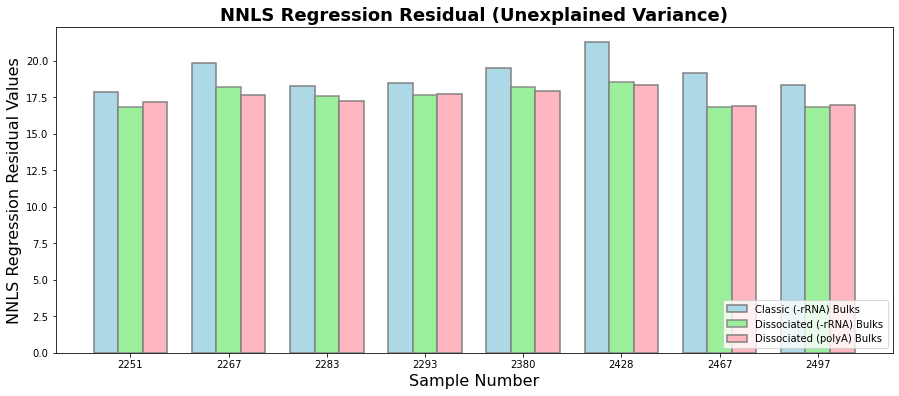

In [37]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


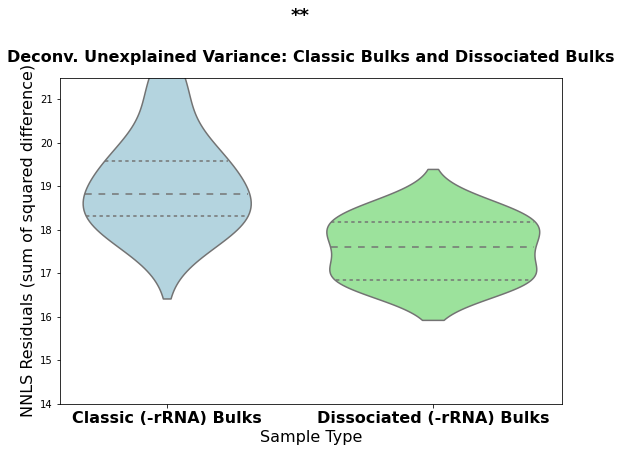

In [38]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


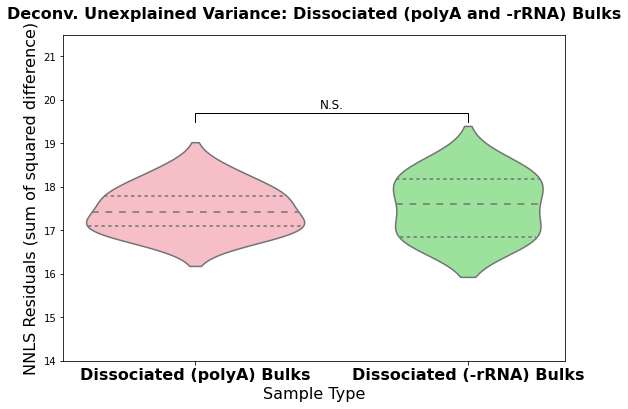

In [39]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', 
                palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, 
                fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, 
                    fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [40]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.469865  0.752005  0.183123  0.257027  0.460606  0.106827  0.081100   
2467  0.477565  0.597245  0.189465  0.117481  0.437946  0.077903  0.085195   
2380  0.375568  0.932745  0.213121  0.355153  0.537376  0.138774  0.072239   
2293  0.431607  0.725041  0.256761  0.060932  0.465546  0.092249  0.090168   
2283  0.466058  0.695016  0.183531  0.205074  0.467455  0.095494  0.078734   
2428  0.467865  0.574266  0.194231  0.118990  0.446485  0.070159  0.083871   
2251  0.407890  0.885611  0.226447  0.248281  0.466940  0.108502  0.088482   
2267  0.361174  0.882796  0.245627  0.271404  0.521084  0.141849  0.087176   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.833097  0.197166  0.072307  ...  0.955849  0.307310  0.276257   
2467  0.716921  0.144387  0.058552  ...  0.952541  0.291055  0.306849   
2380  0.883343  0.209254  0.235995  ...  0.989258  0.284471  0.303353   
2293  0.810446  0.163265  0.046420  ...  0.975322  0.266513  0.294915   
2283  0.753324  0.155923  0.089935  ...  0.969906  0.307444  0.314214   
2428  0.707523  0.158074  0.071944  ...  0.917592  0.282756  0.294468   
2251  0.983278  0.273915  0.086391  ...  0.915963  0.243888  0.217472   
2267  0.905707  0.207234  0.199442  ...  0.984243  0.254133  0.279801   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.214341  0.255461  0.229786  0.274451  0.166497  0.222716  0.752090  
2467  0.183983  0.272965  0.210377  0.285246  0.144788  0.249225  0.732845  
2380  0.205083  0.242979  0.269282  0.242649  0.188291  0.180558  0.899190  
2293  0.134006  0.255724  0.272299  0.191586  0.190331  0.236464  0.840040  
2283  0.203616  0.271910  0.217245  0.293432  0.157153  0.226980  0.784095  
2428  0.178388  0.266897  0.228337  0.282782  0.139731  0.250368  0.689666  
2251  0.185513  0.205763  0.276703  0.166348  0.189999  0.230251  0.707265  
2267  0.170241  0.230795  0.280158  0.195469  0.188836  0.195837  0.904052  

[8 rows x 4584 columns]

In [41]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.436145  0.812797  0.176263  0.303089  0.481313  0.107792  0.073931   
2467  0.386600  0.918887  0.225428  0.262586  0.497261  0.111194  0.078935   
2380  0.369911  0.886542  0.208822  0.331162  0.518447  0.130051  0.078838   
2293  0.395103  0.772029  0.223028  0.179296  0.483171  0.092976  0.078533   
2283  0.447709  0.743141  0.180115  0.243262  0.473592  0.097170  0.077116   
2428  0.420899  0.716328  0.192804  0.176927  0.460882  0.078837  0.082205   
2251  0.329682  0.889715  0.200745  0.269340  0.513606  0.081181  0.069185   
2267  0.394226  0.856018  0.266062  0.142552  0.498948  0.103776  0.097376   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.837312  0.204972  0.138164  ...  0.950970  0.296229  0.288829   
2467  0.930170  0.241697  0.157584  ...  0.950505  0.251883  0.265497   
2380  0.893165  0.220430  0.229531  ...  0.965628  0.261209  0.288317   
2293  0.808252  0.193097  0.186505  ...  0.949605  0.249776  0.295710   
2283  0.791944  0.180745  0.120753  ...  0.958325  0.294879  0.304560   
2428  0.798657  0.192227  0.132285  ...  0.931643  0.252168  0.295381   
2251  0.862531  0.239528  0.299573  ...  0.917756  0.206810  0.306462   
2267  0.893251  0.250293  0.127534  ...  0.956269  0.251701  0.251602   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.220475  0.247871  0.229295  0.269003  0.166306  0.210727  0.768226  
2467  0.186286  0.222471  0.272864  0.189118  0.192051  0.214080  0.792077  
2380  0.200860  0.229659  0.258659  0.226972  0.175395  0.197559  0.833141  
2293  0.167823  0.245279  0.259559  0.224365  0.168227  0.225191  0.784832  
2283  0.210271  0.258494  0.221626  0.279649  0.158619  0.224446  0.760668  
2428  0.187857  0.241404  0.223105  0.239578  0.151244  0.245667  0.703020  
2251  0.189646  0.212687  0.251137  0.198822  0.161205  0.225304  0.714168  
2267  0.129397  0.221366  0.339815  0.121360  0.213427  0.223280  0.823602  

[8 rows x 4584 columns]

In [42]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.434106  0.799208  0.170155  0.302037  0.477177  0.108237  0.069276   
2467  0.387216  0.940437  0.229563  0.277066  0.515544  0.121991  0.071626   
2380  0.359015  0.863414  0.214132  0.312940  0.515588  0.133013  0.080172   
2293  0.401265  0.736937  0.222665  0.174468  0.484676  0.099302  0.081098   
2283  0.454355  0.747988  0.181581  0.251020  0.484089  0.103166  0.074107   
2428  0.411593  0.680679  0.187214  0.150047  0.448214  0.073930  0.076509   
2251  0.319505  0.895524  0.196180  0.286898  0.527213  0.082826  0.063845   
2267  0.395111  0.847430  0.259475  0.139946  0.477477  0.106730  0.089262   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.794853  0.187559  0.138270  ...  0.939752  0.304805  0.290250   
2467  0.887135  0.213512  0.170060  ...  0.971719  0.277368  0.285202   
2380  0.870157  0.207244  0.232981  ...  0.959410  0.256282  0.286279   
2293  0.783740  0.173964  0.179921  ...  0.961373  0.258882  0.304236   
2283  0.769574  0.164311  0.123130  ...  0.976092  0.311943  0.318472   
2428  0.728363  0.165226  0.129824  ...  0.904883  0.254285  0.293931   
2251  0.830366  0.225751  0.336247  ...  0.923645  0.212498  0.324481   
2267  0.863107  0.225840  0.116716  ...  0.935313  0.254897  0.239080   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.216074  0.253233  0.222816  0.274011  0.163187  0.197395  0.804842  
2467  0.183777  0.240223  0.279275  0.208385  0.200615  0.190238  0.888311  
2380  0.188487  0.229569  0.257554  0.218724  0.172025  0.192061  0.862745  
2293  0.166860  0.253371  0.253554  0.238312  0.163994  0.222676  0.812539  
2283  0.211886  0.270635  0.224127  0.296625  0.162900  0.214521  0.807446  
2428  0.172573  0.245752  0.212497  0.235392  0.143901  0.230458  0.747538  
2251  0.191826  0.219742  0.249273  0.213552  0.158849  0.214597  0.747195  
2267  0.127834  0.223179  0.316544  0.130908  0.206421  0.209313  0.872416  

[8 rows x 4584 columns]

In [43]:
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.164780   0.000000  0.000000           0.020272  0.000000   
2467      0.182123   0.000000  0.000000           0.003659  0.000000   
2380      0.044662   0.063118  0.000000           0.291136  0.000000   
2293      0.102606   0.000000  0.002042           0.000000  0.006332   
2283      0.125126   0.000000  0.000000           0.073062  0.000000   
2428      0.209132   0.000000  0.000000           0.018860  0.000000   
2251      0.298698   0.000000  0.000000           0.013688  0.000000   
2267      0.065517   0.114738  0.000000           0.235323  0.000000   
2497      0.173158   0.000000  0.000000           0.126958  0.000000   
2467      0.205793   0.000000  0.000000           0.144049  0.000000   
2380      0.142911   0.080454  0.000000           0.266625  0.000000   
2293      0.178299   0.018984  0.000000           0.166792  0.000000   
2283      0.173278   0.000000  0.000000           0.107188  0.000000   
2428      0.284216   0.000000  0.000000           0.108819  0.000000   
2251      0.341954   0.000000  0.000000           0.343076  0.000000   
2267      0.166859   0.000000  0.064611           0.032358  0.038764   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.330105  0.010356     0.402456  0.004428  0.0     0.067602   
2467          0.592913  0.020108     0.092070  0.000000  0.0     0.109127   
2380          0.000000  0.000000     0.484513  0.000000  0.0     0.116571   
2293          0.399788  0.000000     0.000000  0.000000  0.0     0.476714   
2283          0.475436  0.000000     0.255632  0.000000  0.0     0.070744   
2428          0.549532  0.011441     0.077102  0.050441  0.0     0.083492   
2251          0.000000  0.000000     0.386487  0.020488  0.0     0.280639   
2267          0.000000  0.000000     0.337009  0.000000  0.0     0.247414   
2497          0.223984  0.000000     0.440199  0.000000  0.0     0.026305   
2467          0.026485  0.000000     0.351296  0.000000  0.0     0.272377   
2380          0.000000  0.000000     0.429751  0.000000  0.0     0.080260   
2293          0.226027  0.041311     0.144572  0.000000  0.0     0.224015   
2283          0.361073  0.000000     0.314306  0.000000  0.0     0.044155   
2428          0.344964  0.000000     0.151730  0.000000  0.0     0.110271   
2251          0.000000  0.000000     0.212045  0.000000  0.0     0.102925   
2267          0.006047  0.000000     0.178480  0.000000  0.0     0.508301   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.012517   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.009396  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.004581

In [44]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.469865  0.752005  0.183123  0.257027  0.460606  0.106827  0.081100   
2467  0.477565  0.597245  0.189465  0.117481  0.437946  0.077903  0.085195   
2380  0.375568  0.932745  0.213121  0.355153  0.537376  0.138774  0.072239   
2293  0.431607  0.725041  0.256761  0.060932  0.465546  0.092249  0.090168   
2283  0.466058  0.695016  0.183531  0.205074  0.467455  0.095494  0.078734   
2428  0.467865  0.574266  0.194231  0.118990  0.446485  0.070159  0.083871   
2251  0.407890  0.885611  0.226447  0.248281  0.466940  0.108502  0.088482   
2267  0.361174  0.882796  0.245627  0.271404  0.521084  0.141849  0.087176   
2497  0.436145  0.812797  0.176263  0.303089  0.481313  0.107792  0.073931   
2467  0.386600  0.918887  0.225428  0.262586  0.497261  0.111194  0.078935   
2380  0.369911  0.886542  0.208822  0.331162  0.518447  0.130051  0.078838   
2293  0.395103  0.772029  0.223028  0.179296  0.483171  0.092976  0.078533   
2283  0.447709  0.743141  0.180115  0.243262  0.473592  0.097170  0.077116   
2428  0.420899  0.716328  0.192804  0.176927  0.460882  0.078837  0.082205   
2251  0.329682  0.889715  0.200745  0.269340  0.513606  0.081181  0.069185   
2267  0.394226  0.856018  0.266062  0.142552  0.498948  0.103776  0.097376   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.833097  0.197166  0.072307  ...  0.955849  0.307310  0.276257   
2467  0.716921  0.144387  0.058552  ...  0.952541  0.291055  0.306849   
2380  0.883343  0.209254  0.235995  ...  0.989258  0.284471  0.303353   
2293  0.810446  0.163265  0.046420  ...  0.975322  0.266513  0.294915   
2283  0.753324  0.155923  0.089935  ...  0.969906  0.307444  0.314214   
2428  0.707523  0.158074  0.071944  ...  0.917592  0.282756  0.294468   
2251  0.983278  0.273915  0.086391  ...  0.915963  0.243888  0.217472   
2267  0.905707  0.207234  0.199442  ...  0.984243  0.254133  0.279801   
2497  0.837312  0.204972  0.138164  ...  0.950970  0.296229  0.288829   
2467  0.930170  0.241697  0.157584  ...  0.950505  0.251883  0.265497   
2380  0.893165  0.220430  0.229531  ...  0.965628  0.261209  0.288317   
2293  0.808252  0.193097  0.186505  ...  0.949605  0.249776  0.295710   
2283  0.791944  0.180745  0.120753  ...  0.958325  0.294879  0.304560   
2428  0.798657  0.192227  0.132285  ...  0.931643  0.252168  0.295381   
2251  0.862531  0.239528  0.299573  ...  0.917756  0.206810  0.306462   
2267  0.893251  0.250293  0.127534  ...  0.956269  0.251701  0.251602   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.214341  0.255461  0.229786  0.274451  0.166497  0.222716  0.752090  
2467  0.183983  0.272965  0.210377  0.285246  0.144788  0.249225  0.732845  
2380  0.205083  0.242979  0.269282  0.242649  0.188291  0.180558  0.899190  
2293  0.134006  0.255724  0.272299  0.191586  0.190331  0.236464  0.840040  
2283  0.203616  0.271910  0.217245  0.293432  0.157153  0.226980  0.784095  
2428  0.178388  0.266897  0.228337  0.282782  0.139731  0.250368  0.689666  
2251  0.185513  0.205763  0.276703  0.166348  0.189999  0.230251  0.707265  
2267  0.170241  0.230795  0.280158  0.195469  0.188836  0.195837  0.904052  
2497  0.220475  0.247871  0.229295  0.269003  0.166306  0.210727  0.768226  
2467  0.186286  0.222471  0.272864  0.189118  0.192051  0.214080  0.792077  
2380  0.200860  0.229659  0.258659  0.226972  0.175395  0.197559  0.833141  
2293  0.167823  0.245279  0.259559  0.224365  0.168227  0.225191  0.784832  
2283  0.210271  0.258494  0.221626  0.279649  0.158619  0.224446  0.760668  
2428  0.187857  0.241404  0.223105  0.239578  0.151244  0.245667  0.703020  
2251  0.189646  0.212687  0.251137  0.198822  0.161205  0.225304  0.714168  
2267  0.129397  0.221366  0.339815  0.121360  0.213427  0.223280  0.823602  

[16 rows x 4584 columns]

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [45]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.438989  0.247995  0.026607  0.078723 -0.219771 -0.029980  0.131603   
2467 -0.443410  0.402755  0.034942  0.152255 -0.111710  0.213219  0.057174   
2380 -0.369171  0.067255 -0.000914  0.392867 -0.245315 -0.077229  0.034747   
2293 -0.414233  0.274959  0.080161  0.017422 -0.140207 -0.041830  0.161927   
2283 -0.391202  0.304984  0.136104  0.029225 -0.221928 -0.015148  0.038789   
2428 -0.430928  0.425734  0.010274 -0.032504 -0.070810  0.108220 -0.011799   
2251 -0.386639  0.114389 -0.035718  0.147868 -0.227152 -0.029273  0.039020   
2267 -0.353193  0.117204  0.008888  0.025678 -0.229914 -0.048733  0.016581   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.166903  0.034520 -0.027480  ... -0.676362 -0.235952 -0.197122   
2467  0.283079  0.194618 -0.048337  ... -0.620559 -0.199760 -0.103190   
2380  0.116657  0.204793 -0.127245  ... -0.838816 -0.224691 -0.235632   
2293  0.189554  0.067028 -0.014737  ... -0.682687 -0.156136 -0.193396   
2283  0.246676  0.116303  0.009124  ... -0.614340 -0.216618 -0.098130   
2428  0.292477  0.841926 -0.053475  ... -0.749123 -0.182756 -0.194017   
2251  0.016722  0.127218 -0.002177  ... -0.704246 -0.164396 -0.130896   
2267  0.094293  0.074477 -0.086817  ... -0.804811 -0.201811 -0.156238   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.046009  0.045068 -0.180841  0.219339  0.324092  0.185764  0.247910  
2467  0.040104  0.048802 -0.138554 -0.004019  0.368188  0.528060 -0.041428  
2380 -0.017582  0.232171 -0.229796 -0.114266  0.333845  0.027679 -0.137714  
2293 -0.074048  0.028735 -0.159879 -0.061791  0.326463  0.302815 -0.090908  
2283  0.077343  0.158012 -0.127418  0.464110  0.842847  0.288777 -0.448741  
2428  0.227918  0.039860 -0.197256  0.154155  0.522882  0.569452 -0.436063  
2251 -0.090017  0.035862 -0.159171  0.100462  0.556125  0.242242  0.170034  
2267 -0.025099  0.234191 -0.191477 -0.043824  0.360397  0.063704  0.095948  

[8 rows x 4584 columns]

In [46]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.393395  0.187203  0.005586  0.158479 -0.248251  0.031308  0.045421   
2467 -0.357482  0.081113 -0.068330  0.131418 -0.248852  0.037995 -0.019618   
2380 -0.347478  0.113458 -0.012674  0.104085 -0.200014  0.238445 -0.018106   
2293 -0.381787  0.227971  0.072420  0.233776 -0.168582  0.013551  0.013847   
2283 -0.402854  0.256859  0.037373  0.073083 -0.221283  0.038575 -0.006882   
2428 -0.352625  0.283672 -0.000094  0.002569 -0.130889  0.587756 -0.046232   
2251 -0.311769  0.110285 -0.027767  0.189416 -0.227548  0.106352 -0.010126   
2267 -0.371722  0.143982 -0.075978  0.018086 -0.198979 -0.042969 -0.020289   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.162688 -0.034840 -0.025973  ... -0.619604 -0.233949 -0.210491   
2467  0.069830  0.063153 -0.054051  ... -0.685199 -0.173513 -0.122419   
2380  0.106835  0.030979 -0.084267  ... -0.737473 -0.205675 -0.197493   
2293  0.191748 -0.045235 -0.103003  ... -0.682176 -0.177371 -0.189182   
2283  0.208056 -0.017556 -0.000648  ... -0.640504 -0.224350 -0.153175   
2428  0.201343  0.305149 -0.050062  ... -0.721681 -0.210690 -0.231145   
2251  0.137469  0.022178 -0.003158  ... -0.705592 -0.166224 -0.209617   
2267  0.106749 -0.108567 -0.033449  ... -0.730514 -0.191612 -0.168051   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.096566  0.170948 -0.183724  0.243995  0.319133  0.147981  0.231774  
2467 -0.074125  0.019108 -0.180115  0.026937  0.515071  0.208684  0.207923  
2380 -0.005532  0.354135 -0.208049 -0.069944  0.428917  0.138929  0.166859  
2293  0.044954  0.461021 -0.133889 -0.006039  0.239297  0.154313  0.215168  
2283  0.072729  0.573683 -0.144015  0.192803  0.755006  0.358963 -0.049185  
2428 -0.014234  0.462263 -0.195942  0.104364  0.348701  0.500212 -0.101765  
2251 -0.049416  0.386859 -0.176684  0.069322  0.279918  0.218618  0.158841  
2267 -0.111442  0.272278 -0.214609 -0.033500  0.256995  0.053228  0.176398  

[8 rows x 4584 columns]

In [47]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.411210  0.200792 -0.000887  0.191937 -0.267482 -0.048237  0.047775   
2467 -0.358637  0.059563 -0.060061  0.162455 -0.271147 -0.021472 -0.021367   
2380 -0.348484  0.136586 -0.010224  0.180652 -0.220067 -0.060561 -0.032208   
2293 -0.394407  0.263063  0.069853  0.292094 -0.234960 -0.052953  0.016329   
2283 -0.437841  0.252012  0.028922  0.097448 -0.235751 -0.049861 -0.000735   
2428 -0.383310  0.319321  0.008698  0.000336 -0.179641  0.080822 -0.050065   
2251 -0.310220  0.104476 -0.051837  0.189856 -0.280733 -0.014284 -0.018769   
2267 -0.383054  0.152570 -0.064112  0.027632 -0.229692 -0.070384 -0.013249   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497 -0.073805 -0.015723 -0.052503  ... -0.639907 -0.246846 -0.216271   
2467  0.112865  0.028127 -0.092405  ... -0.626015 -0.187690 -0.145068   
2380  0.129843  0.047546 -0.125381  ... -0.722511 -0.198549 -0.204817   
2293  0.216260 -0.056910 -0.115364  ... -0.670510 -0.201419 -0.170391   
2283  0.112779  0.001248 -0.013385  ... -0.639958 -0.242124 -0.141207   
2428  0.271637  0.150946 -0.055323  ... -0.661833 -0.194500 -0.247942   
2251  0.169634  0.016002 -0.102260  ... -0.715825 -0.169279 -0.222006   
2267  0.136893 -0.070494 -0.048567  ... -0.693819 -0.189544 -0.153980   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.136050  0.136989 -0.159945  0.205530  0.408015  0.110611  0.195158  
2467 -0.116765 -0.000161 -0.096963  0.042714  0.775793  0.182862  0.111689  
2380 -0.079998  0.388373 -0.150588 -0.099830  0.445917  0.062602  0.137255  
2293  0.009077  0.400716 -0.064611 -0.015790  0.275847  0.073626  0.187461  
2283  0.031017  0.457447 -0.104139  0.134622  0.837100  0.260625  0.192554  
2428 -0.066109  0.467991 -0.179155  0.051577  0.329322  0.464661  0.238919  
2251 -0.090702  0.352395 -0.147305  0.022462  0.276712  0.145500  0.252805  
2267 -0.117175  0.238491 -0.116114 -0.045983  0.312390  0.009815  0.127584  

[8 rows x 4584 columns]

In [48]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.438989  0.247995  0.026607  0.078723 -0.219771 -0.029980  0.131603   
2467 -0.443410  0.402755  0.034942  0.152255 -0.111710  0.213219  0.057174   
2380 -0.369171  0.067255 -0.000914  0.392867 -0.245315 -0.077229  0.034747   
2293 -0.414233  0.274959  0.080161  0.017422 -0.140207 -0.041830  0.161927   
2283 -0.391202  0.304984  0.136104  0.029225 -0.221928 -0.015148  0.038789   
2428 -0.430928  0.425734  0.010274 -0.032504 -0.070810  0.108220 -0.011799   
2251 -0.386639  0.114389 -0.035718  0.147868 -0.227152 -0.029273  0.039020   
2267 -0.353193  0.117204  0.008888  0.025678 -0.229914 -0.048733  0.016581   
2497 -0.393395  0.187203  0.005586  0.158479 -0.248251  0.031308  0.045421   
2467 -0.357482  0.081113 -0.068330  0.131418 -0.248852  0.037995 -0.019618   
2380 -0.347478  0.113458 -0.012674  0.104085 -0.200014  0.238445 -0.018106   
2293 -0.381787  0.227971  0.072420  0.233776 -0.168582  0.013551  0.013847   
2283 -0.402854  0.256859  0.037373  0.073083 -0.221283  0.038575 -0.006882   
2428 -0.352625  0.283672 -0.000094  0.002569 -0.130889  0.587756 -0.046232   
2251 -0.311769  0.110285 -0.027767  0.189416 -0.227548  0.106352 -0.010126   
2267 -0.371722  0.143982 -0.075978  0.018086 -0.198979 -0.042969 -0.020289   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.166903  0.034520 -0.027480  ... -0.676362 -0.235952 -0.197122   
2467  0.283079  0.194618 -0.048337  ... -0.620559 -0.199760 -0.103190   
2380  0.116657  0.204793 -0.127245  ... -0.838816 -0.224691 -0.235632   
2293  0.189554  0.067028 -0.014737  ... -0.682687 -0.156136 -0.193396   
2283  0.246676  0.116303  0.009124  ... -0.614340 -0.216618 -0.098130   
2428  0.292477  0.841926 -0.053475  ... -0.749123 -0.182756 -0.194017   
2251  0.016722  0.127218 -0.002177  ... -0.704246 -0.164396 -0.130896   
2267  0.094293  0.074477 -0.086817  ... -0.804811 -0.201811 -0.156238   
2497  0.162688 -0.034840 -0.025973  ... -0.619604 -0.233949 -0.210491   
2467  0.069830  0.063153 -0.054051  ... -0.685199 -0.173513 -0.122419   
2380  0.106835  0.030979 -0.084267  ... -0.737473 -0.205675 -0.197493   
2293  0.191748 -0.045235 -0.103003  ... -0.682176 -0.177371 -0.189182   
2283  0.208056 -0.017556 -0.000648  ... -0.640504 -0.224350 -0.153175   
2428  0.201343  0.305149 -0.050062  ... -0.721681 -0.210690 -0.231145   
2251  0.137469  0.022178 -0.003158  ... -0.705592 -0.166224 -0.209617   
2267  0.106749 -0.108567 -0.033449  ... -0.730514 -0.191612 -0.168051   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.046009  0.045068 -0.180841  0.219339  0.324092  0.185764  0.247910  
2467  0.040104  0.048802 -0.138554 -0.004019  0.368188  0.528060 -0.041428  
2380 -0.017582  0.232171 -0.229796 -0.114266  0.333845  0.027679 -0.137714  
2293 -0.074048  0.028735 -0.159879 -0.061791  0.326463  0.302815 -0.090908  
2283  0.077343  0.158012 -0.127418  0.464110  0.842847  0.288777 -0.448741  
2428  0.227918  0.039860 -0.197256  0.154155  0.522882  0.569452 -0.436063  
2251 -0.090017  0.035862 -0.159171  0.100462  0.556125  0.242242  0.170034  
2267 -0.025099  0.234191 -0.191477 -0.043824  0.360397  0.063704  0.095948  
2497 -0.096566  0.170948 -0.183724  0.243995  0.319133  0.147981  0.231774  
2467 -0.074125  0.019108 -0.180115  0.026937  0.515071  0.208684  0.207923  
2380 -0.005532  0.354135 -0.208049 -0.069944  0.428917  0.138929  0.166859  
2293  0.044954  0.461021 -0.133889 -0.006039  0.239297  0.154313  0.215168  
2283  0.072729  0.573683 -0.144015  0.192803  0.755006  0.358963 -0.049185  
2428 -0.014234  0.462263 -0.195942  0.104364  0.348701  0.500212 -0.101765  
2251 -0.049416  0.386859 -0.176684  0.069322  0.279918  0.218618  0.158841  
2267 -0.111442  0.272278 -0.214609 -0.033500  0.256995  0.053228  0.176398  

[16 rows x 4584 columns]

## Comparing Residuals

In [49]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


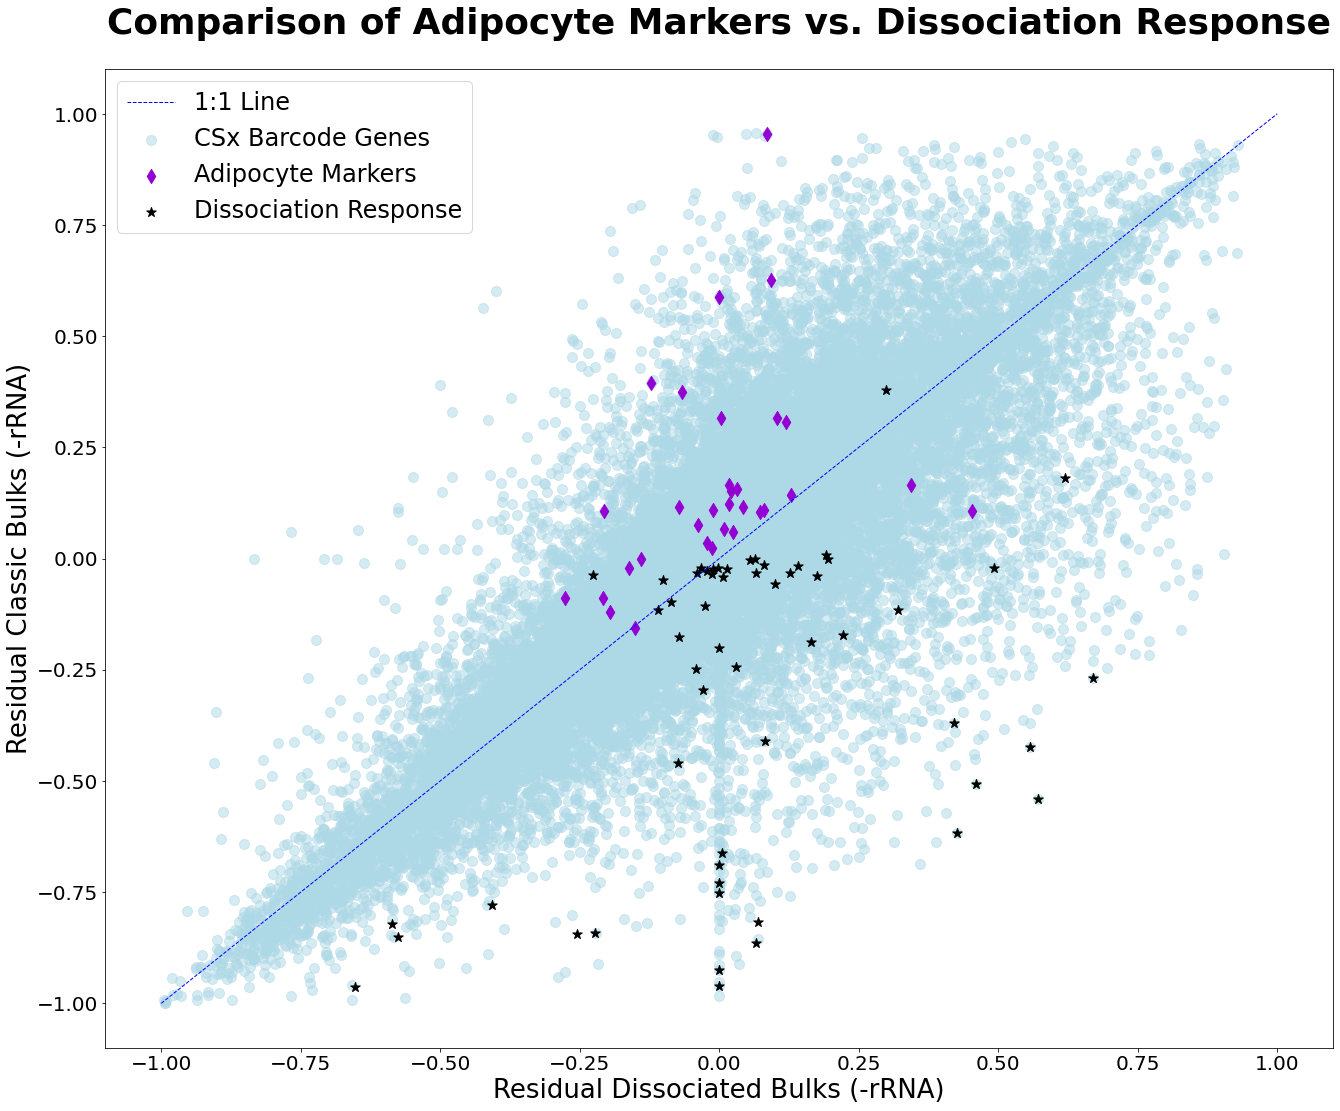

In [50]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(22, 18))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', s=100,
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', s=100,
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*',  s=100,
                    label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Comparison of Adipocyte Markers vs. Dissociation Response', 
                fontsize=36, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=24)

# Show the plot
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


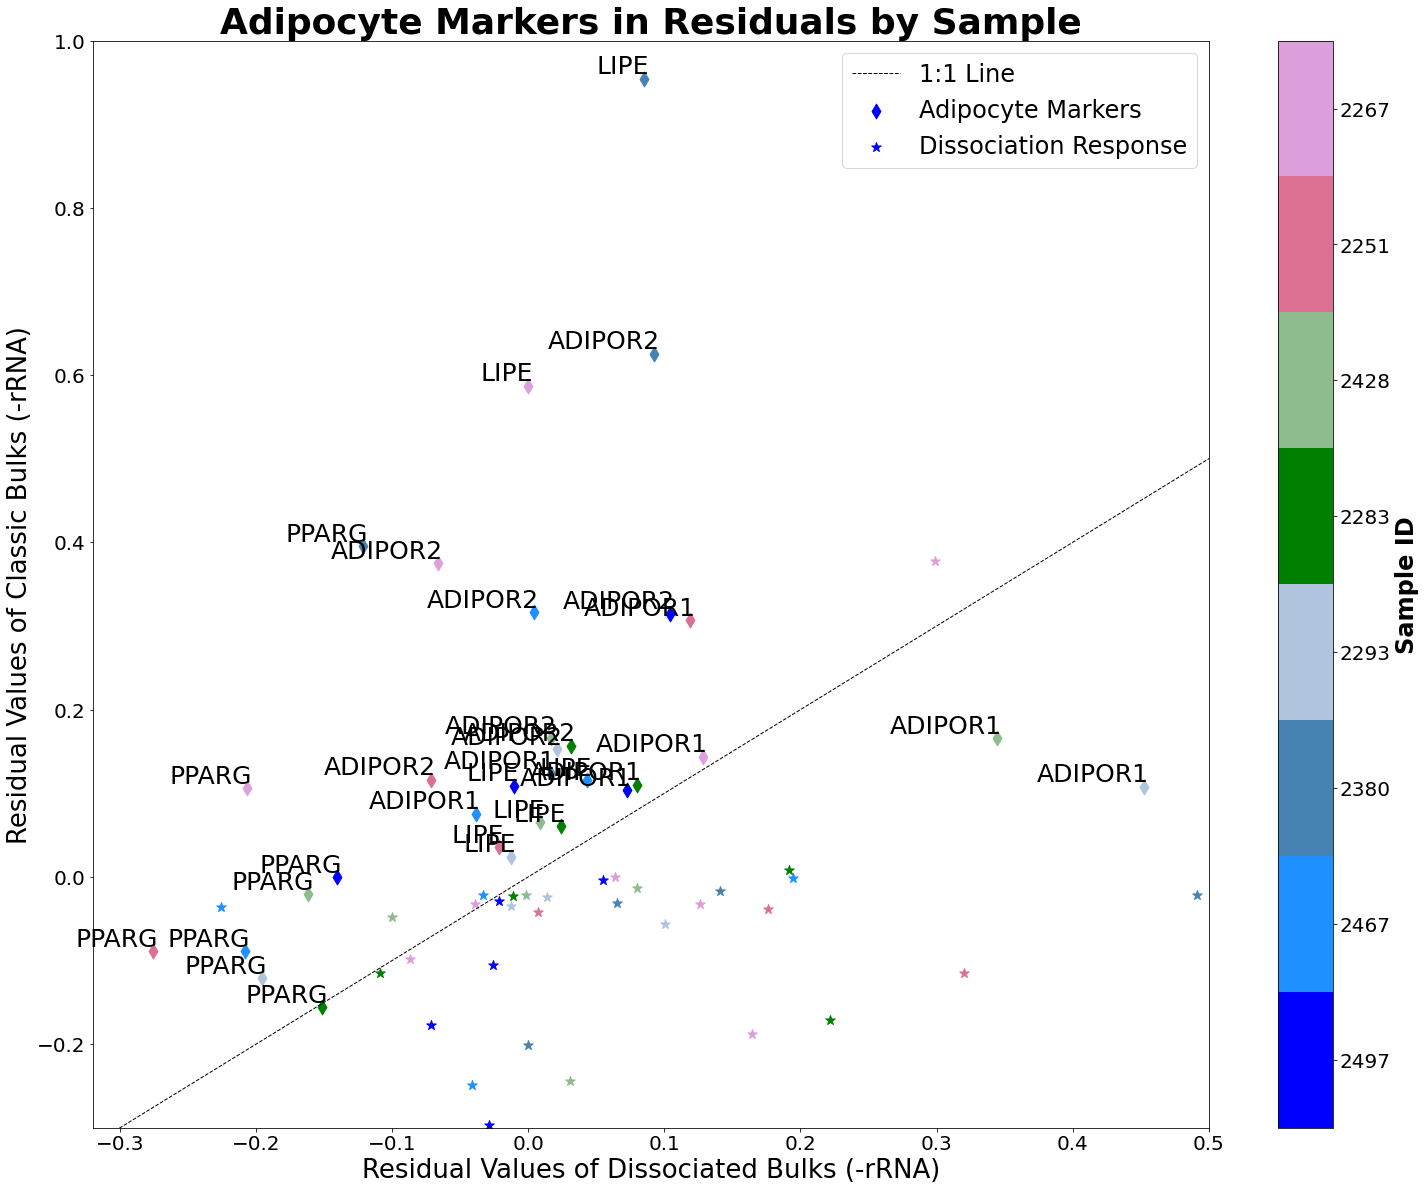

In [51]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 110

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(25, 20))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=25)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "",s=100)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample', fontsize=36, fontname='Arial', fontweight='bold')
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(24)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)),label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=24)
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Set colorbar tick font size
colorbar.ax.tick_params(labelsize=20)
# Add legend
plt.legend(fontsize=24)
# Show the plot
plt.show()


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


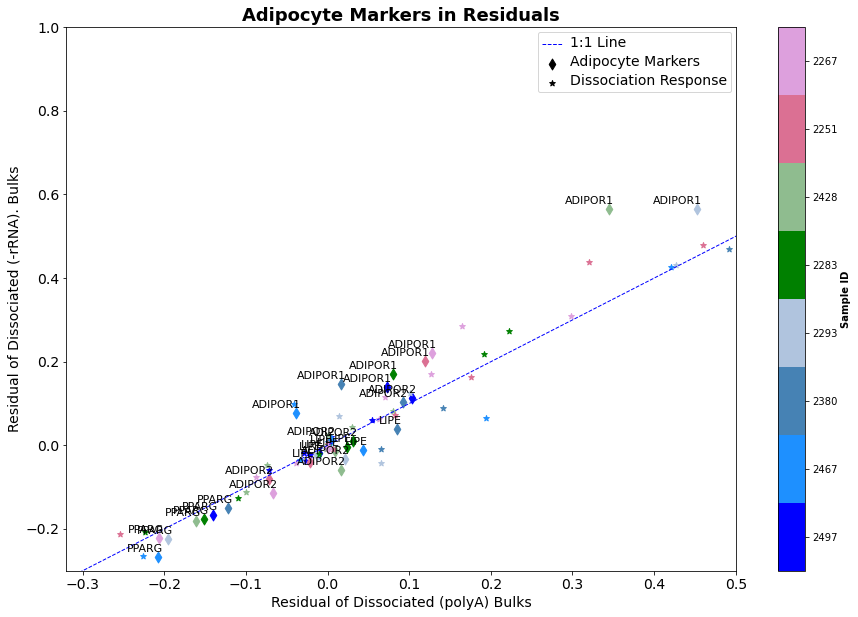

In [52]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_disspolyabulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual of Dissociated (-rRNA). Bulks', fontsize=14, fontname='Arial')
plt.xlabel('Residual of Dissociated (polyA) Bulks', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [53]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

2497        2467     2380     2293     2283      2428     2251     2267
0      TTN    TMEM132C       PC    GABRE      TTN      ACPP    ITGB4     GPAM
1    STAB1  AC136475.3     LIPE   NUP210  TMEM63A     GABRE     TEP1      TTN
2    F13A1       GABRE     GPAM     HID1  PLEKHG5     CLCN5    ABCC5    PTPRF
3    PLCG1  MIRLET7BHG    MARC1     LY75     DTX4     ITGA9   NBEAL2    ITPR3
4   NBEAL2     TMEM63A      TTN    PTPRS    F13A1  B4GALNT3   ATP8B2   NBEAL2
5  RAPGEF3        LY75   PLXNA4     NEO1    WDR91    MPPED2      TTN  SIGLEC1
6    CD163     PLEKHA6   RETSAT  NADSYN1      SRC      DNM1    OBSCN   HEATR1
7    KMT2D      TBC1D2  TNFSF14   NBEAL2    PLCG1   TSNARE1    PTPRF    PTPRS
8     MYRF       OBSCN    PTPRF    KMT2D    ABCC5     CMYA5    KMT2D    KMT2D
9      CGN       CIITA      PPL    LAMA4   CEP250   TMEM63A  SIGLEC1   PLXNA4

In [54]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

2497     2467     2380    2293     2283     2428     2251      2267
0     STAB1   CELSR1      PPL   TUFT1  TFCP2L1    GABRE      TTN       HK3
1    NBEAL2    OBSCN    OBSCN   OBSCN  PLEKHG5  TFCP2L1    ITGA3    NBEAL2
2      MYRF    ABCC5  TNFSF14   PLCG1   SNHG22  NECTIN4   NBEAL2    AMOTL2
3     PLCG1  RAPGEF3    MEGF6  CELSR1     LDB1    OBSCN    PTPRF  ARHGEF17
4    SEC24C   SEMA3B    PTPRF  NUP210    STAB1    PLCG1    PLCG1      PSD4
5    KLHL21   NBEAL2      TTN    YOD1    OBSCN     PSD4    KMT2D     THSD4
6   RAPGEF3     TEP1    ITGA3    PSD4   SEMA7A    TUFT1     H6PD     KMT2D
7     ITGA3    PLCG1   SEMA3B  NBEAL2   CELSR1   CELSR1   AMOTL2        CP
8  MAPK8IP3    ITGA3  SLC12A7   KMT2D    PLCG1    KMT2D  FAM110C    CHI3L1
9      FLT1  SIGLEC1    KMT2D   LAMB3  TMEM63A  PLEKHG3   SH3TC1       TTN

## Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

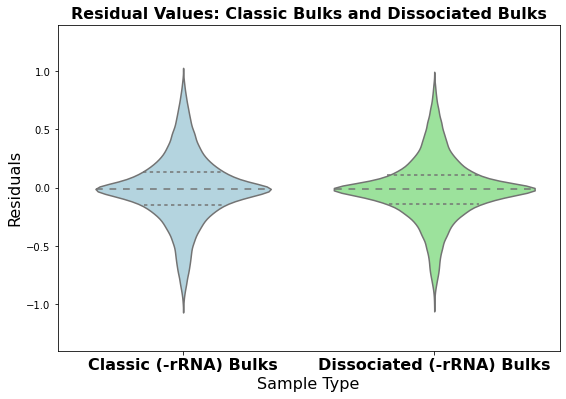

In [55]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

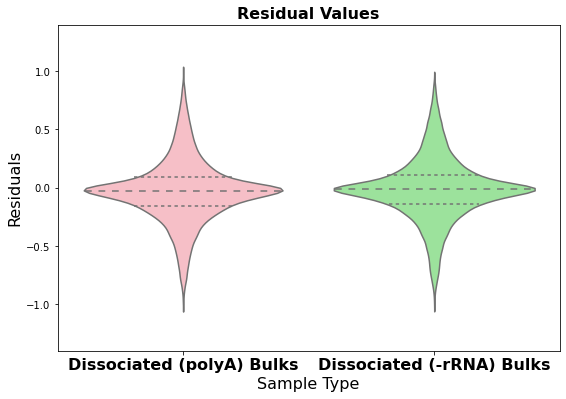

In [56]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

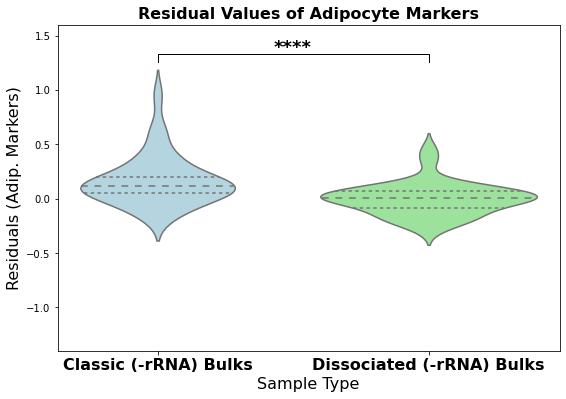

In [57]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

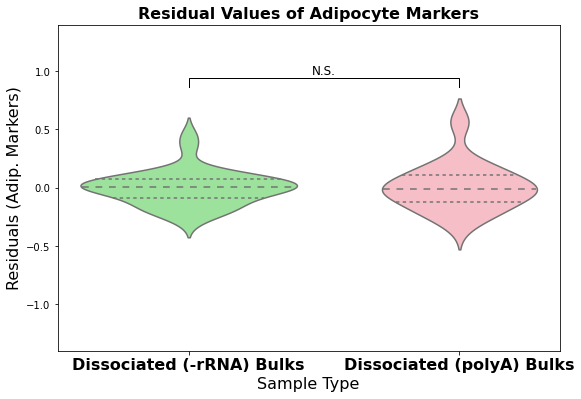

In [58]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

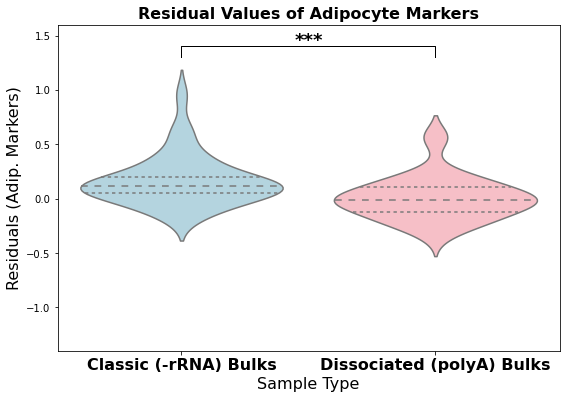

In [59]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

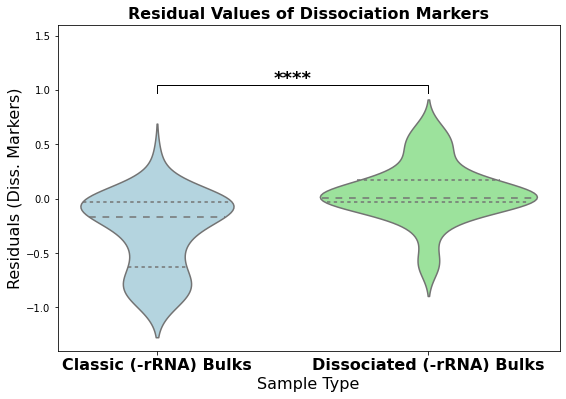

In [60]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


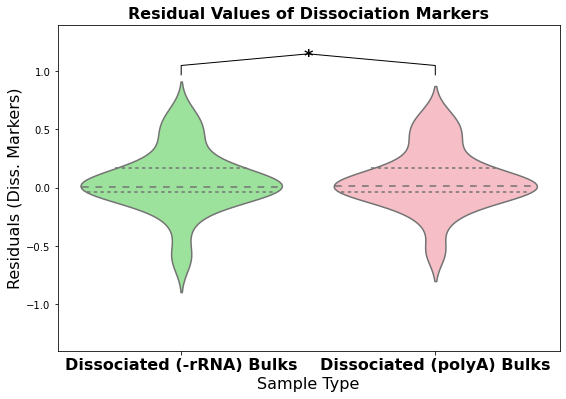

In [61]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

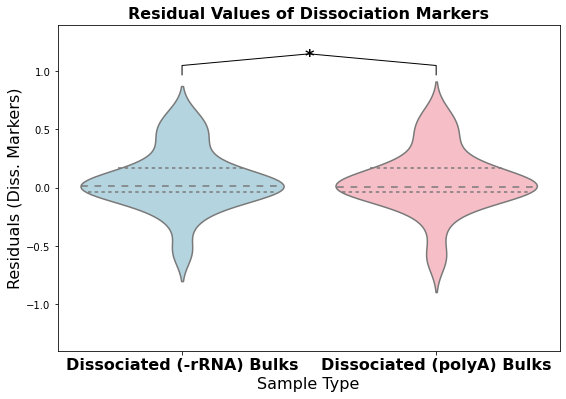

In [62]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


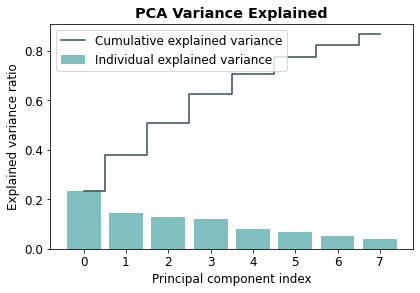

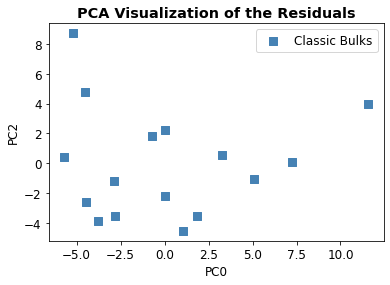

Component_0 Component_1 Component_2 Component_3 Component_4 Component_5  \
0          VTCN1     FAM107A        GPAM       F13A1      KIF26B       LAMA3   
1          PELI2      MFSD2A        SAA1         PPL       INHBA        NAV2   
2        ZNF780B    ANKRD33B      PLXNA4       DAPK1       UNC5B       NRXN3   
3        TMEM63A        IRS2      CLSTN2      KCNMA1      PDLIM3  AC136475.3   
4     MIRLET7BHG     TFCP2L1        ACO1     PLEKHG5     BHLHE41      RASSF8   
...          ...         ...         ...         ...         ...         ...   
4579       CXCL8      BTN3A2       CLDN4       IGHG1     FAM110C       PELI2   
4580        RND3       BIRC3        PLK2      FBXO32       MECOM      PGRMC1   
4581       CLDN1      BTN3A1         BGN        IGKC        CCL2       SESN3   
4582     ZC3H12A         EHF  AC245014.3      IFITM1         ADM      NUP210   
4583     ALDH1A3        LY75       SMAD7      CHI3L1       THSD4       PTGDS   

     Component_6 Component_7  
0          CLDN1        EYA2  
1          MYH11      RNF152  
2          MERTK        CDH6  
3         KCNMA1        ESR1  
4          IGLC3      SLC7A2  
...          ...         ...  
4579        DSG2      SPINT2  
4580      TUBA1B       RHPN2  
4581       STMN1         CGN  
4582        CD36        ASS1  
4583       ERAP2       KRT19  

[4584 rows x 8 columns]

In [63]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [64]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

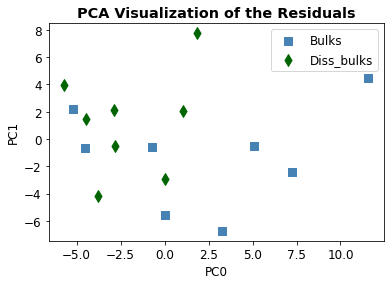

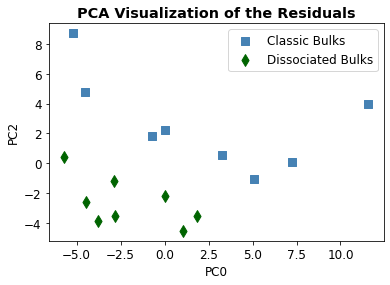

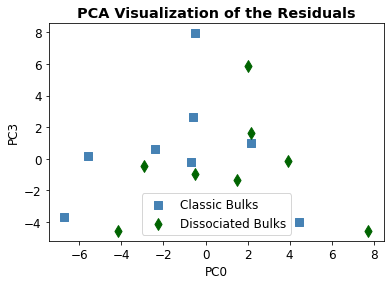

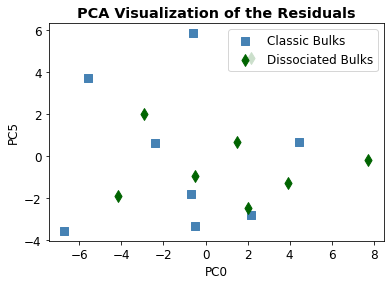

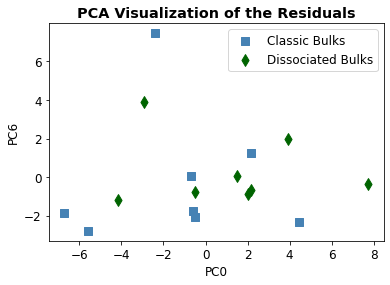

In [65]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


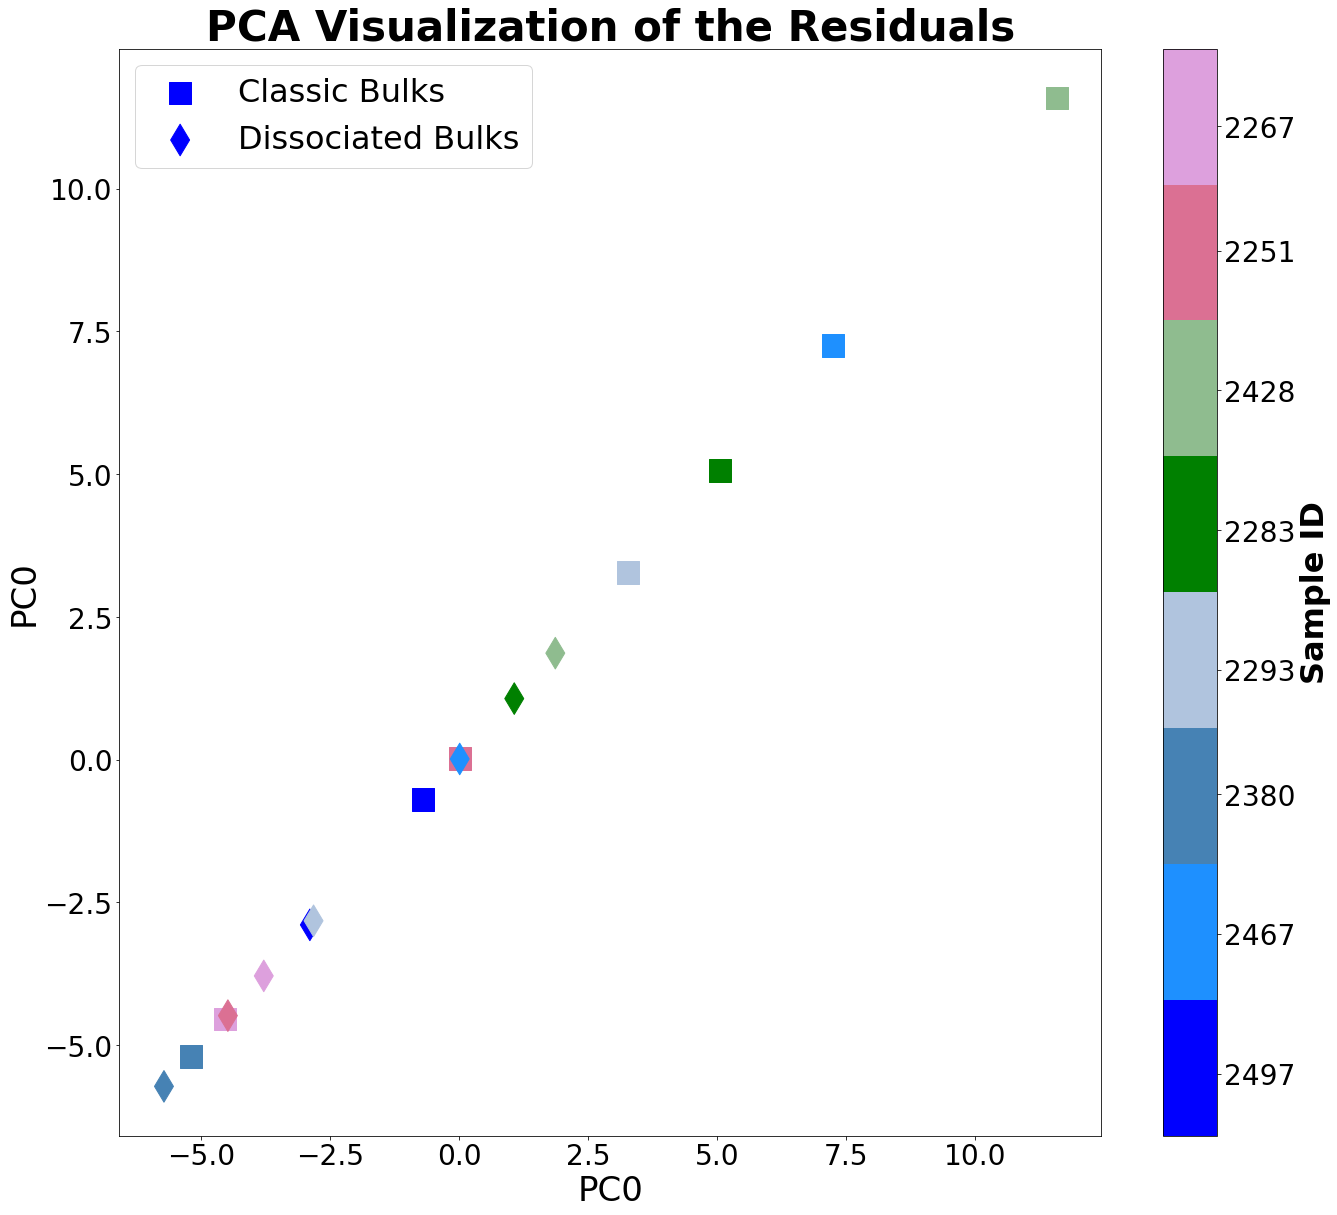

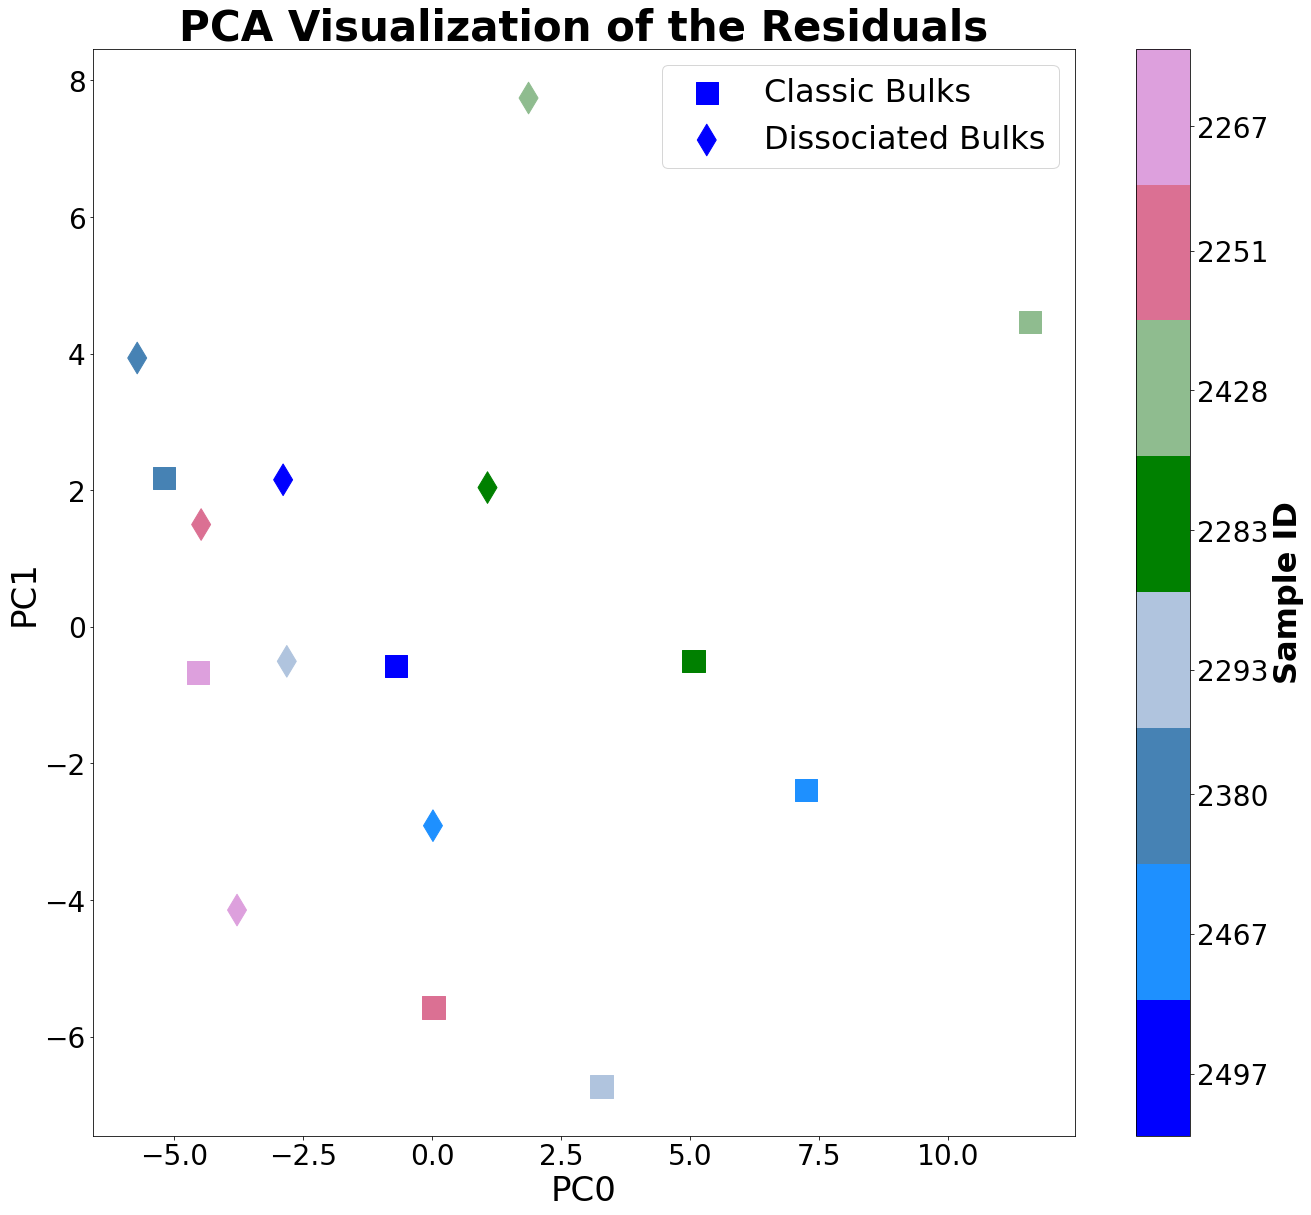

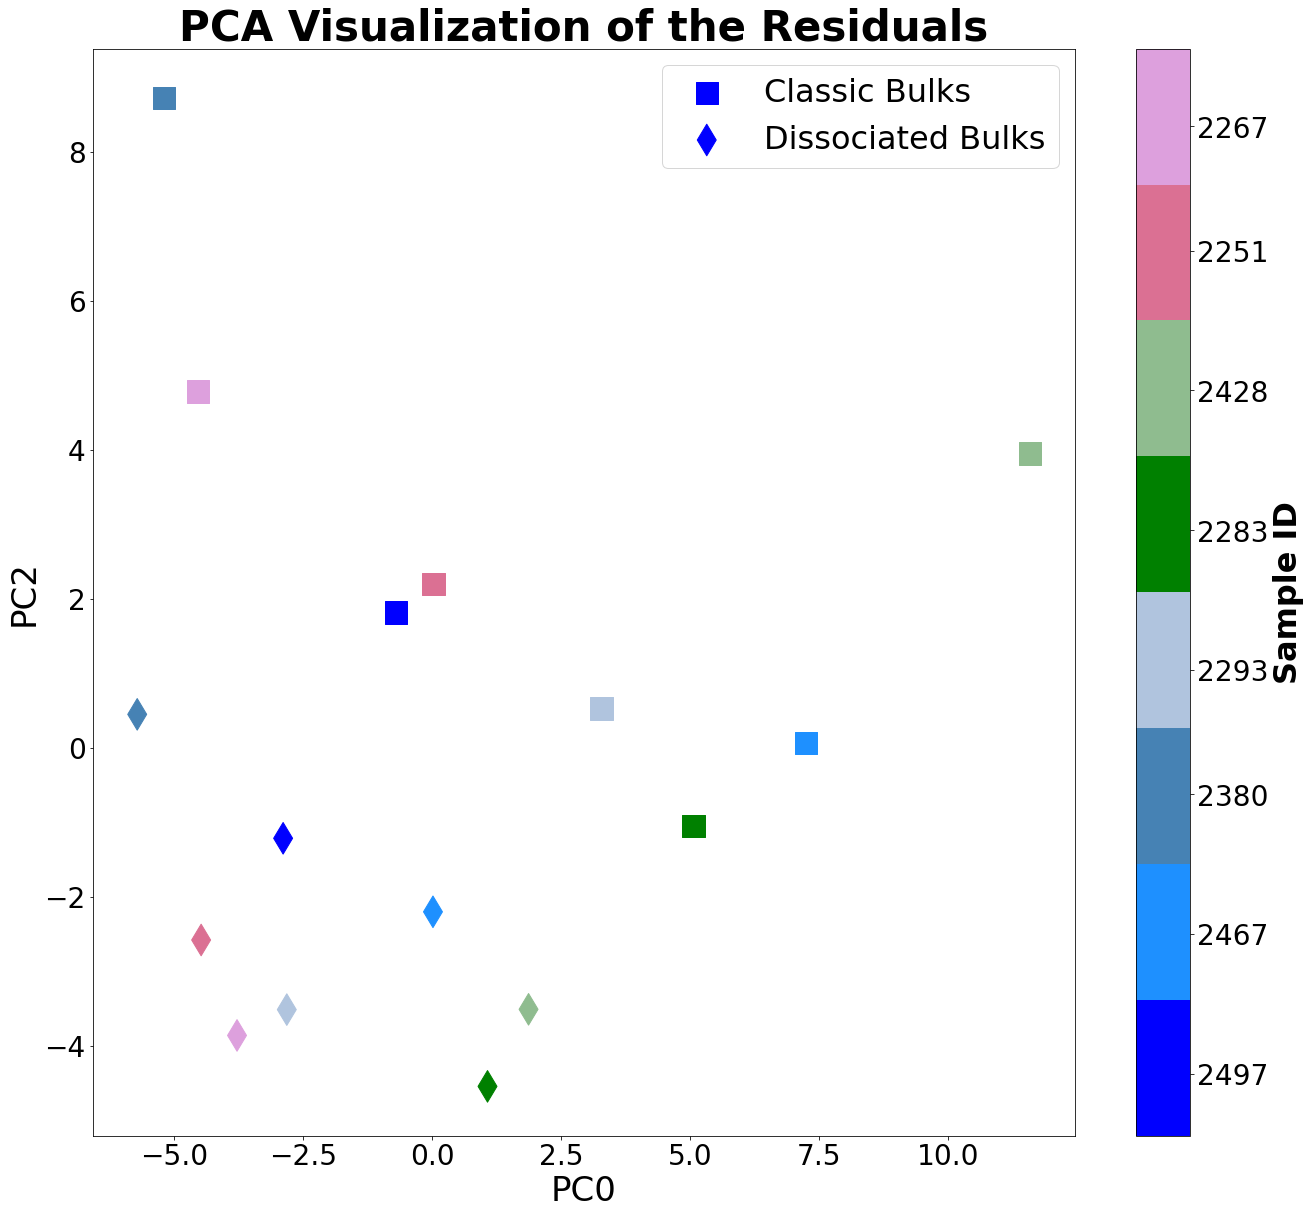

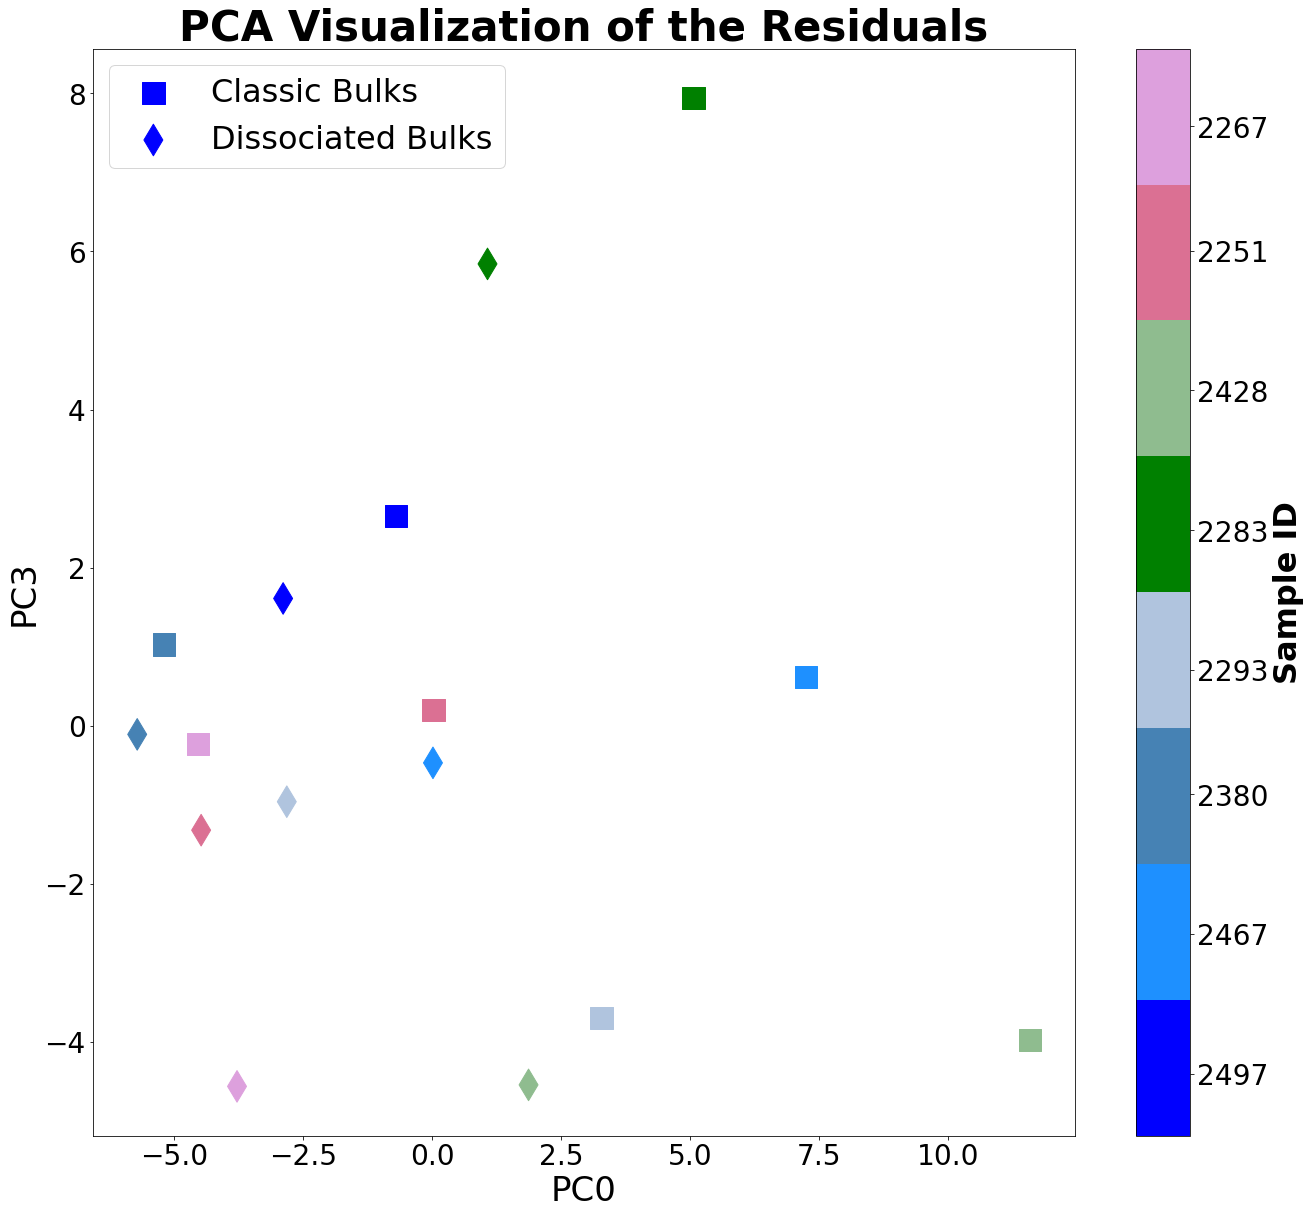

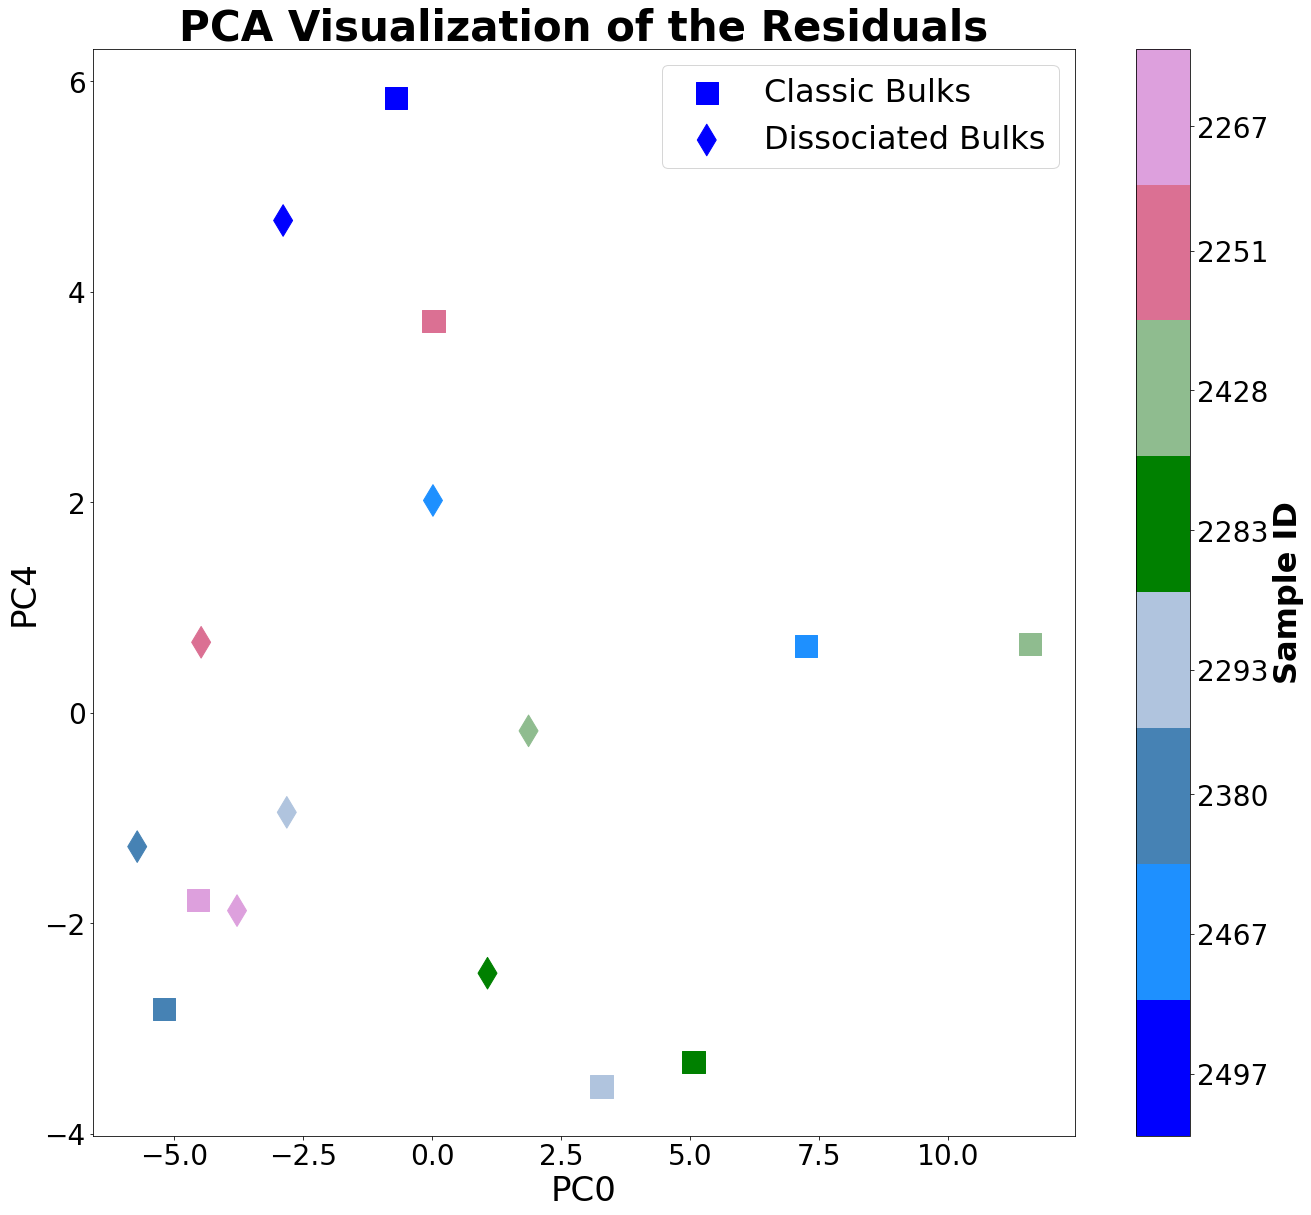

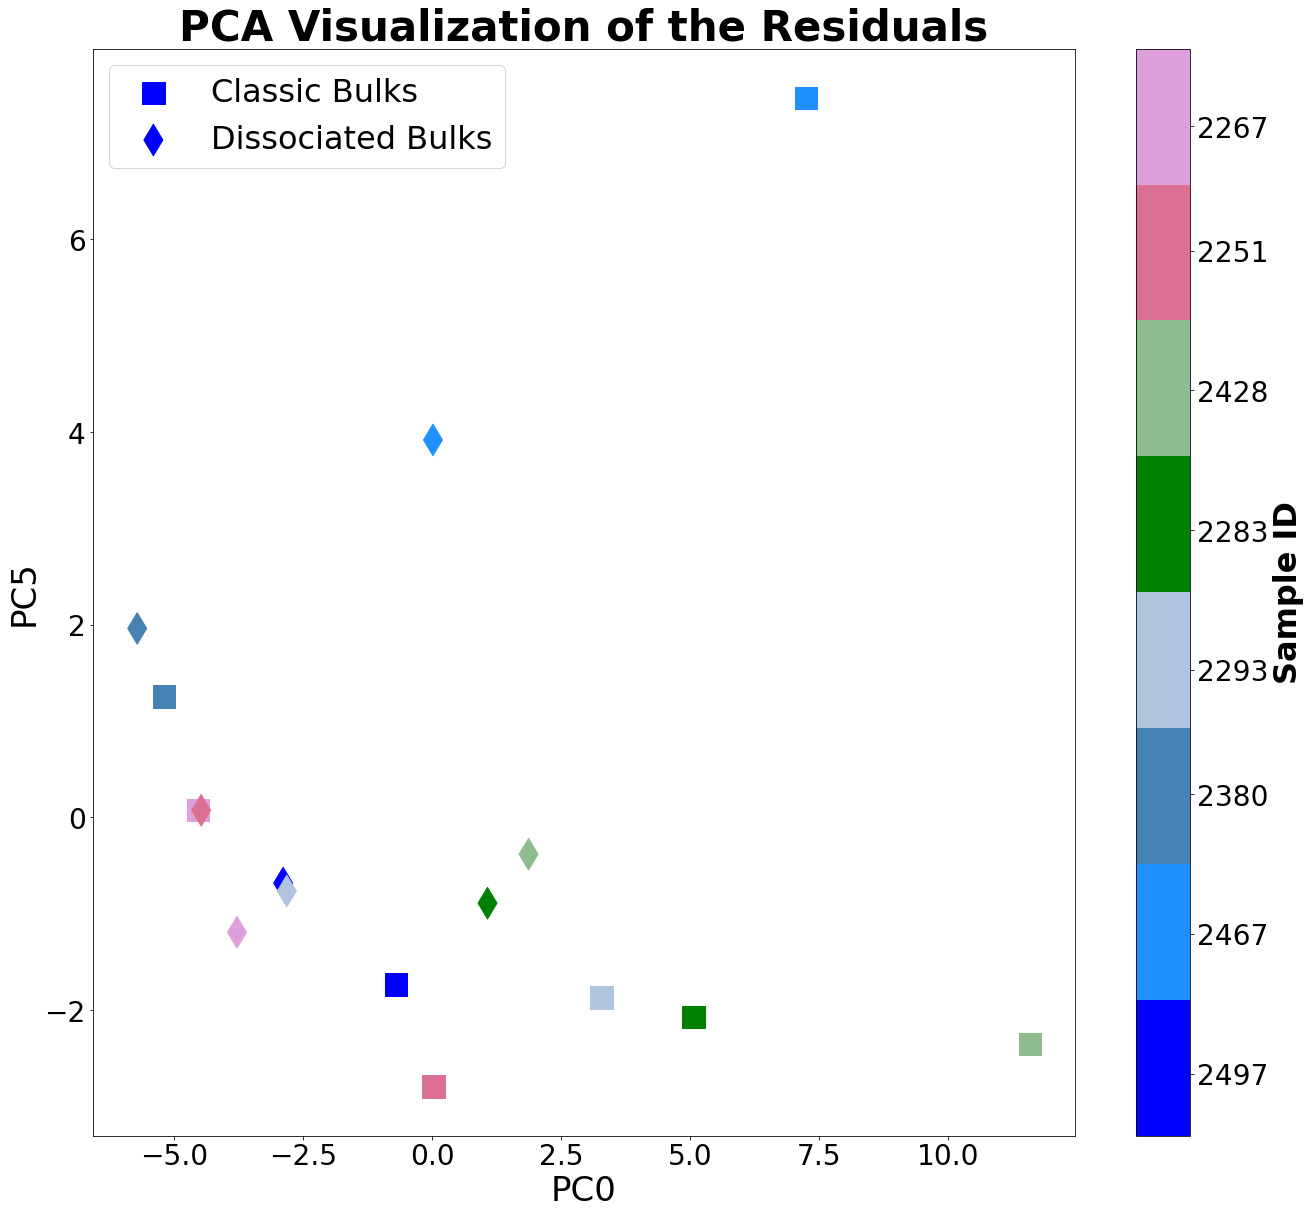

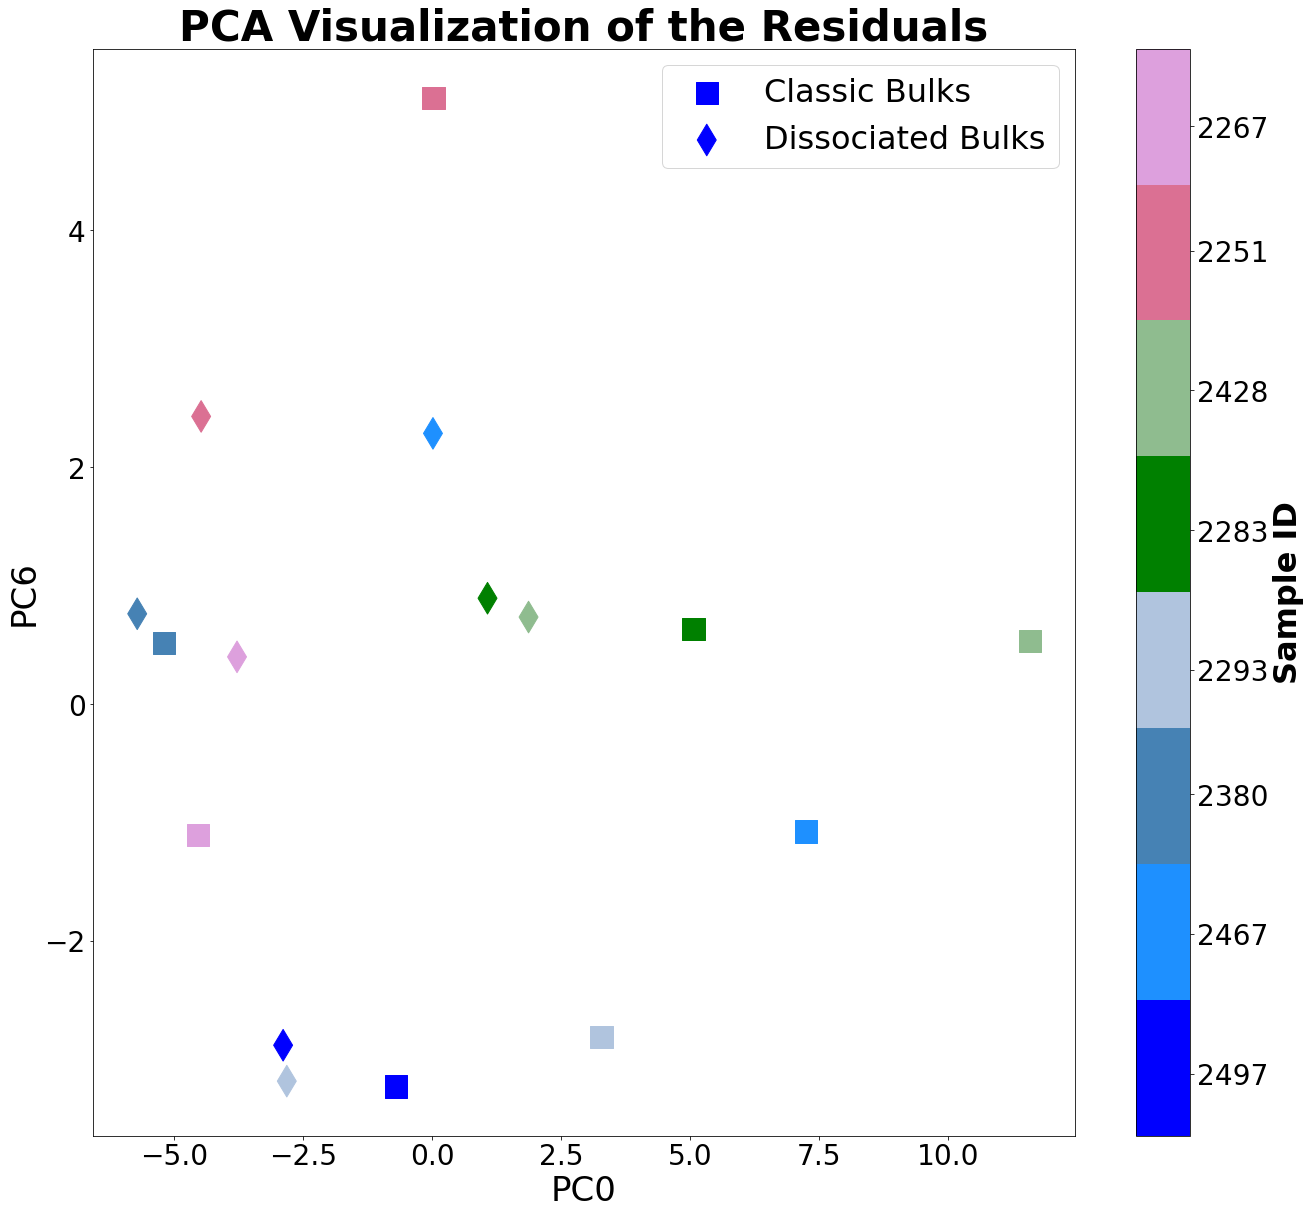

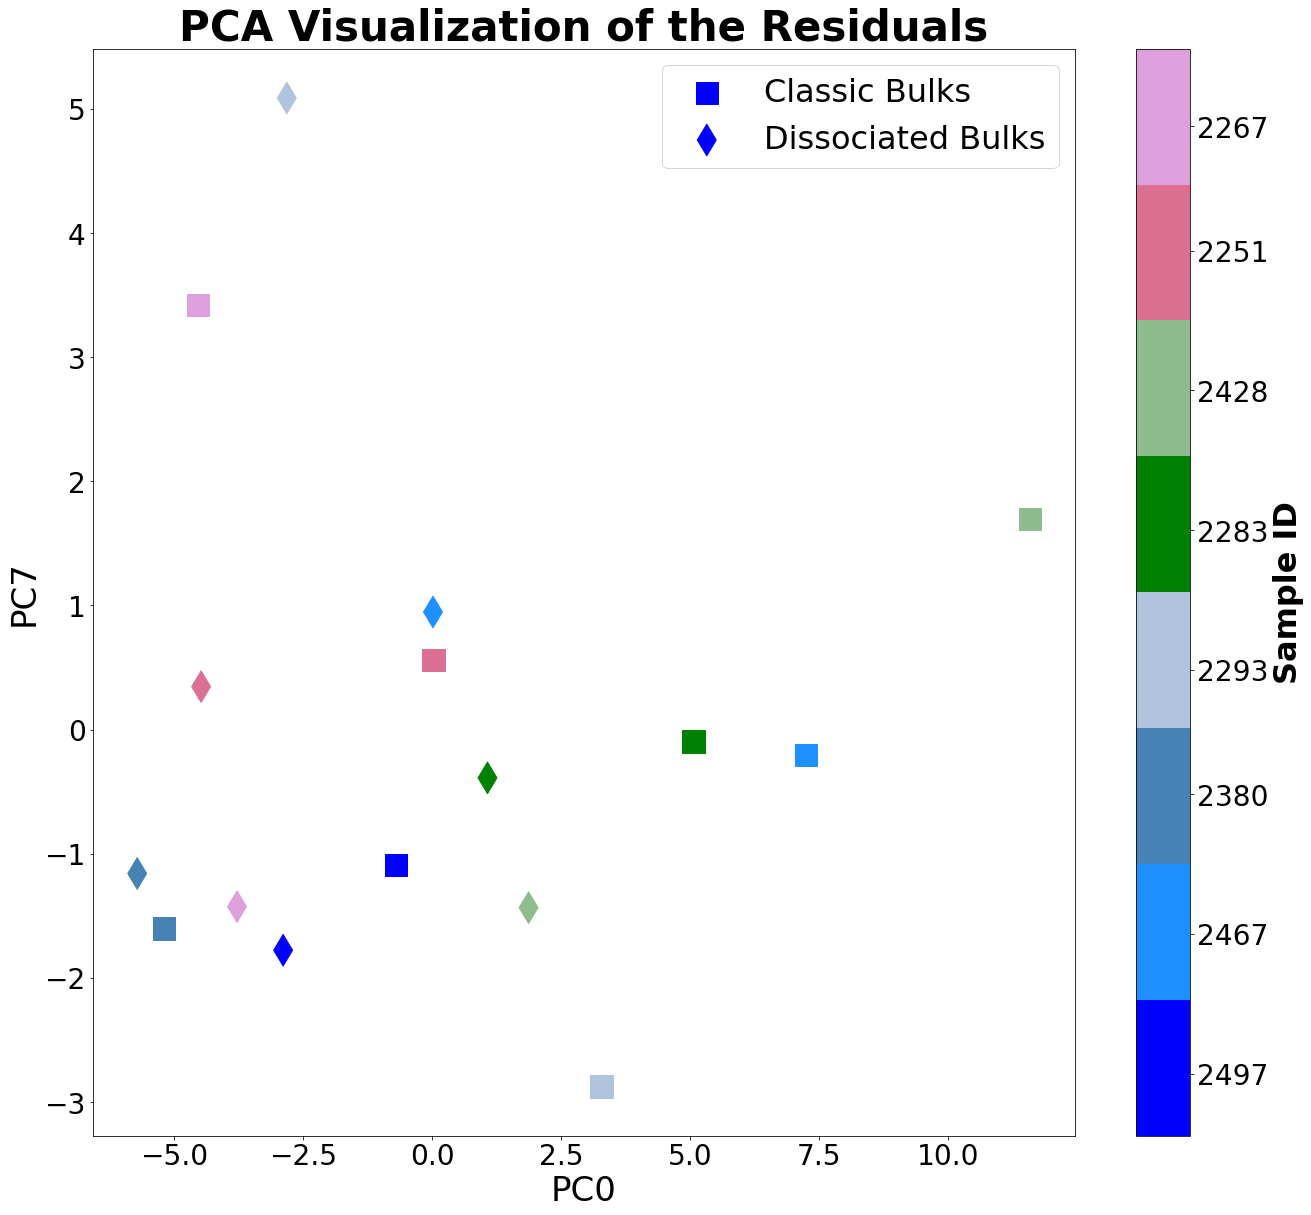

In [66]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (22,20))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 500

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=32, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids )
    cbar.ax.tick_params(labelsize=28)
    # Change the color of the little marker in the legend
    legend = plt.legend(fontsize=32)

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=42, fontname='Arial')
    plt.xlabel("PC0", fontsize=34, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=34, fontname='Arial')
    plt.show()

In [67]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.843652  0.086501
1        1.0    -1.309417  0.211476
2        2.0     4.204563  0.000883
3        3.0     0.636347  0.534817
4        4.0    -0.104008  0.918639
5        5.0    -0.374556  0.713603
6        6.0    -0.301520  0.767450
7        7.0    -0.046130  0.963858
Components with significantly different means:
   Component  T-Statistic   P-Value
2        2.0     4.204563  0.000883


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


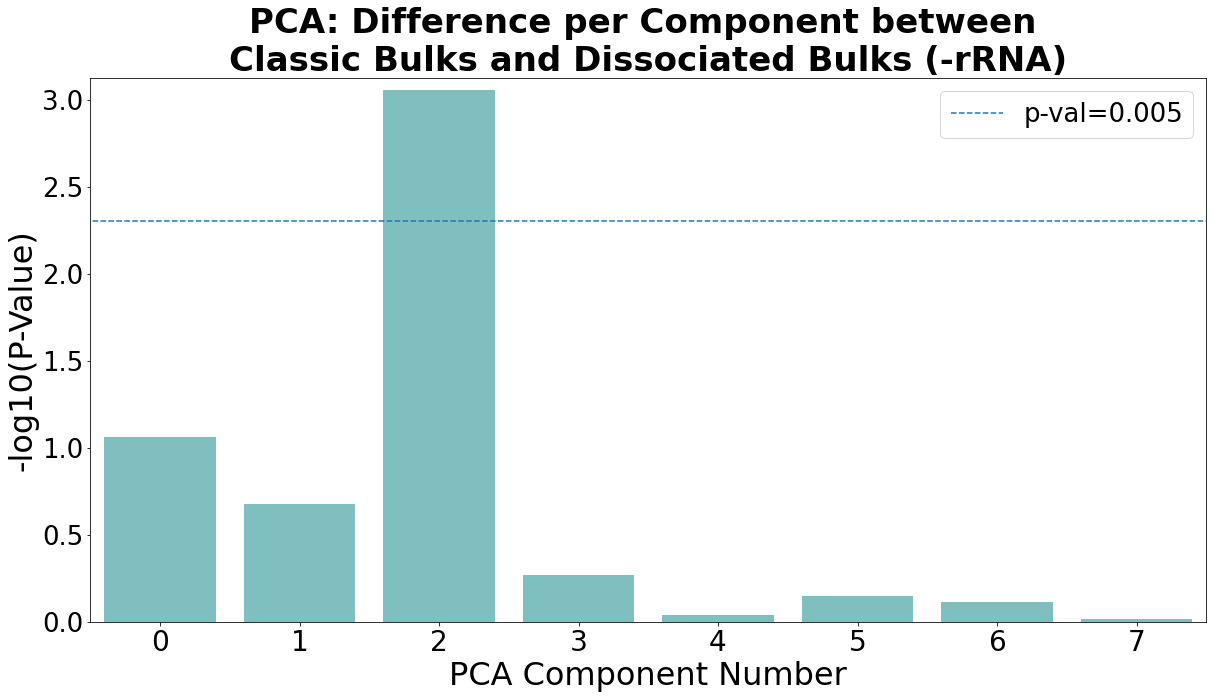

In [68]:
# Bar plot for each component
plt.figure(figsize=(20, 10))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)
plt.xlabel('PCA Component Number', fontsize=32, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=32, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=34, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=28)
plt.yticks(fontsize=26)
plt.ylim(0,max(-np.log10(results['P-Value']))+0.07)
plt.legend(fontsize=26)
plt.xlim(-0.5,7.5)
plt.show()

And evaluating the GOrilla results (of combo residual):

In [69]:
# The sheets on the Excel
#for figure sized
num=0
if add_adipo:
    added = "PCA_genes_residuals_combo_ADIP.xlsx"
else:
    added ="PCA_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3', 'Component_4', 'Component_5', 'Component_6', 'Component_7']  

In [70]:
#and exporting PCA genes per component for gene ontology analysis.

''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (20, 11)


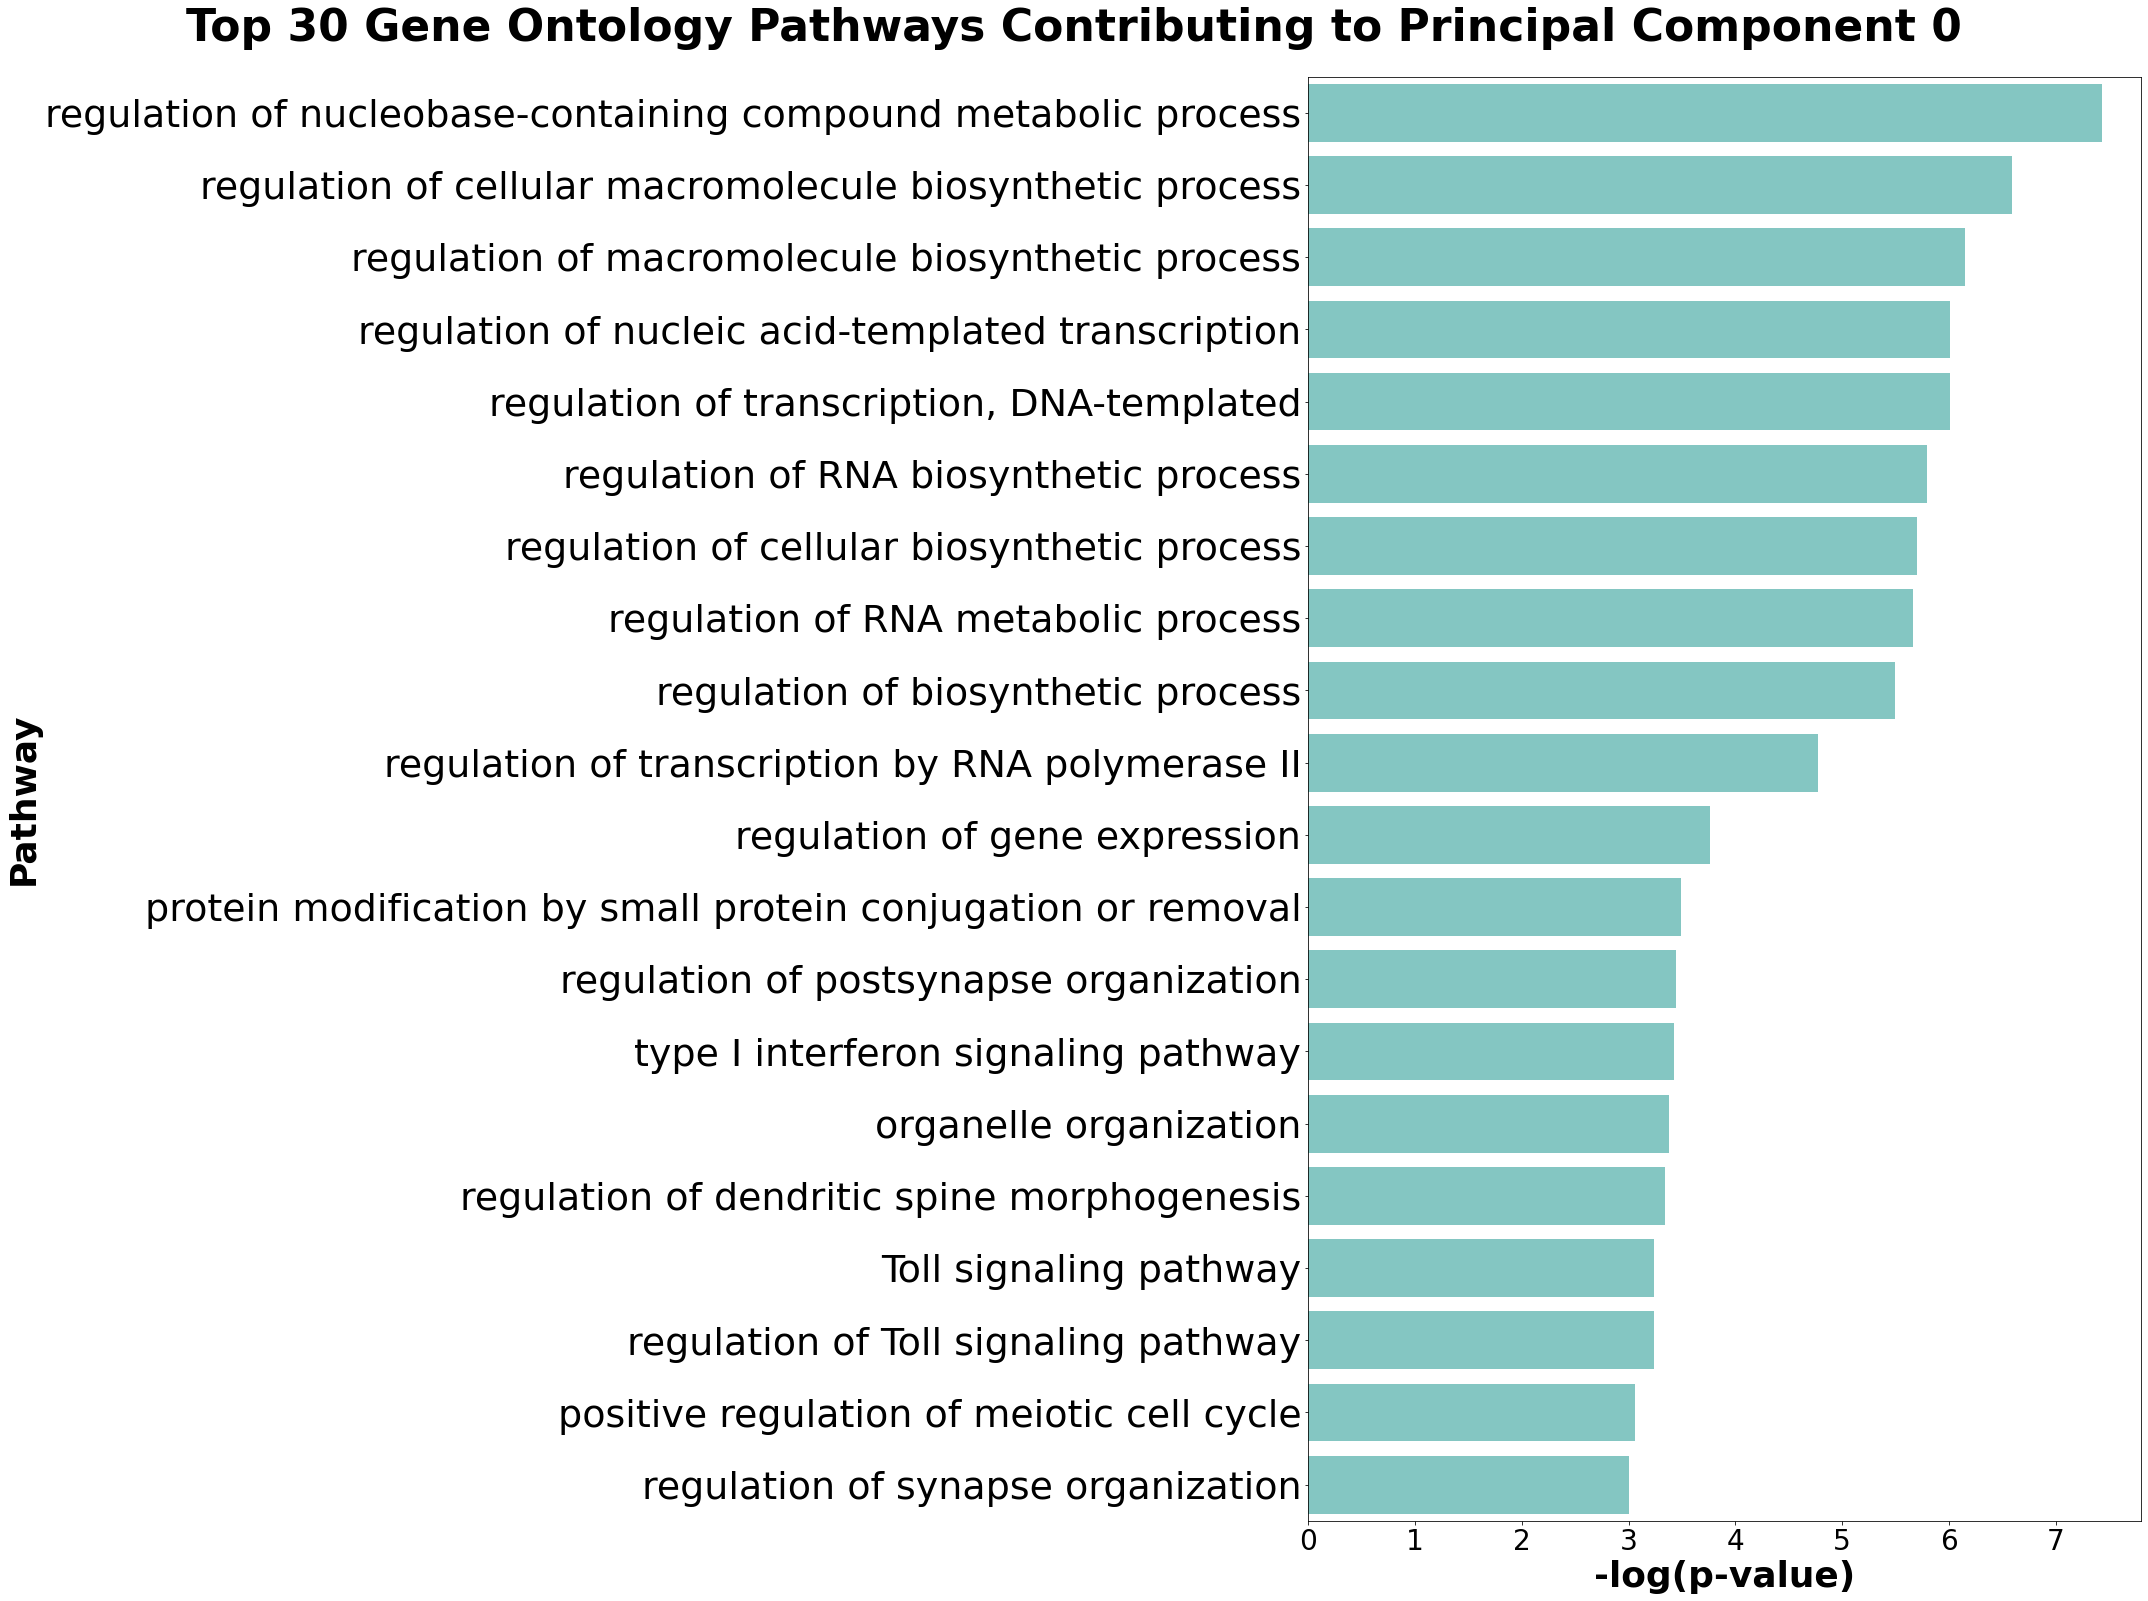

filtered: (30, 11)


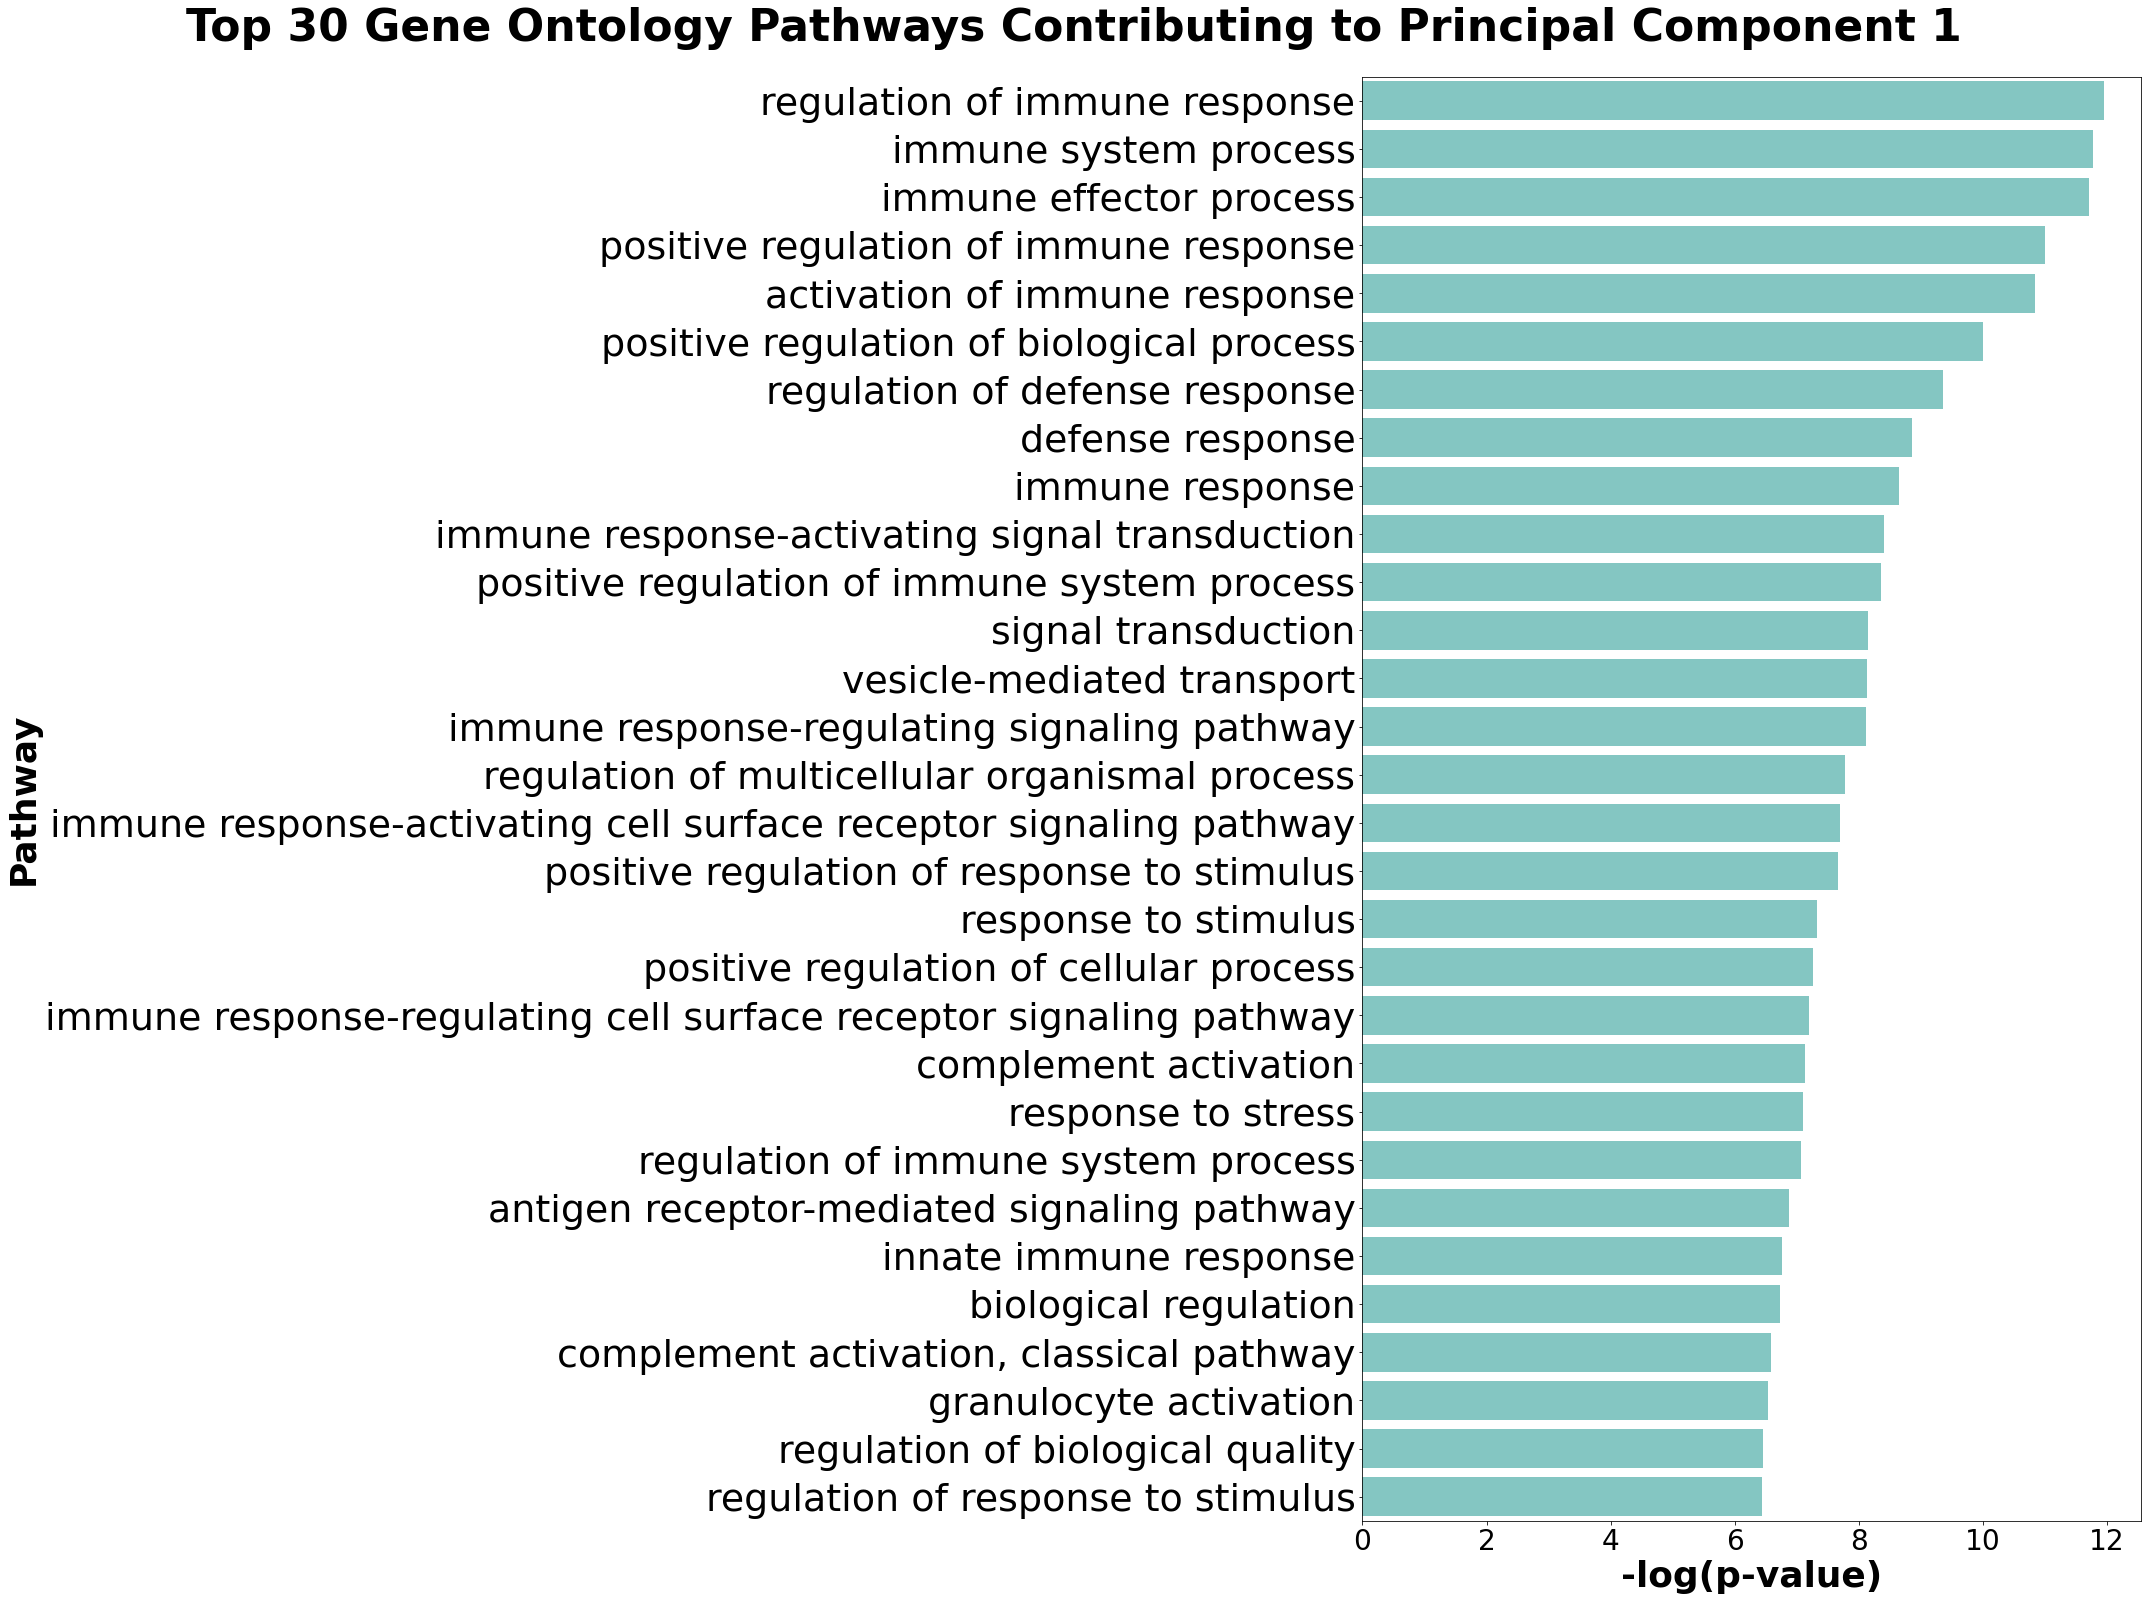

filtered: (30, 11)


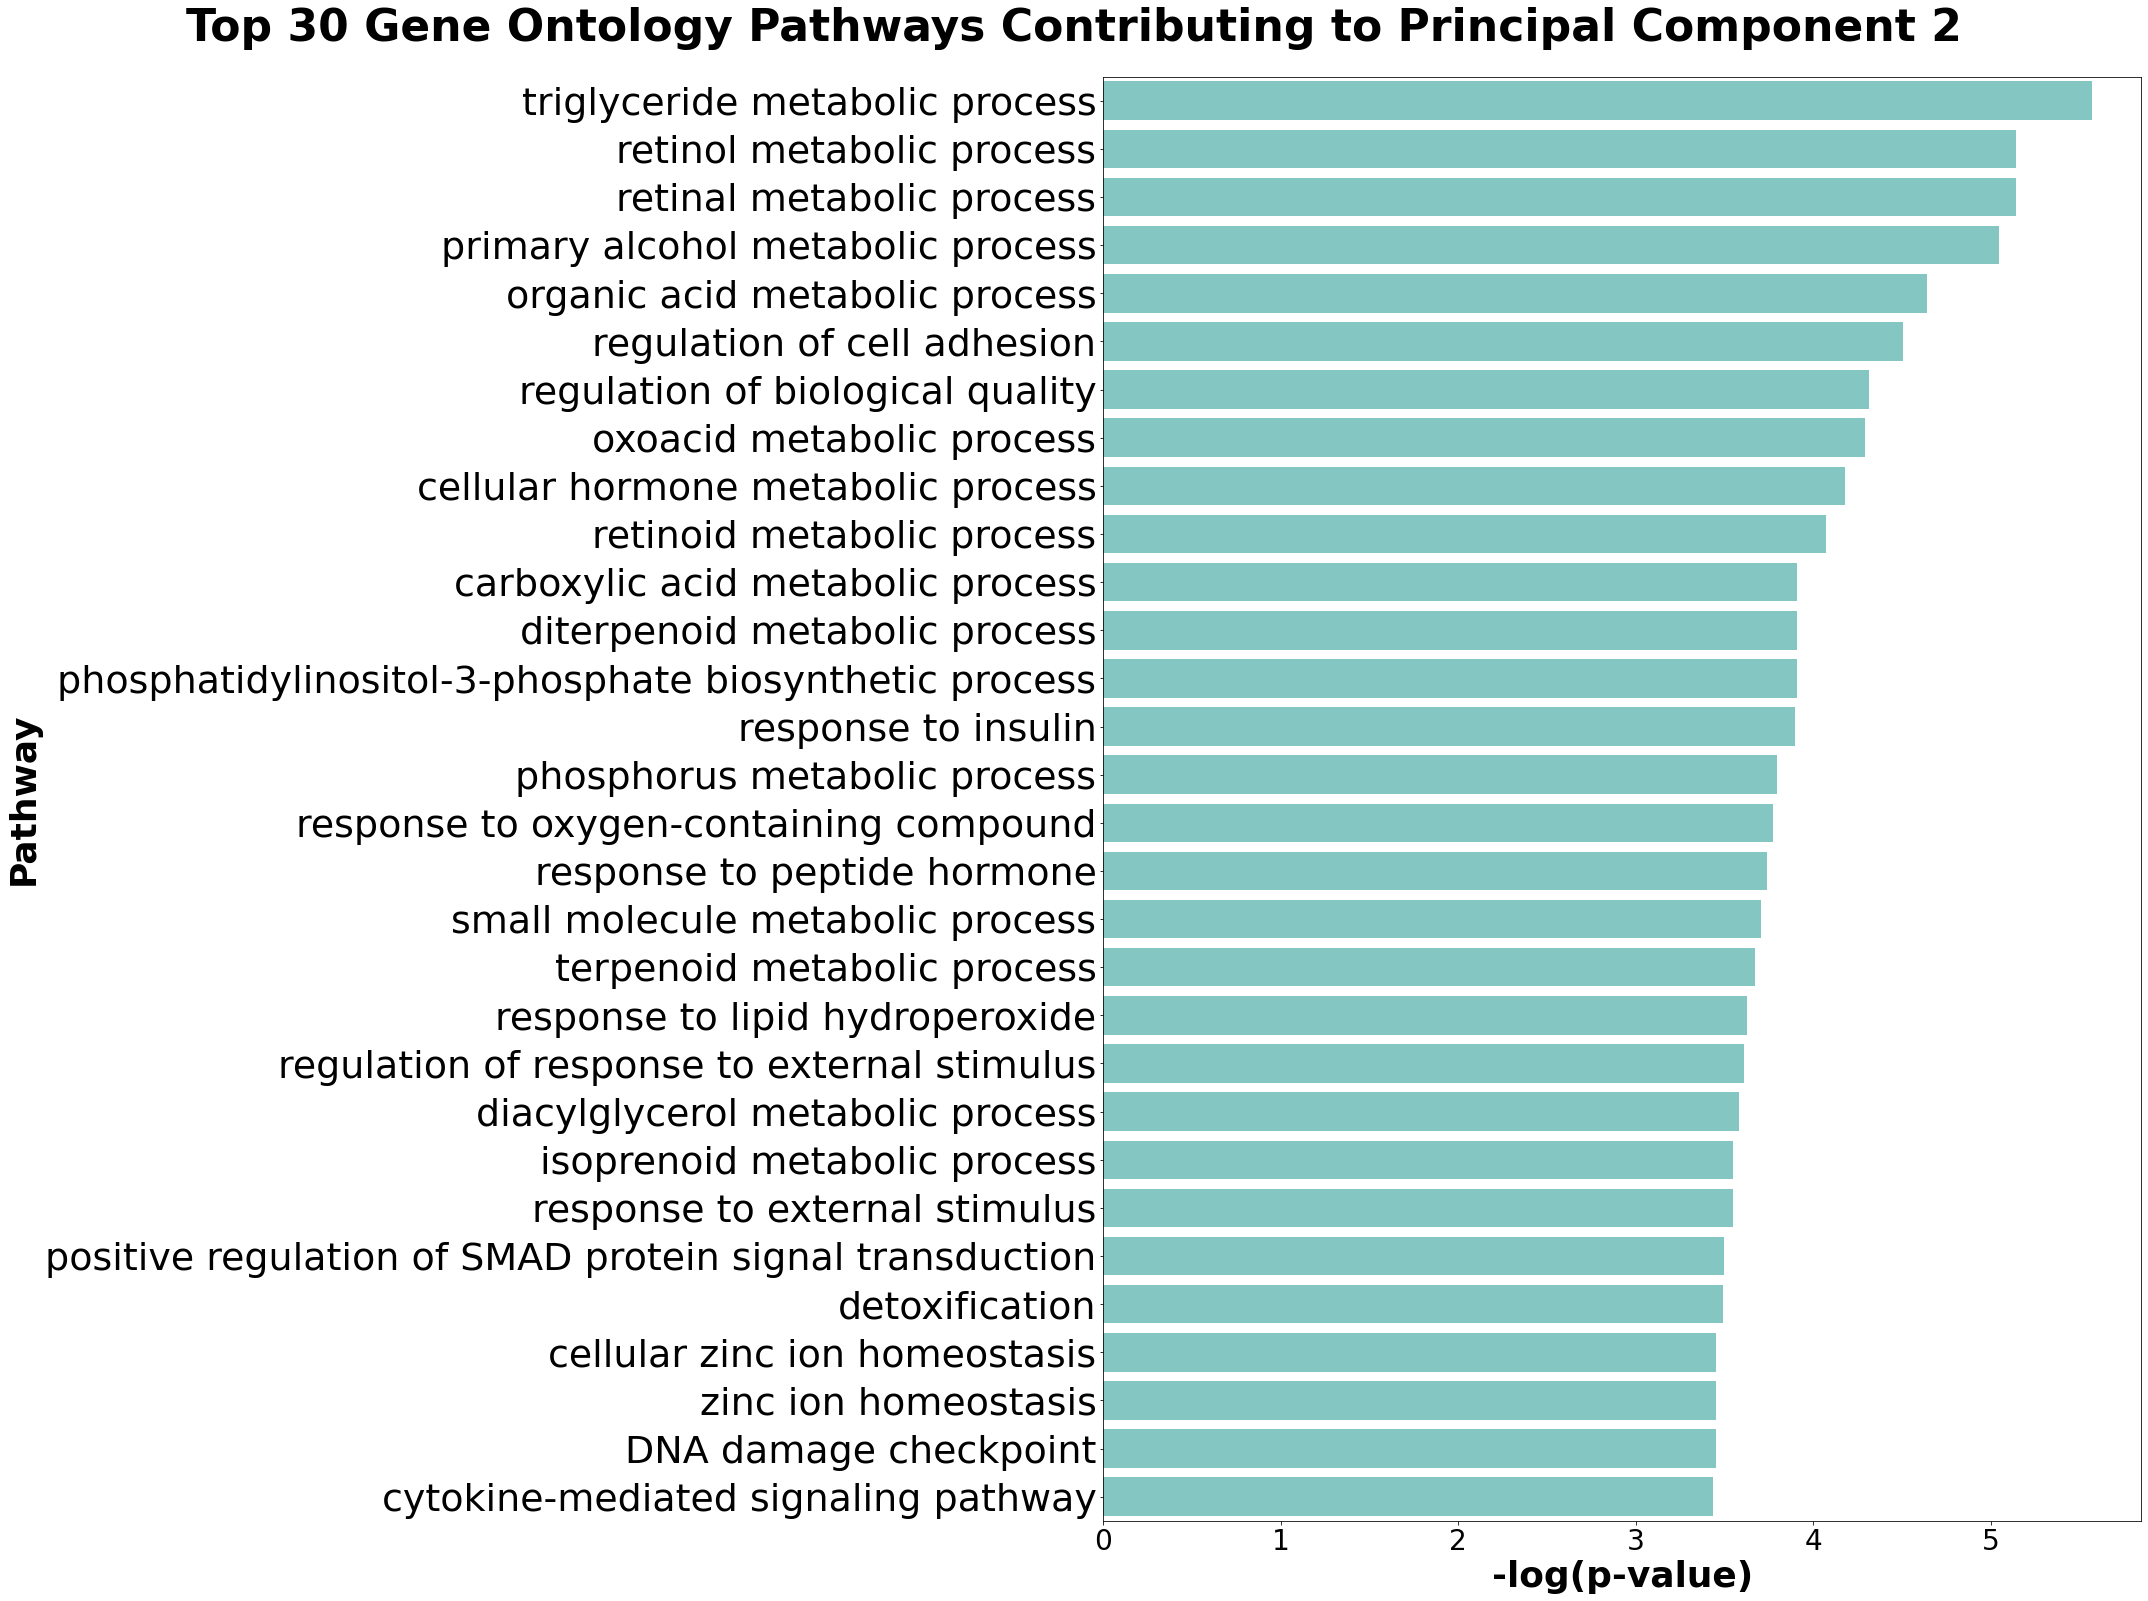

filtered: (30, 11)


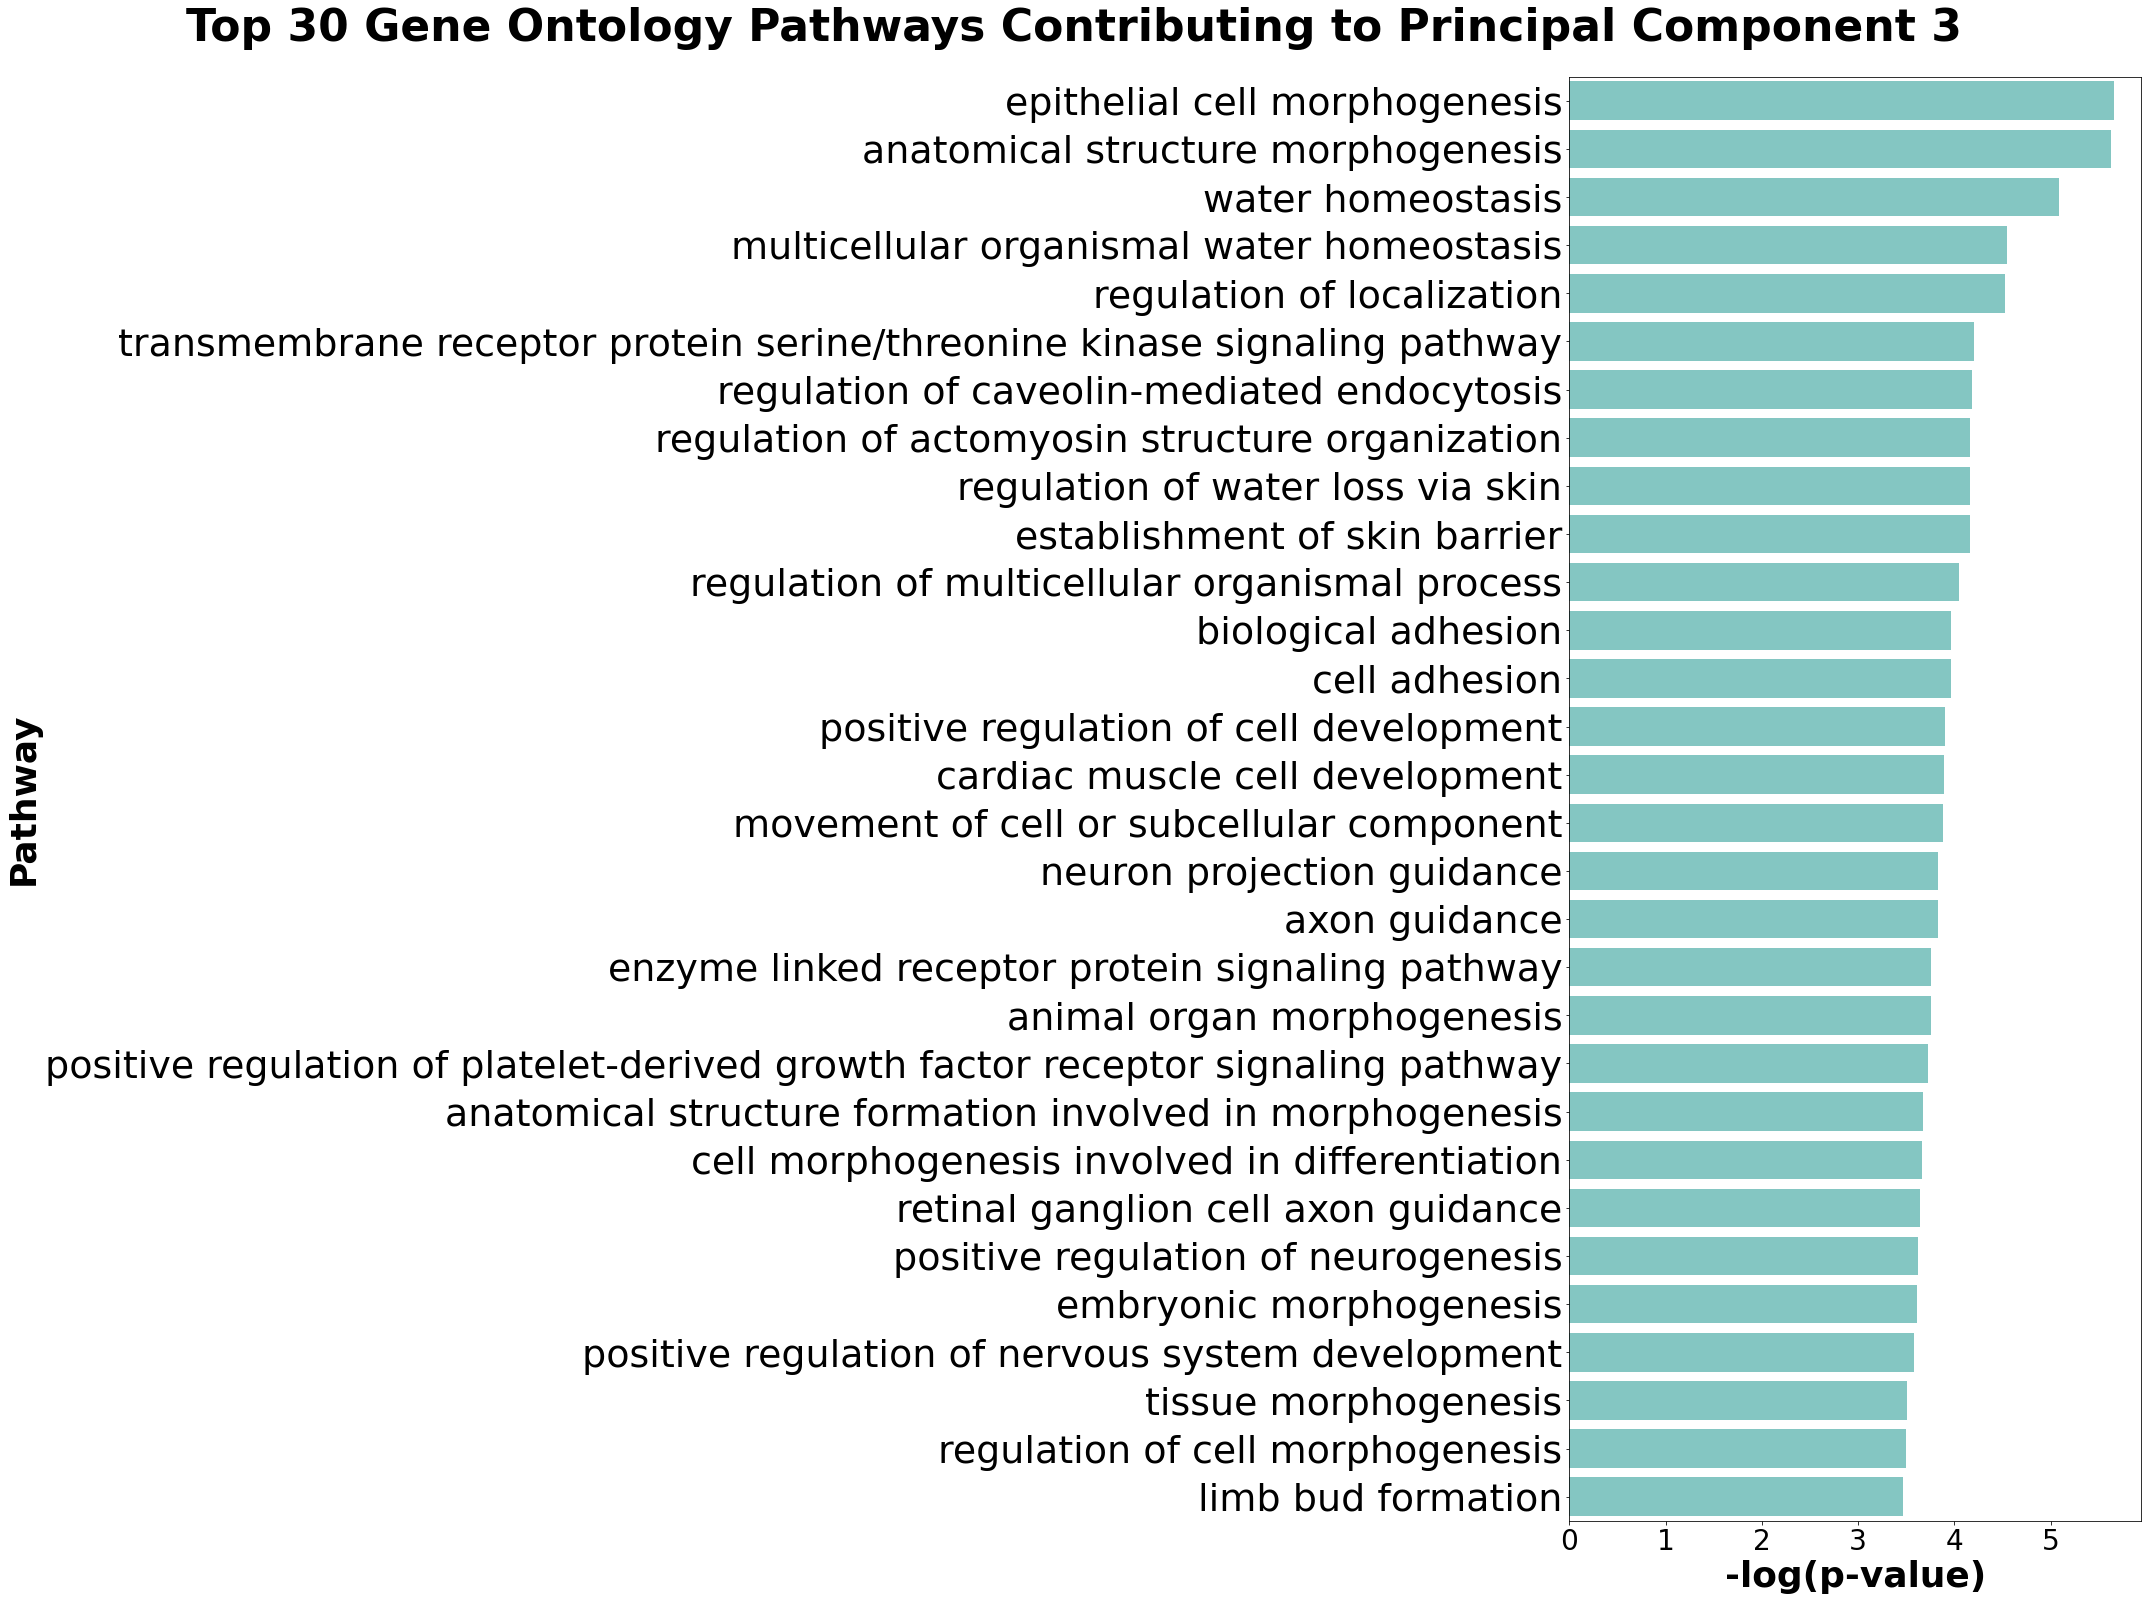

filtered: (30, 11)


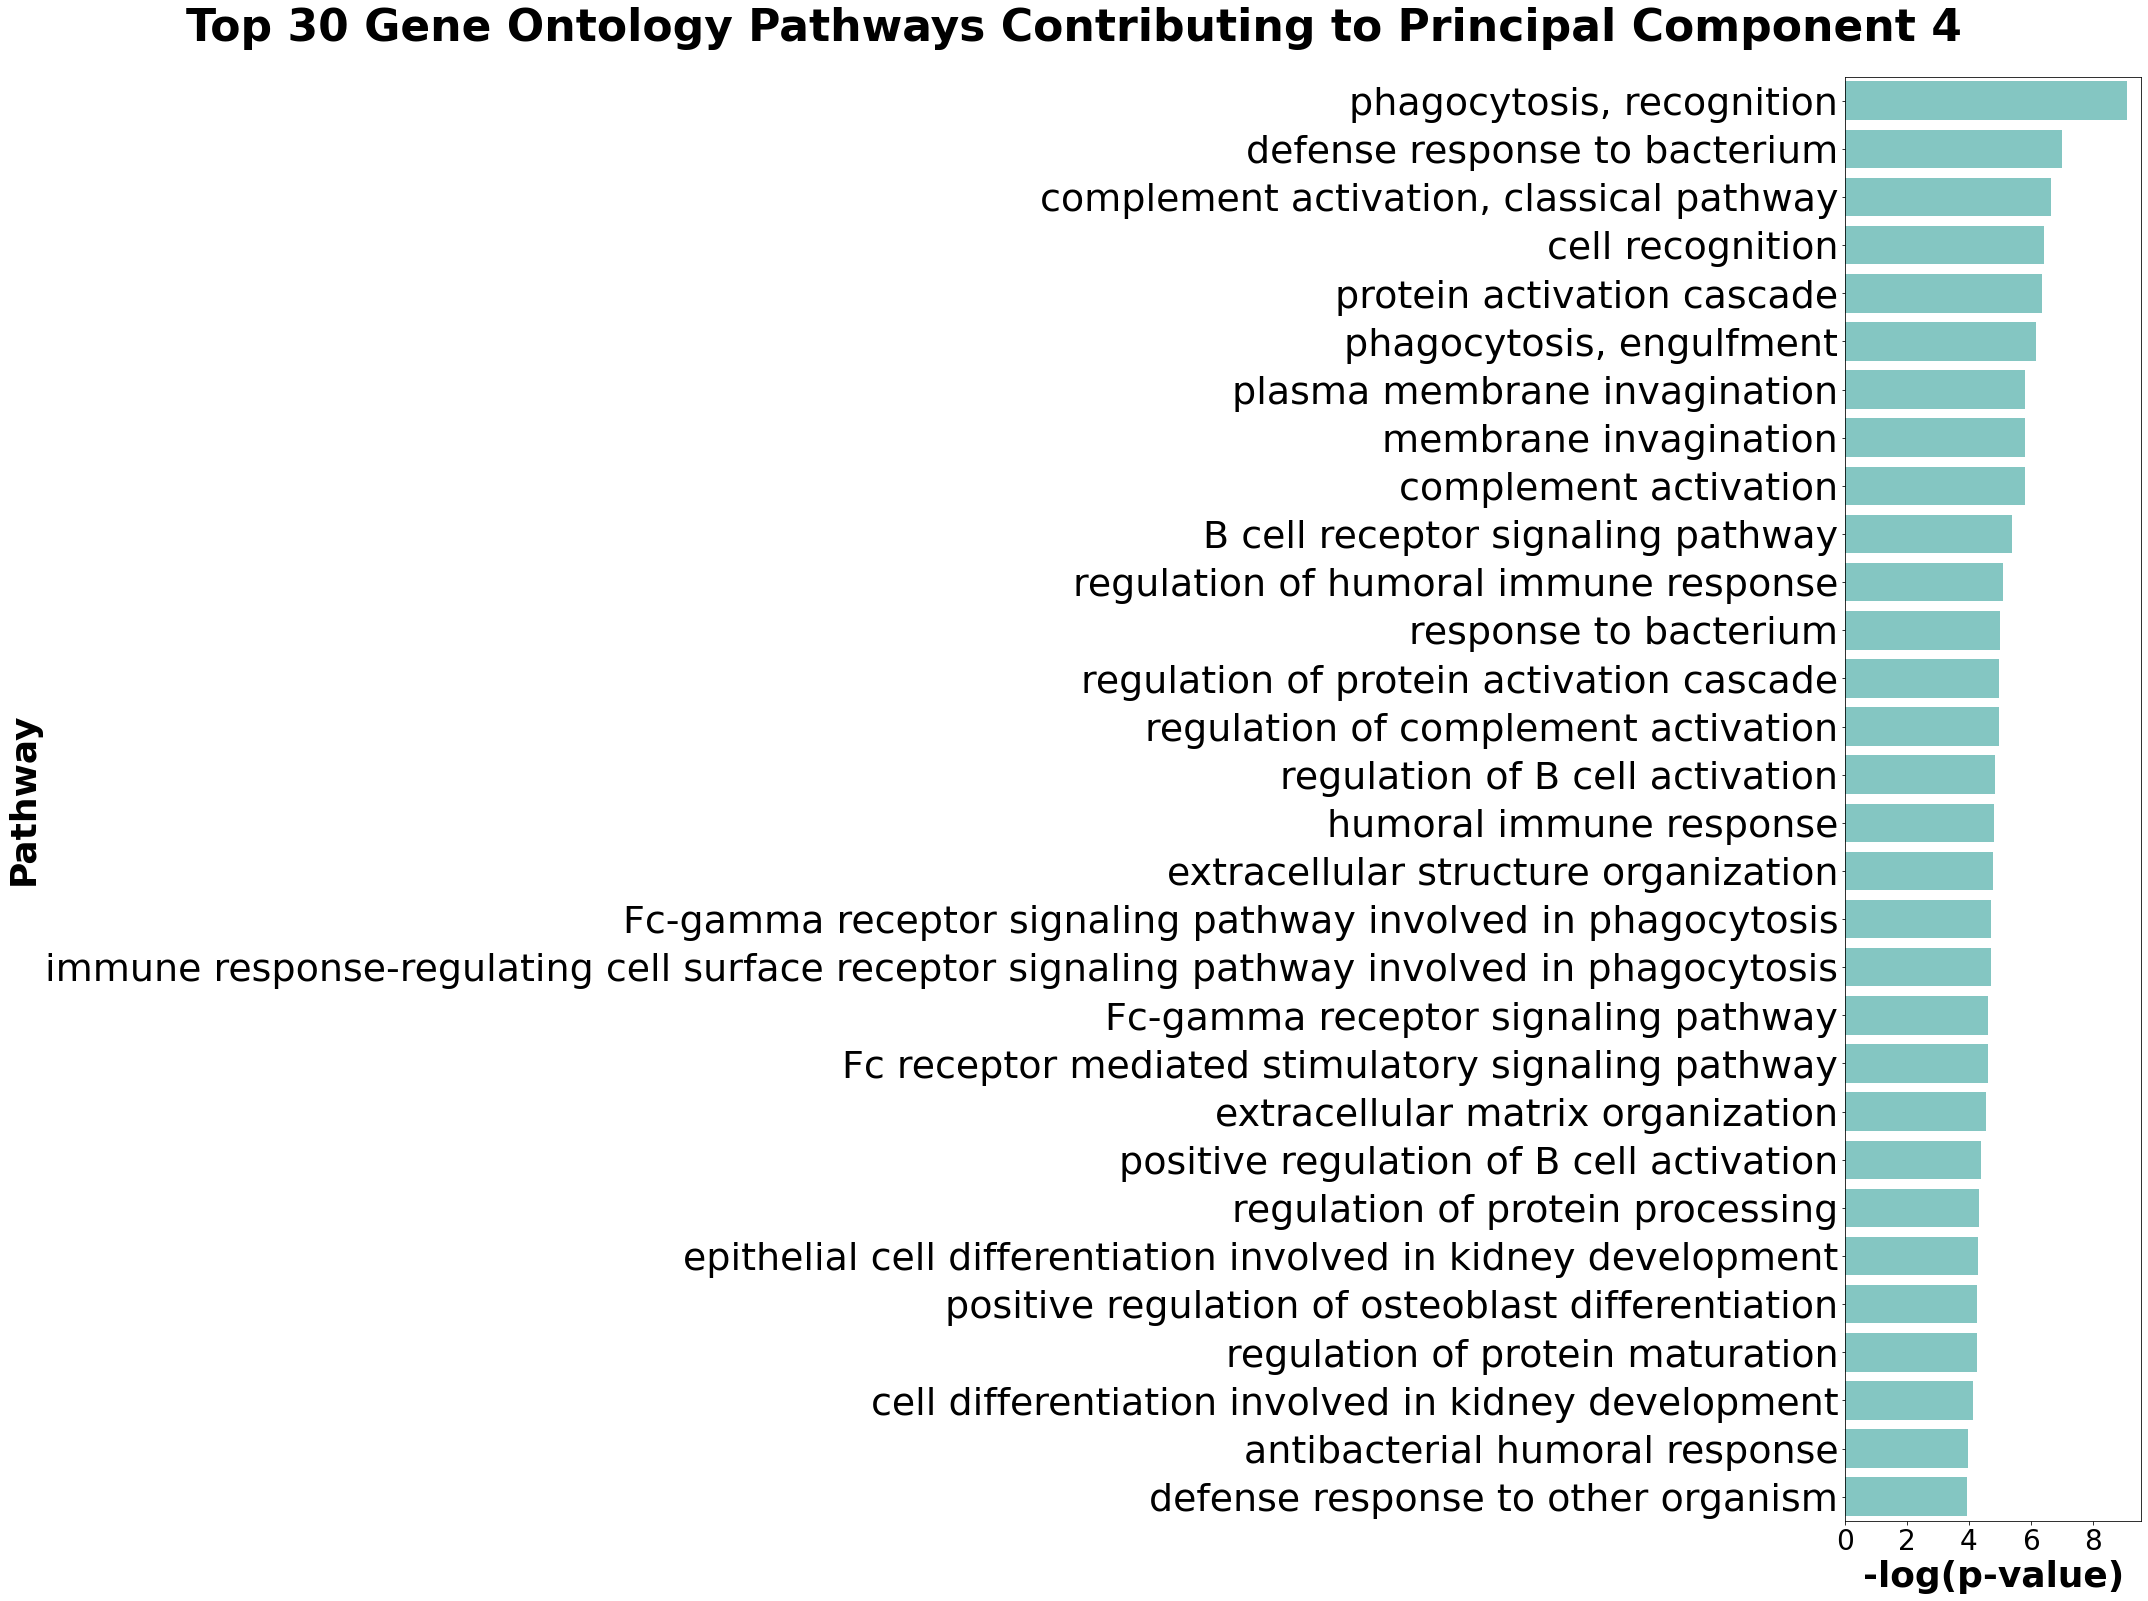

filtered: (30, 11)


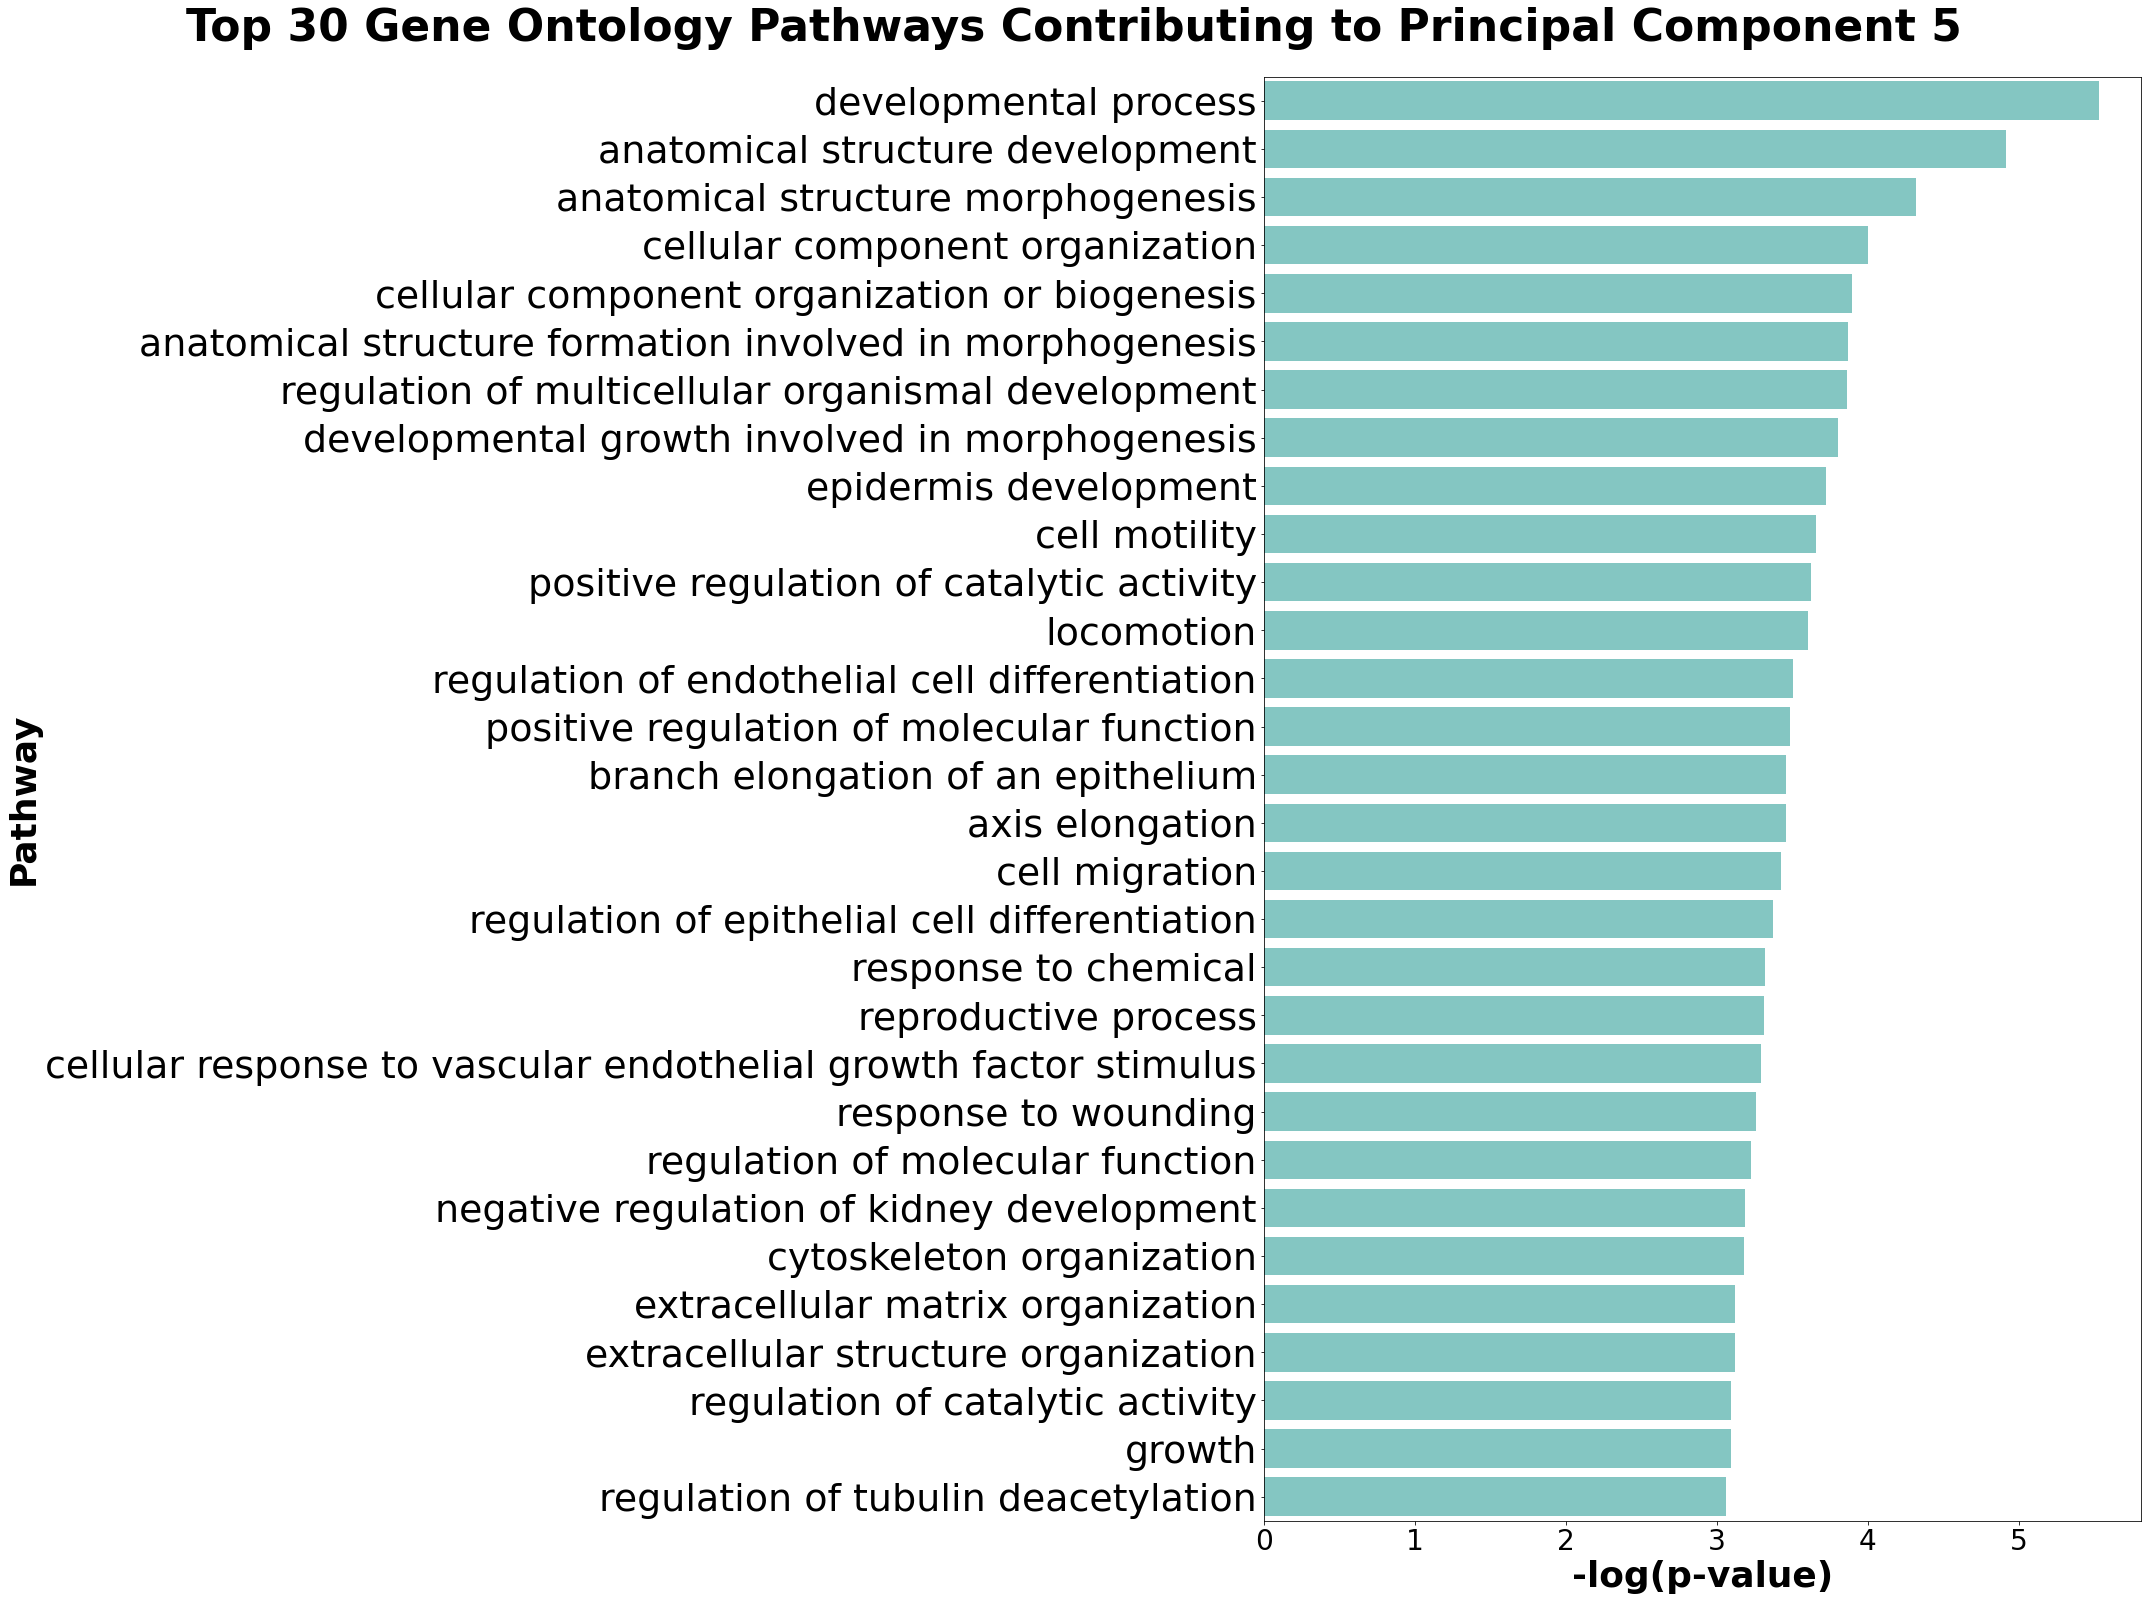

filtered: (30, 11)


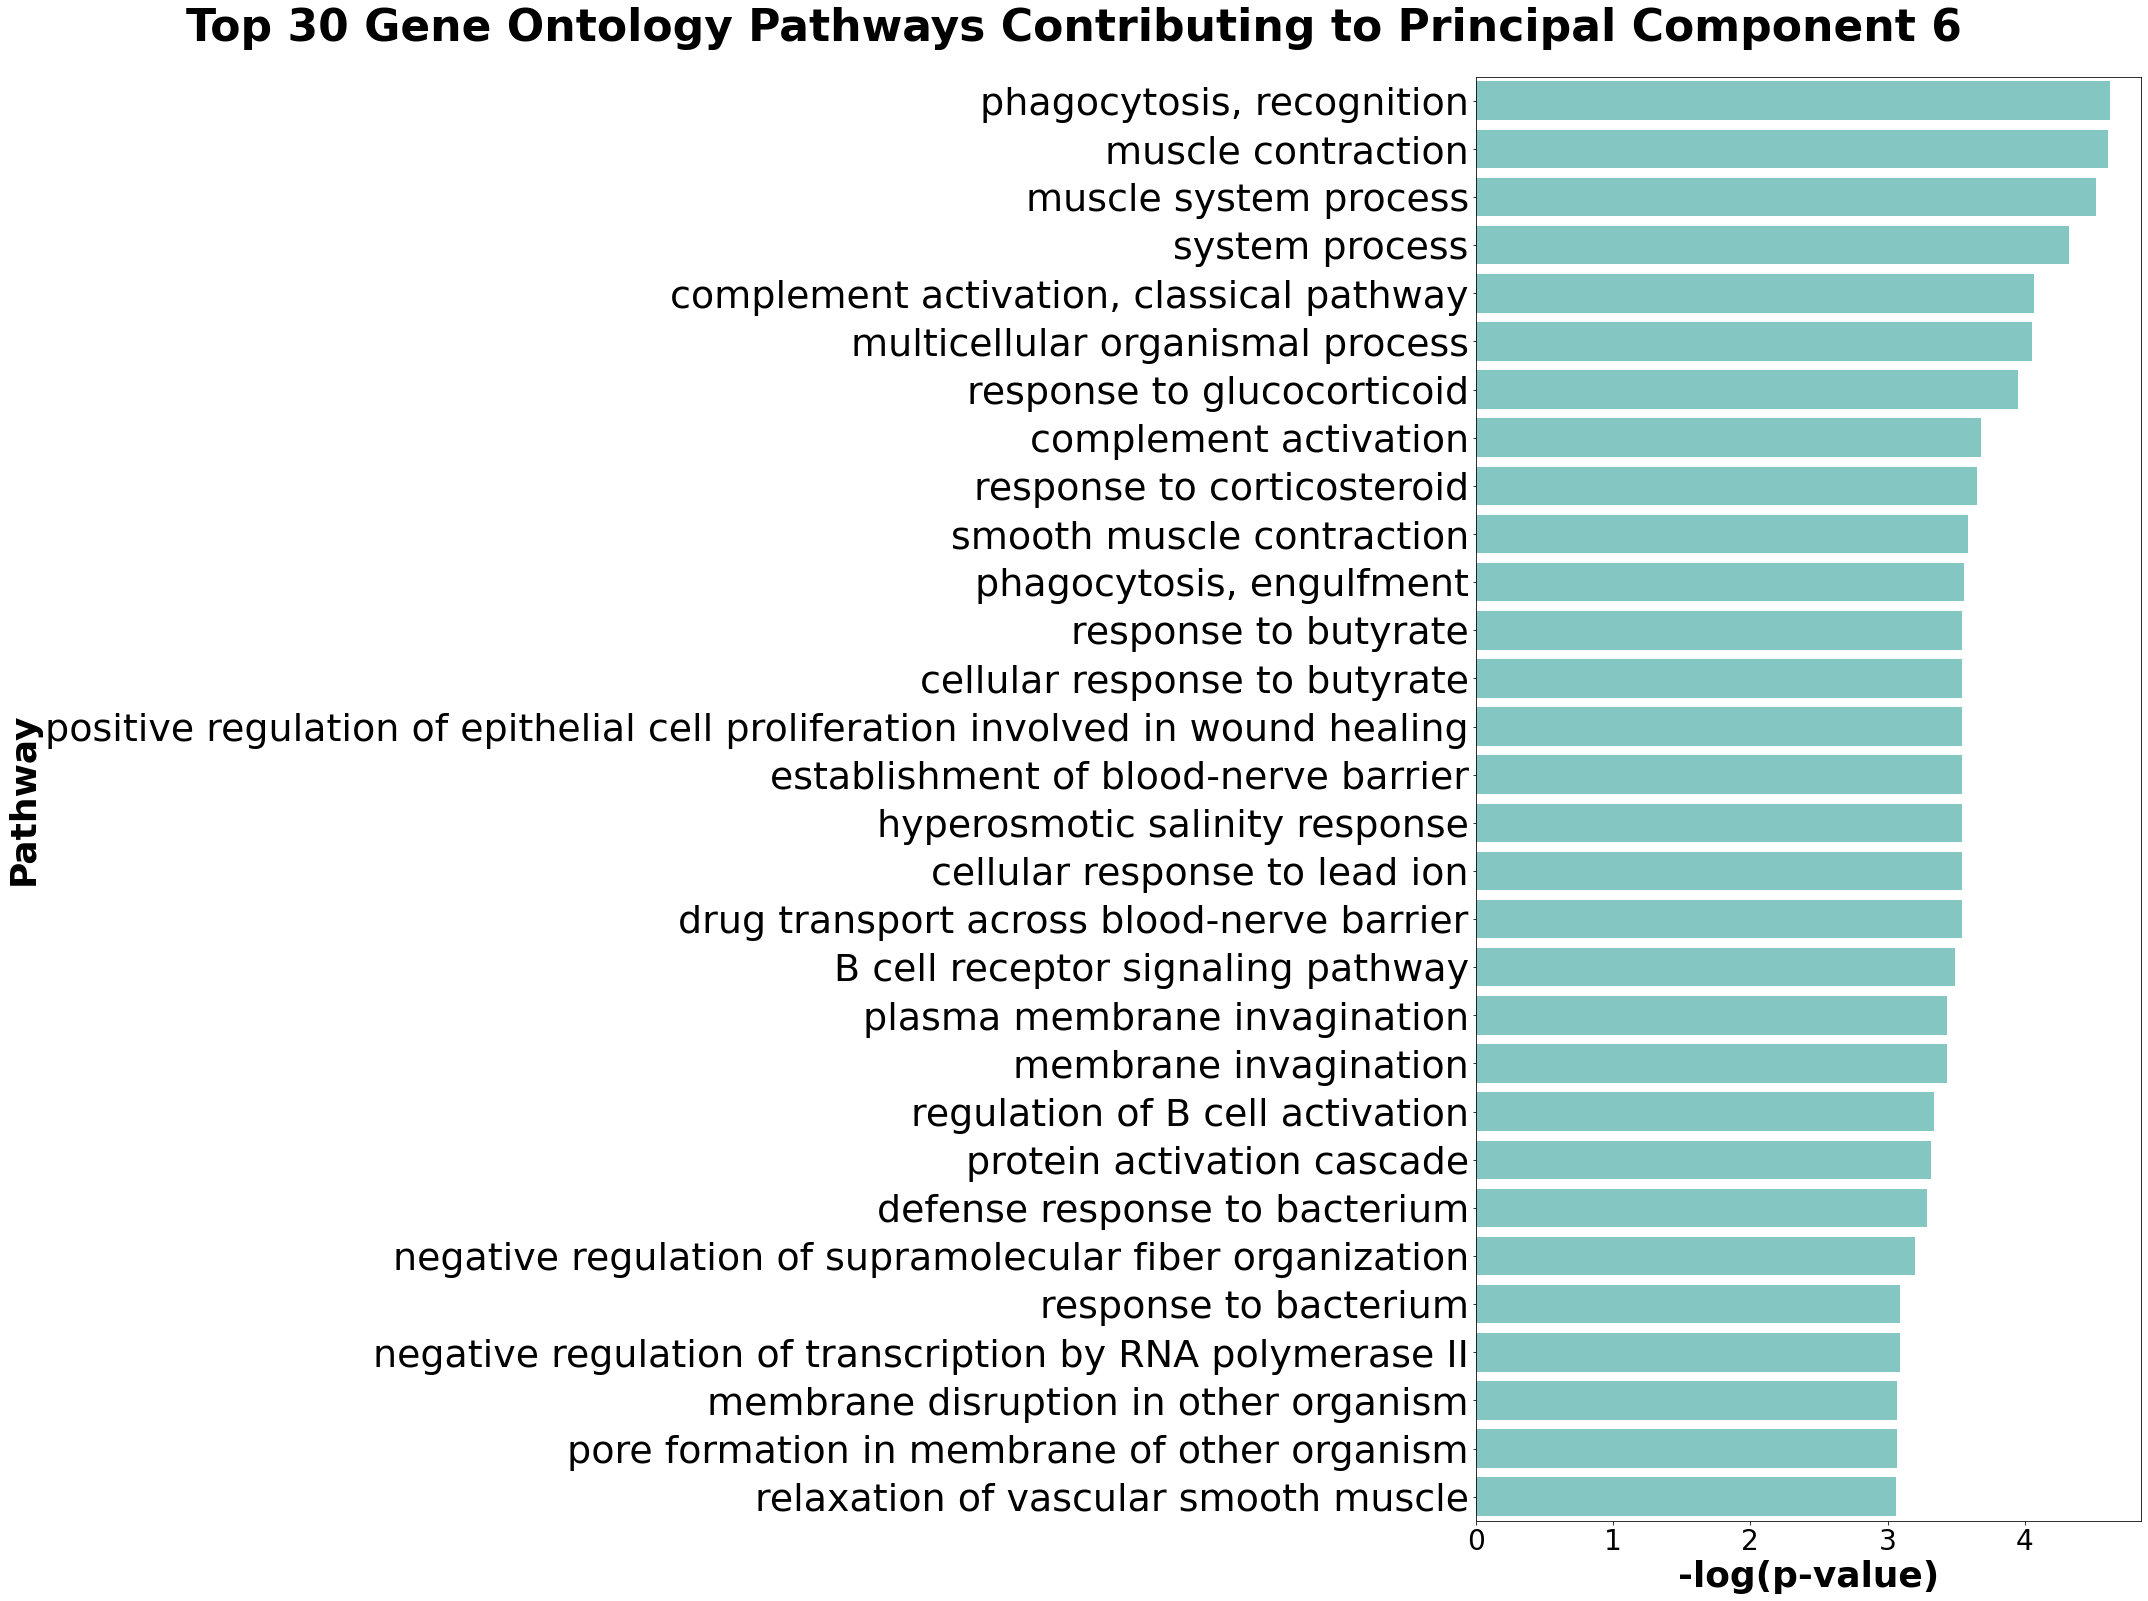

filtered: (30, 11)


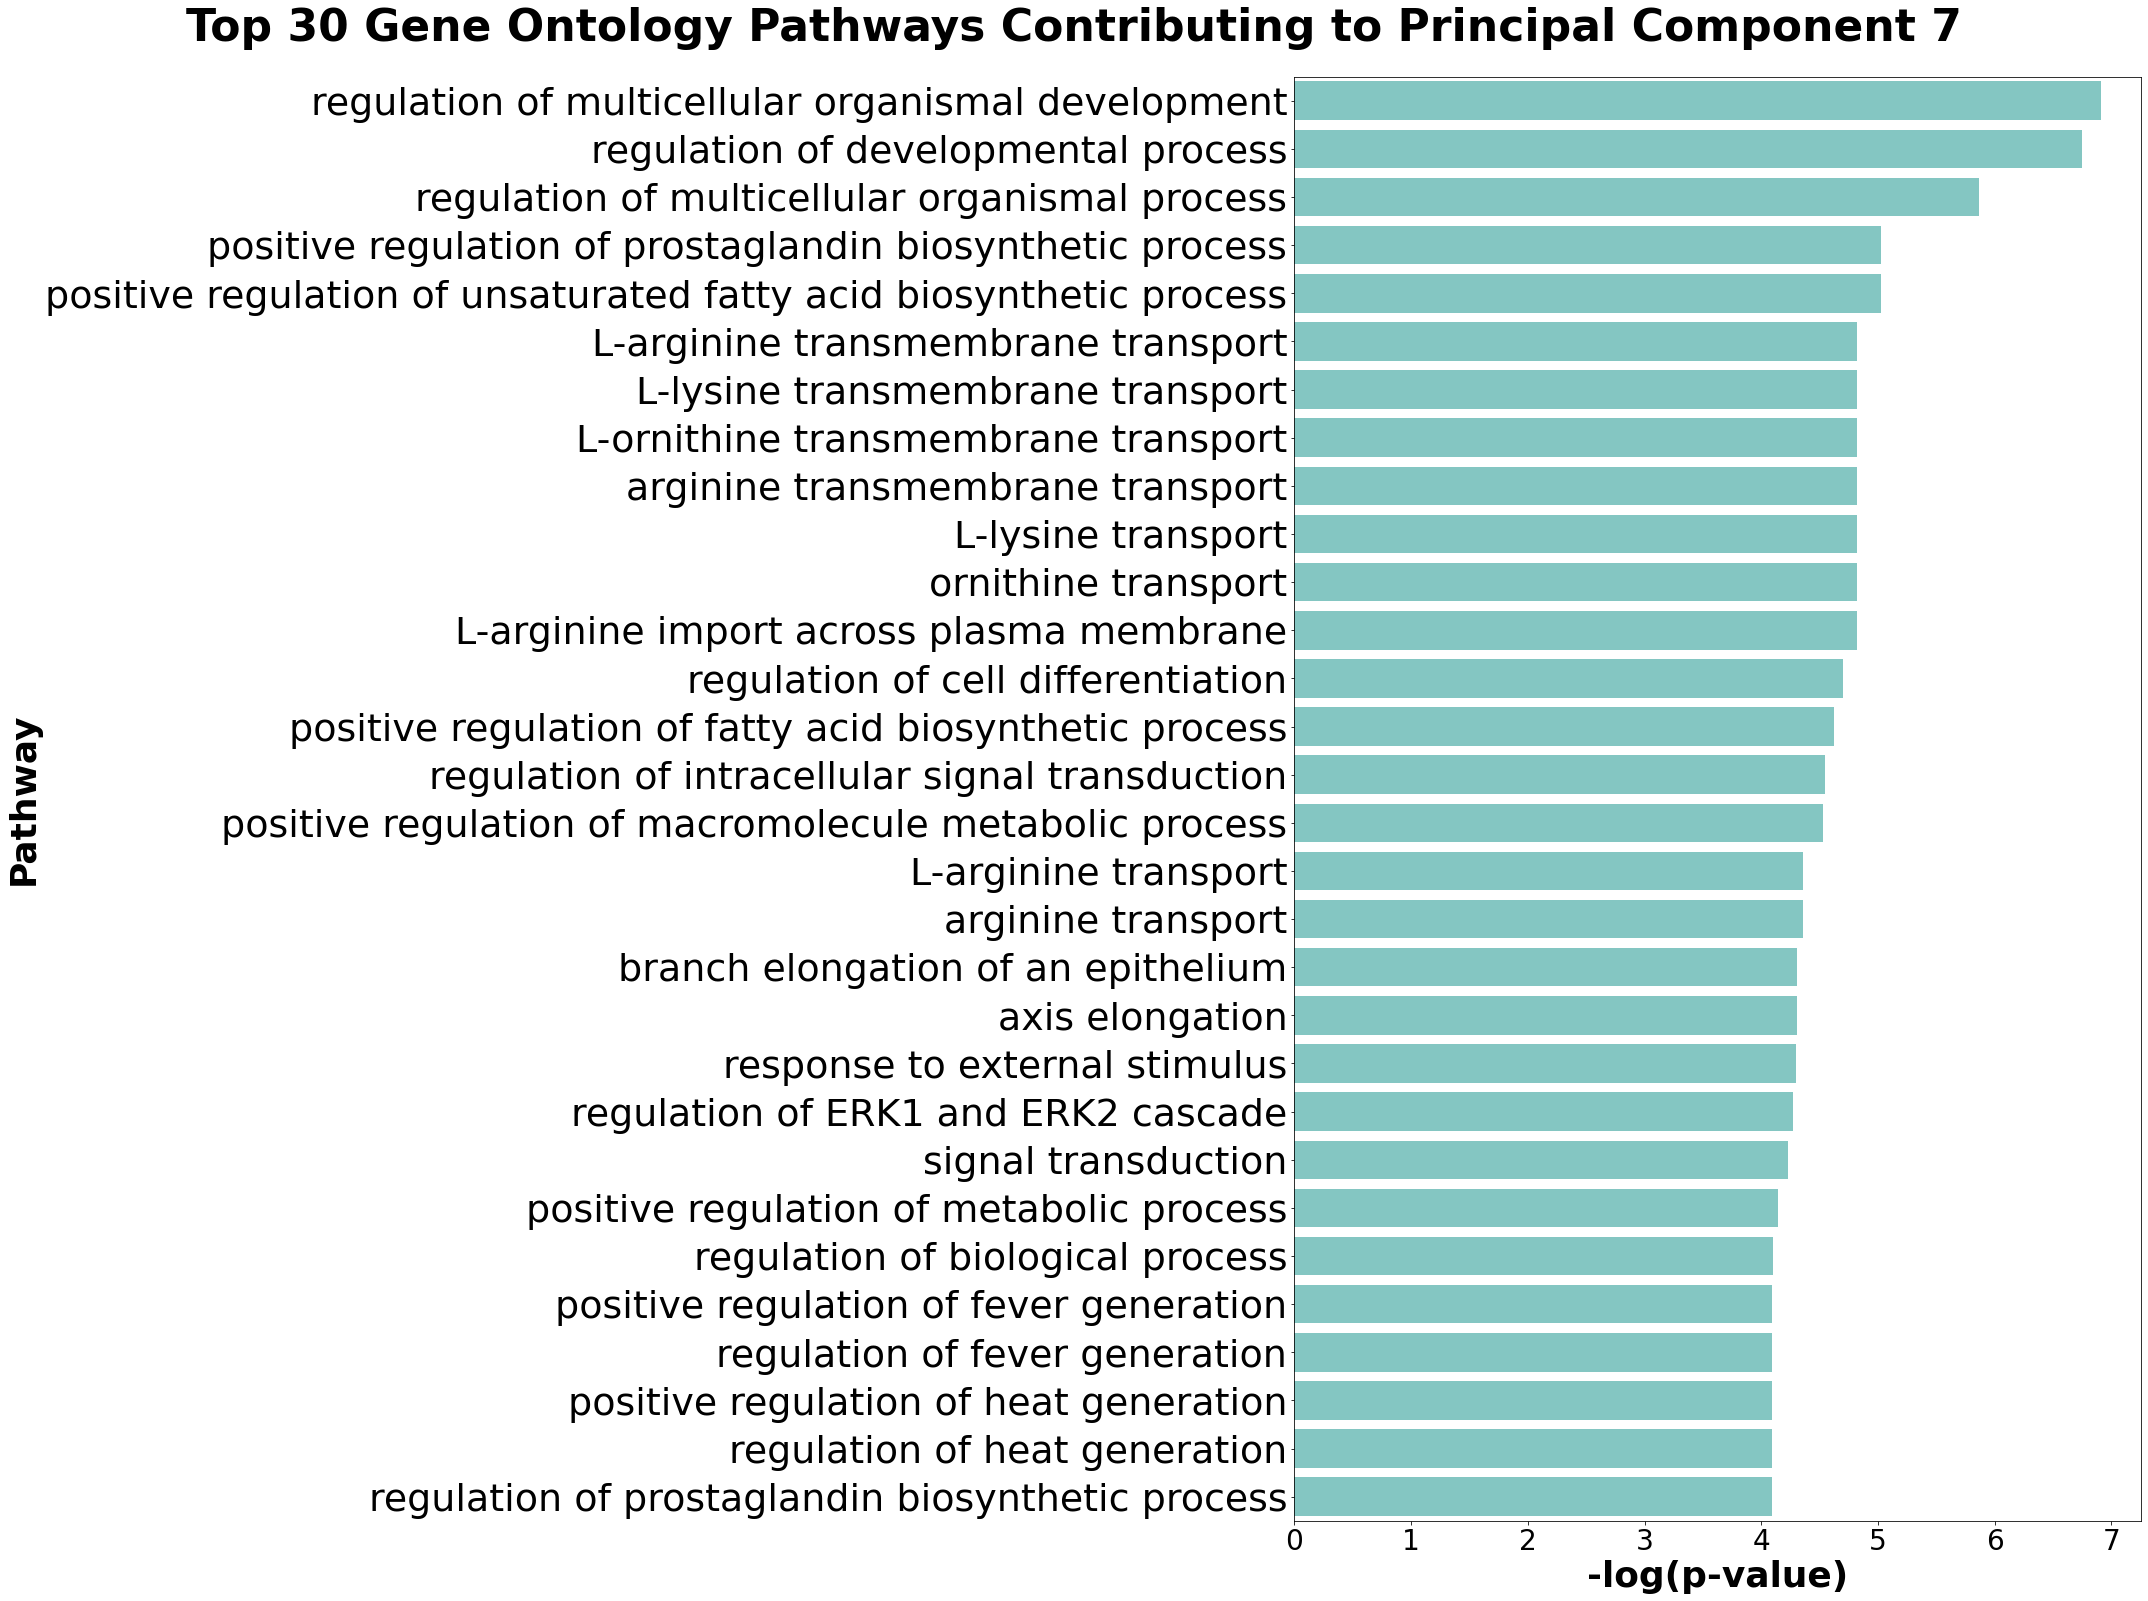

In [71]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()

## NMF

Analyzing how close to negative the distributions of each residual are:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


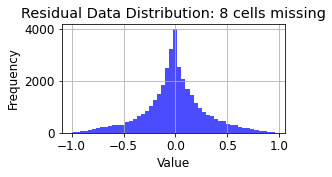

In [72]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

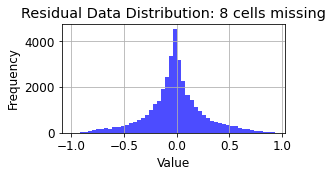

In [73]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9987524016268683


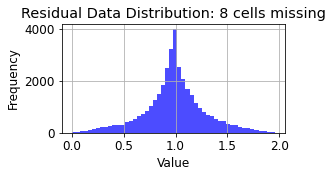

In [74]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9958686221854989


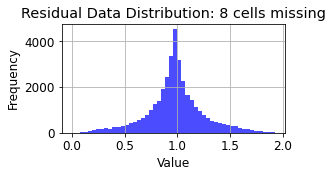

In [75]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9987524016268683


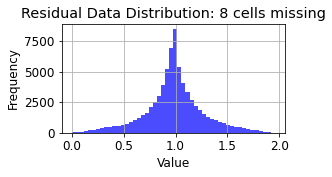

In [76]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [77]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
0  0.074830  0.152306  0.129216  0.136086  0.101746  0.098850  0.142711   
1  0.062671  0.164622  0.120328  0.113191  0.102256  0.137469  0.115651   
2  0.087187  0.119586  0.109141  0.130246  0.084635  0.182524  0.095399   
3  0.074691  0.125936  0.118411  0.150733  0.088831  0.106353  0.125386   

      ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
0  0.140866  0.102077  0.129166  ...  0.047687  0.109085  0.116336  0.109796   
1  0.148813  0.189854  0.108251  ...  0.035176  0.089040  0.094026  0.134117   
2  0.129727  0.060634  0.111434  ...  0.041292  0.089244  0.084668  0.103666   
3  0.127886  0.144763  0.105174  ...  0.018849  0.092533  0.092911  0.116155   

       ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
0  0.119274  0.110907  0.127912  0.179425  0.149784  0.156122  
1  0.119394  0.093788  0.139776  0.183310  0.184508  0.056663  
2  0.251721  0.093759  0.132315  0.144246  0.126112  0.184990  
3  0.131791  0.091930  0.111449  0.158545  0.118429  0.121594  

[4 rows x 4584 columns]

In [78]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.072186  9.434750e-01
1        1.0     0.805743  4.338640e-01
2        2.0    -8.723047  4.932123e-07
3        3.0     0.950153  3.581498e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -8.723047  4.932123e-07


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


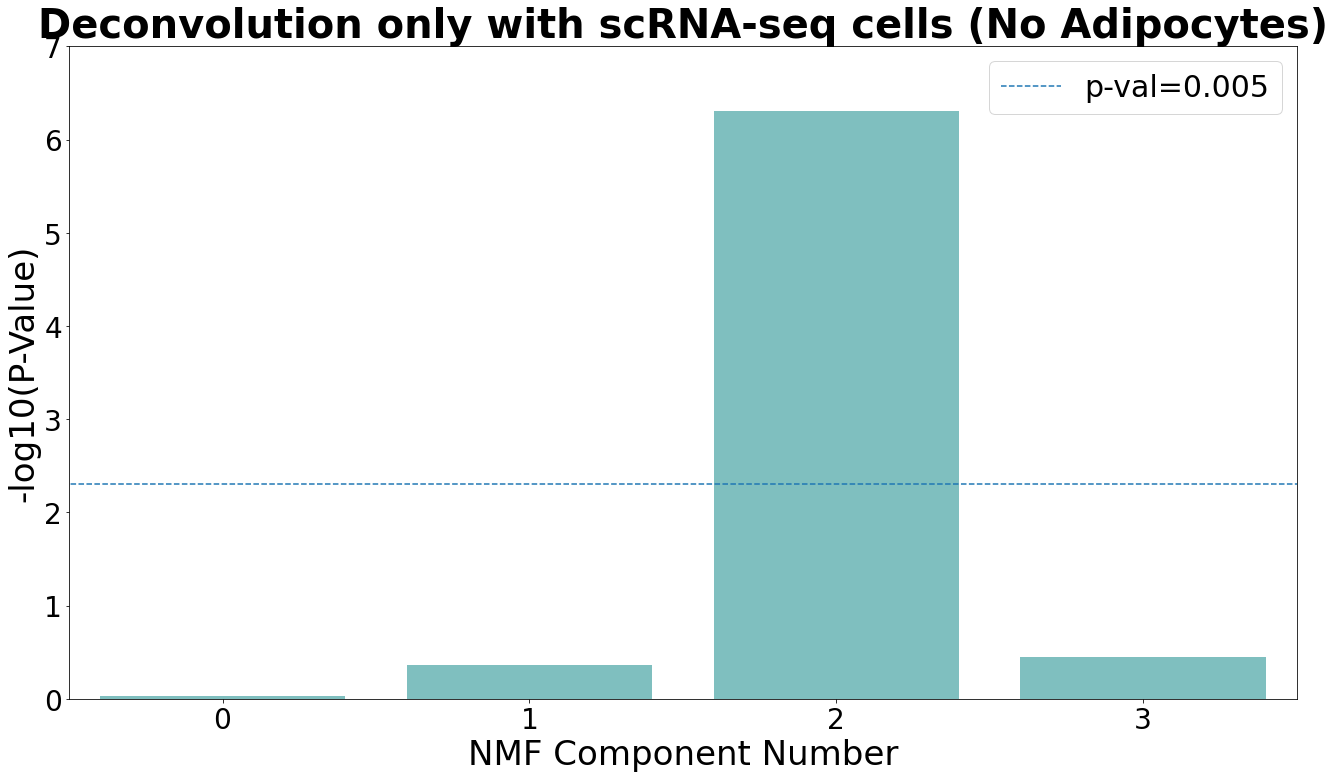

In [79]:
# Bar plot for each component
plt.figure(figsize=(22,12))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=34, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=34, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
if add_adipo == True:
    title_str = 'Deconvolution scRNA-seq cells and snRNA-seq added Adipocytes'
else:
    title_str ='Deconvolution only with scRNA-seq cells (No Adipocytes)'
plt.title(title_str, fontsize=40, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3], fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend(fontsize=30)
plt.show()

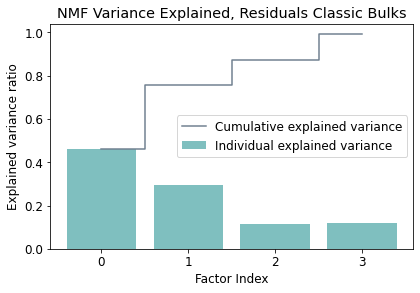

In [80]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]

## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [81]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

Component_0 Component_1 Component_2 Component_3
0           LY75       GABRE       NLRP3        TLN2
1          CIITA     TMEM63A        RELT      PLXNA4
2           TAP2       WDR91      KLHL21         TTN
3         BTN3A1       OBSCN       DUSP2        GPAM
4            TTN       PTPRS     ZC3H12A       F13A1
...          ...         ...         ...         ...
4579        MT1M       ADIRF        NSD3       TEX14
4580        AREG       IGHG4        UPF2    HIST1H1D
4581         CFD       IGHG3     SELENOP      CLEC2B
4582    ANKRD33B       IGHA1       HIPK2      PMAIP1
4583       DEFB1         ID2       BICD1        CCL3

[4584 rows x 4 columns]

And plotting gene ontology analysis pathways.

NOTE: You'll have to run GOrilla for this part!

In [87]:
# The sheets on the Excel
if add_adipo:
    added = "NMF_genes_residuals_combo_ADIP.xlsx"
else:
    added ="NMF_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3']  

In [88]:
#Exporting NMF genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
nmf_genes_combo.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

filtered: (30, 11)


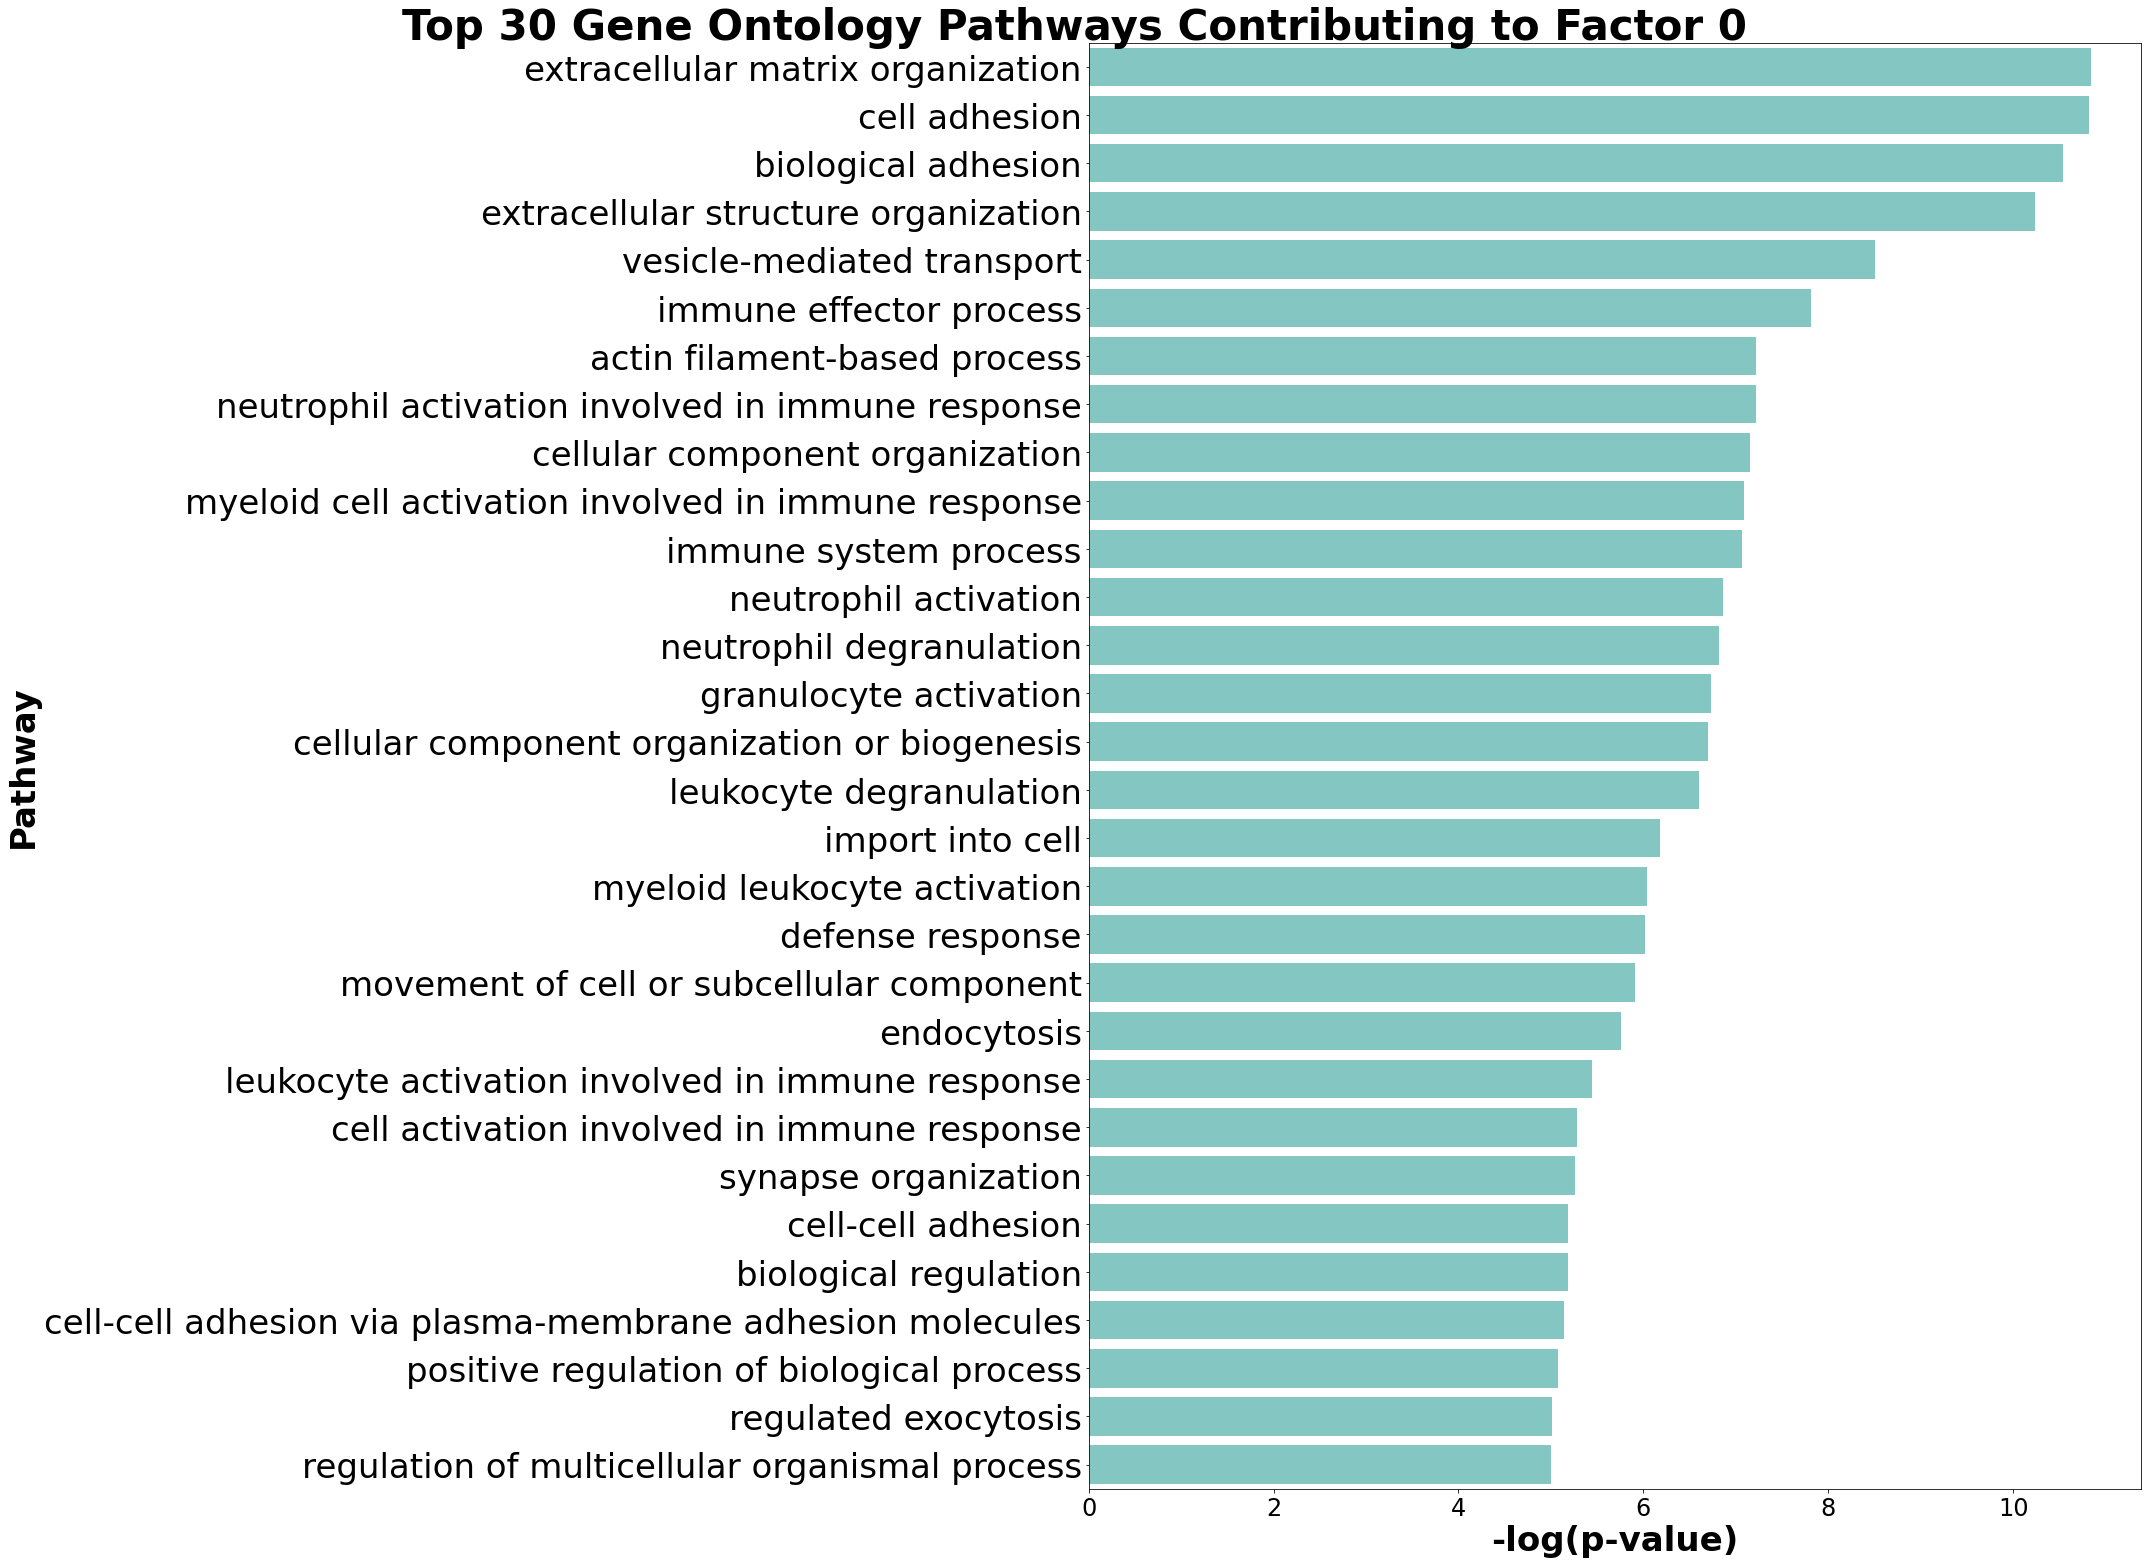

filtered: (9, 11)


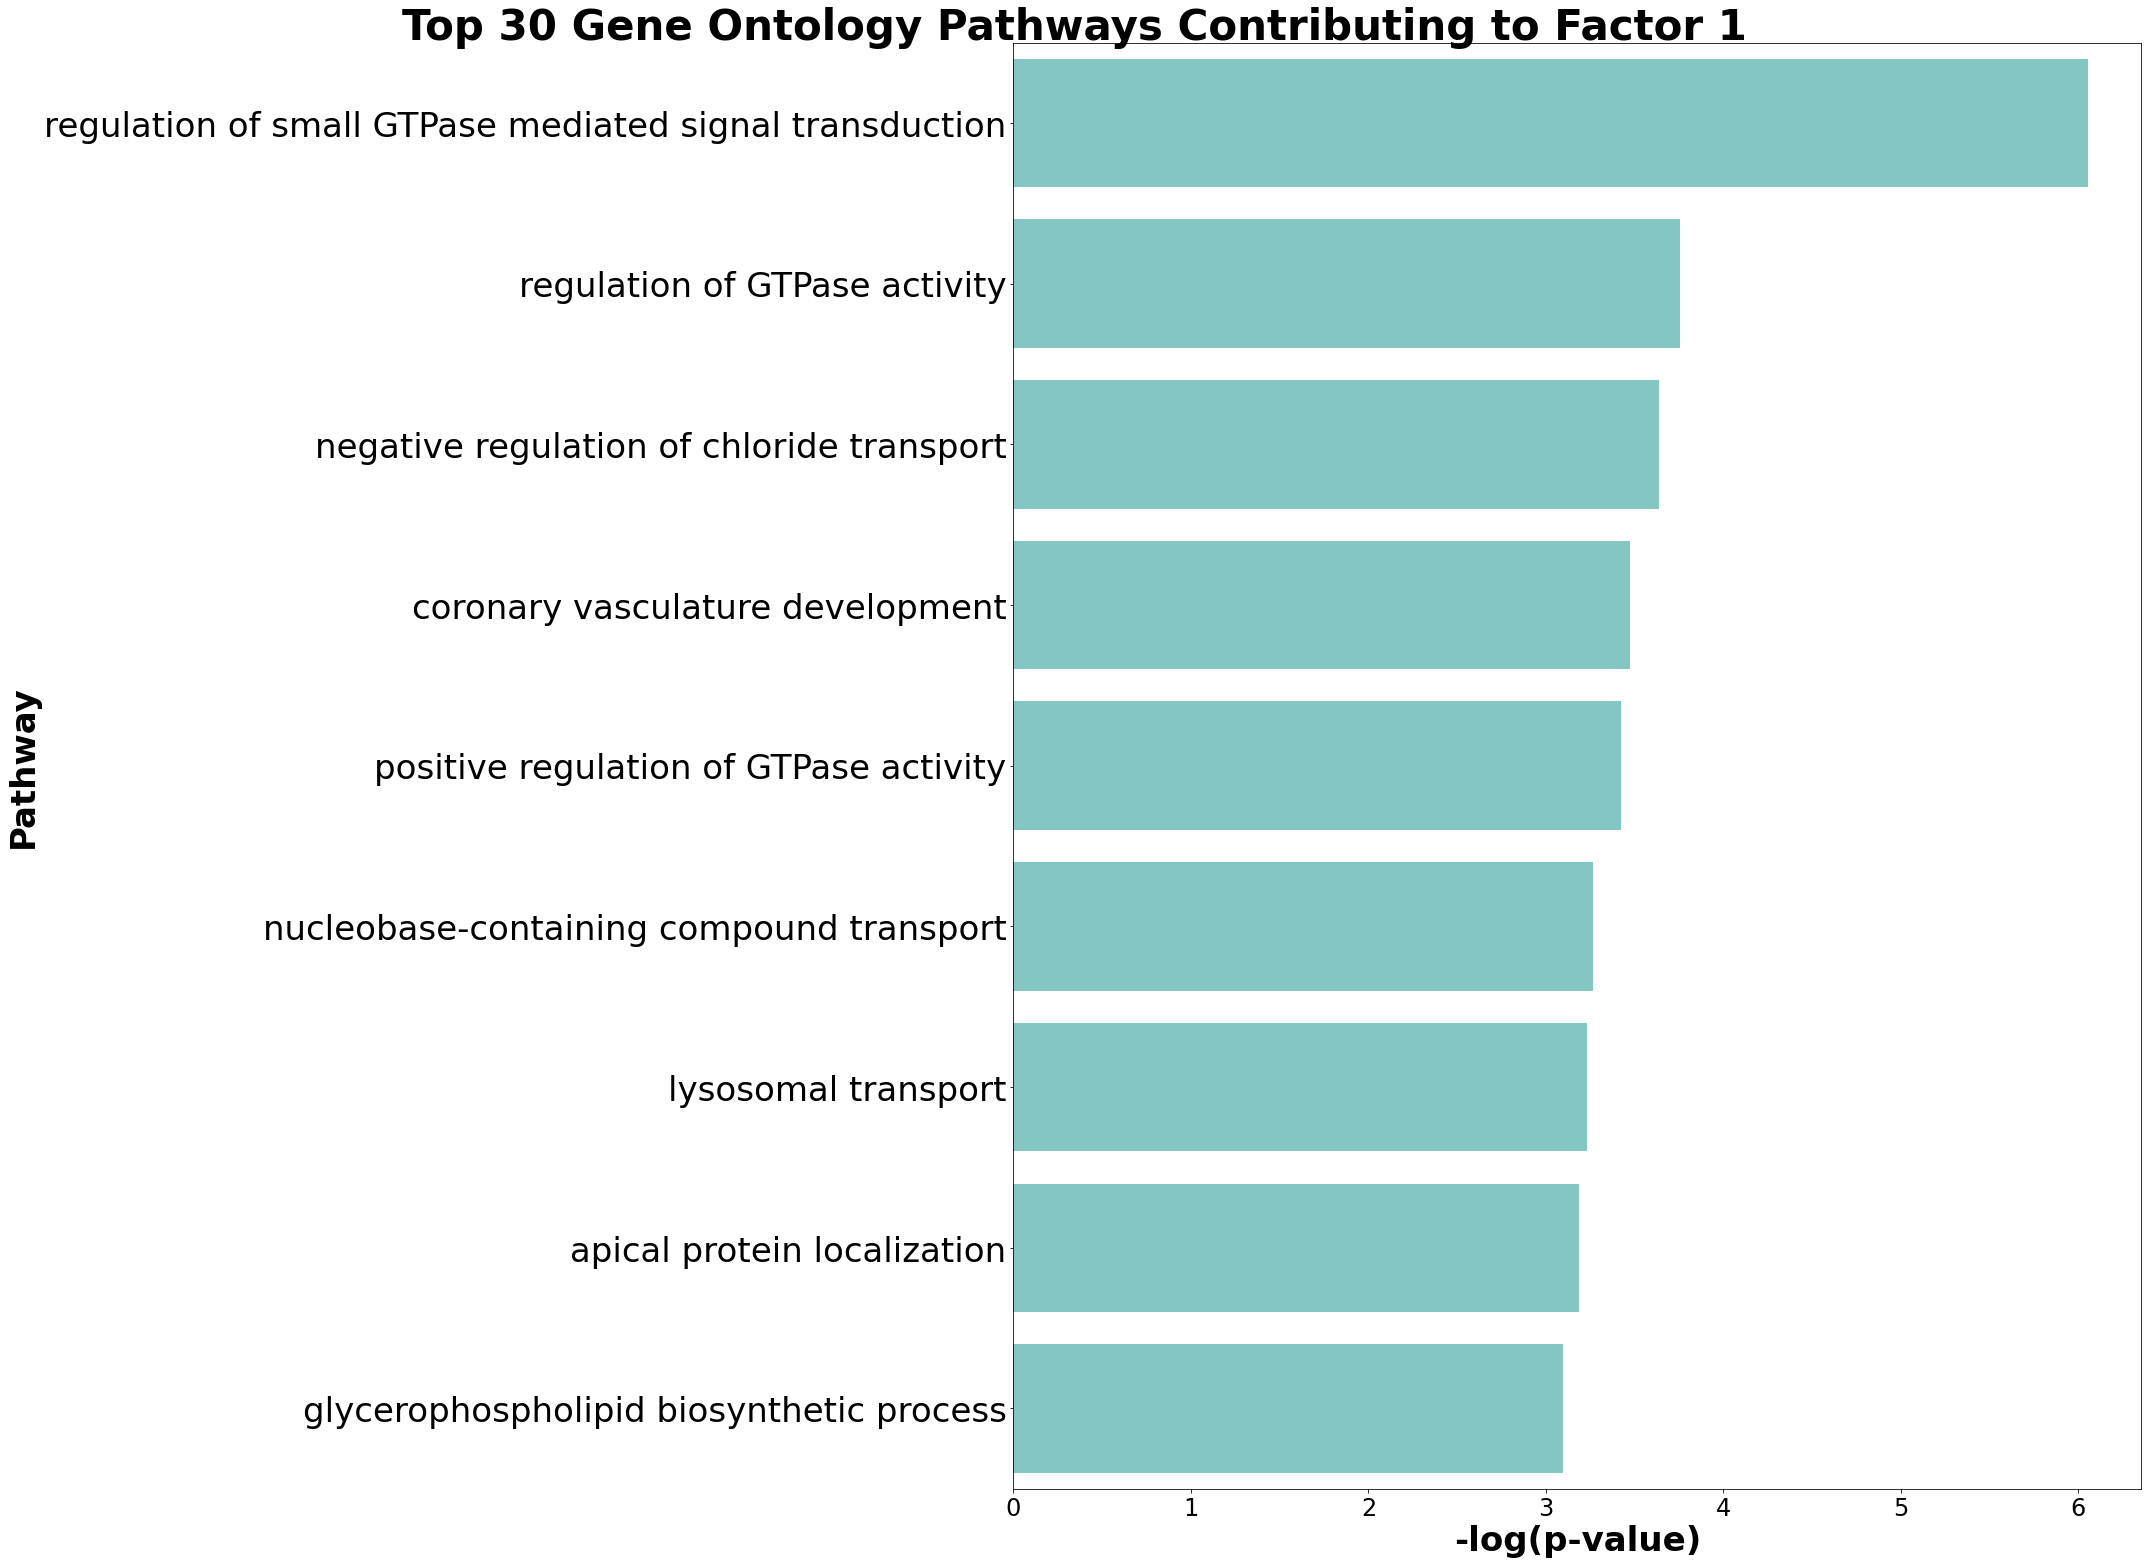

filtered: (30, 11)


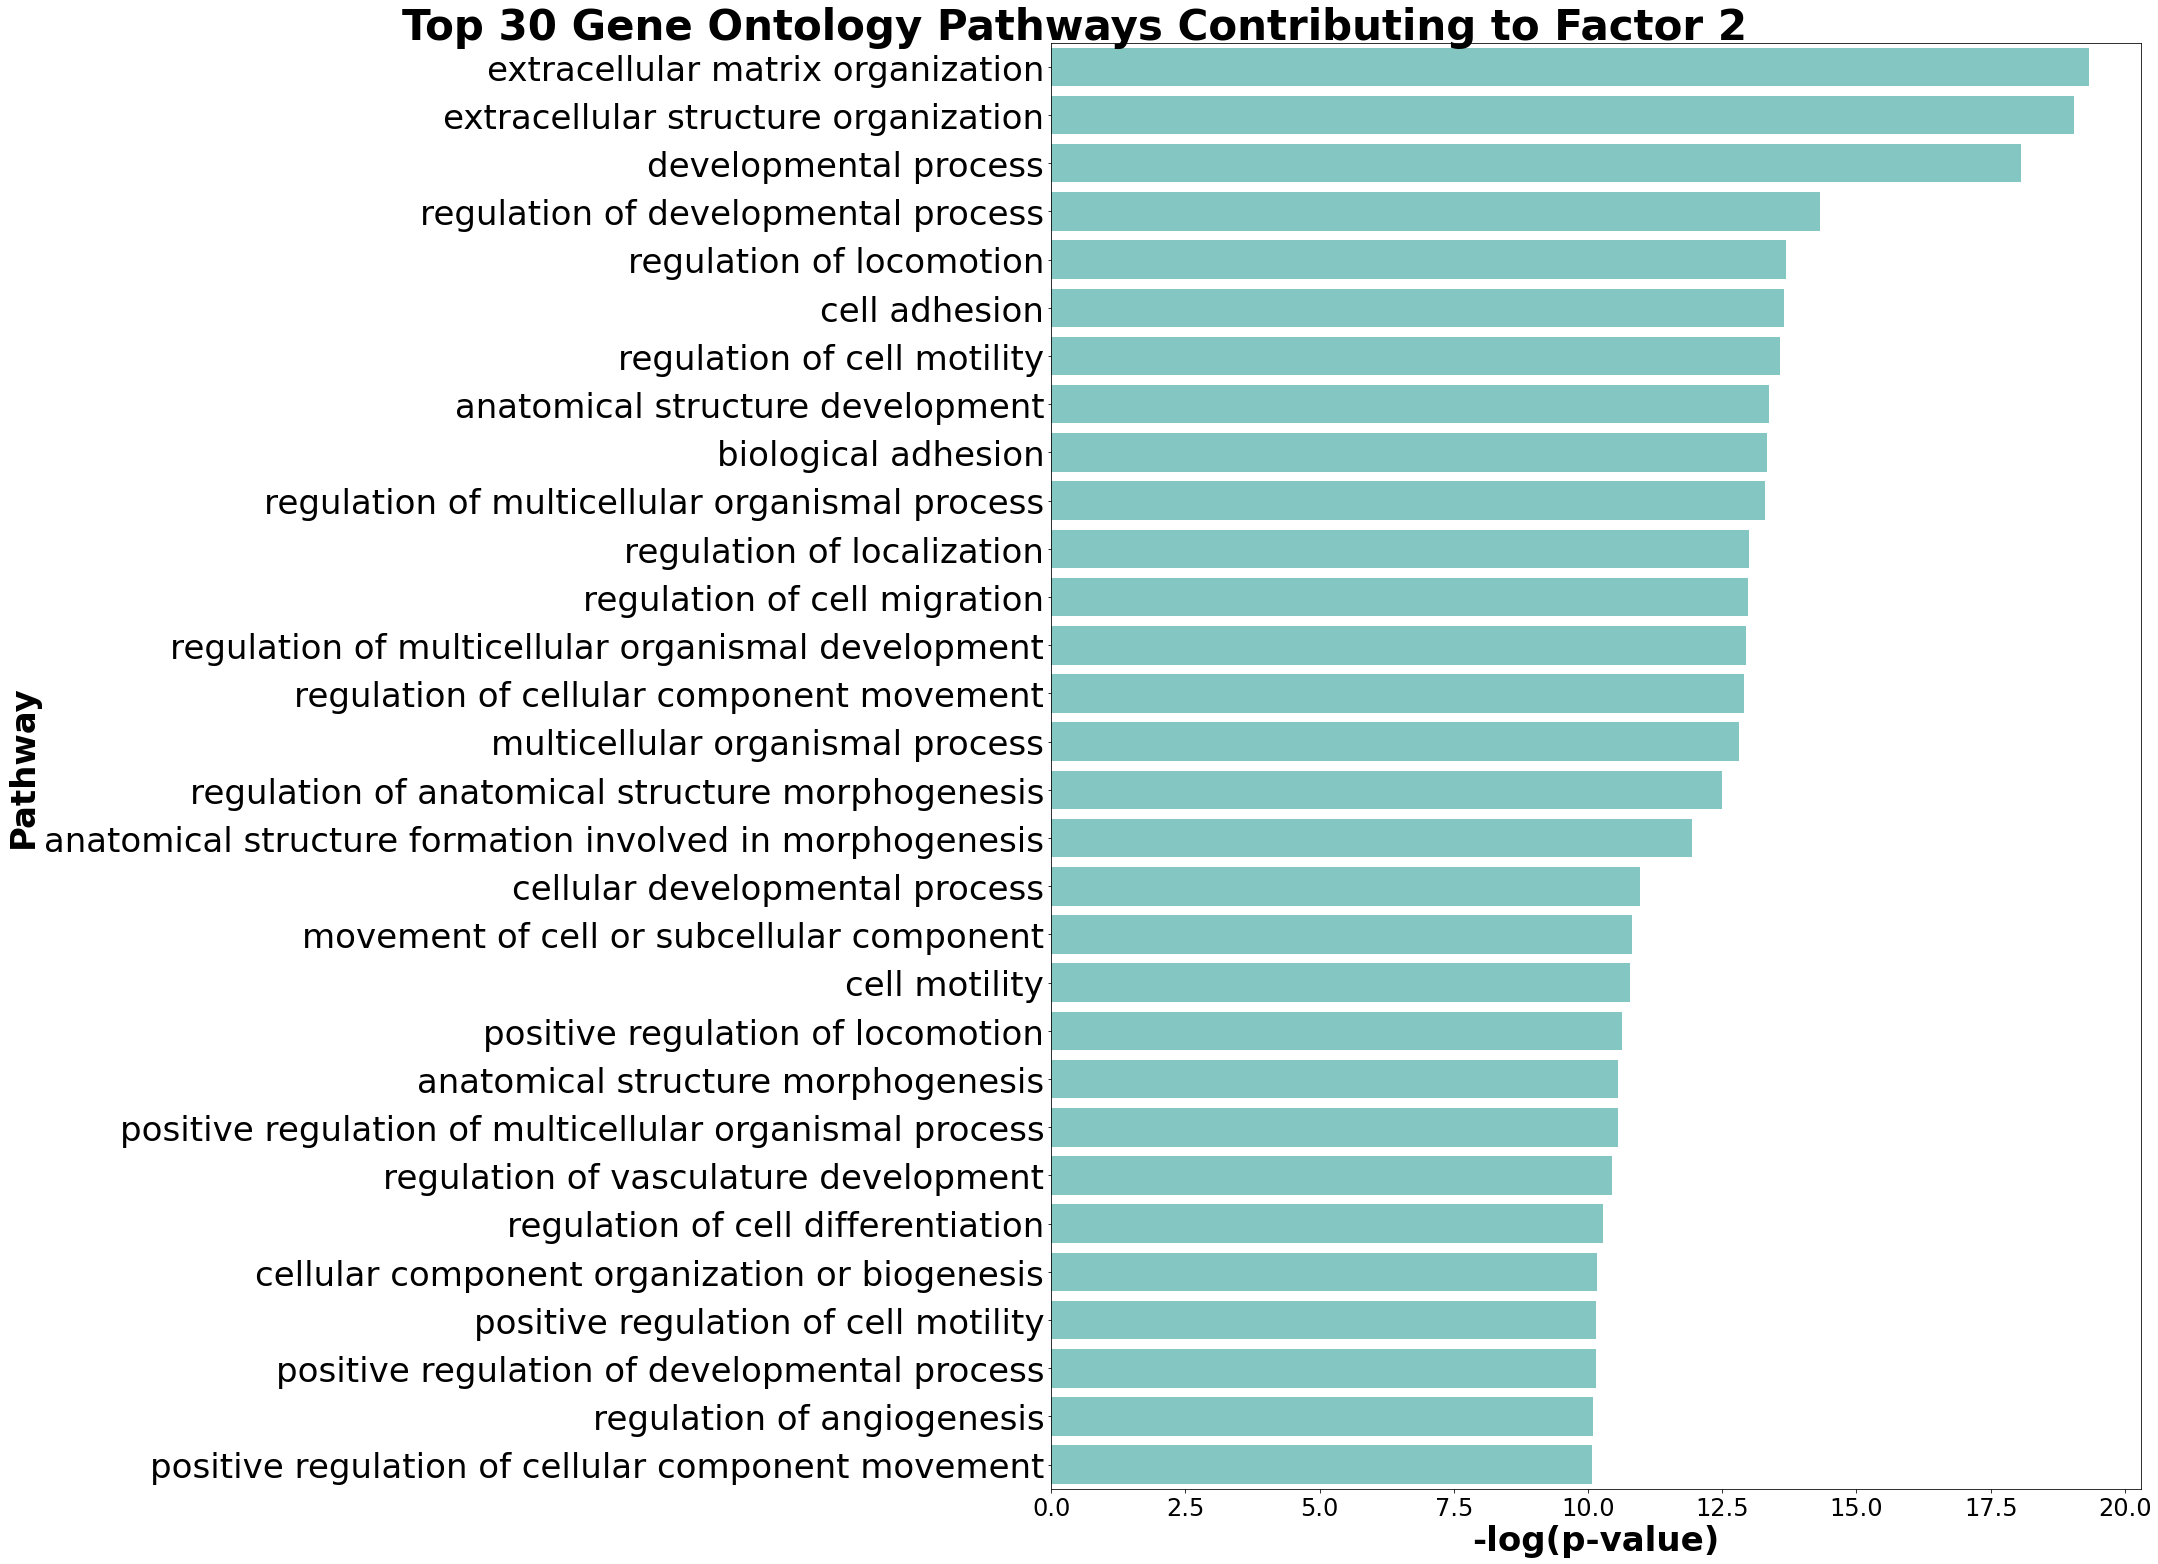

filtered: (30, 11)


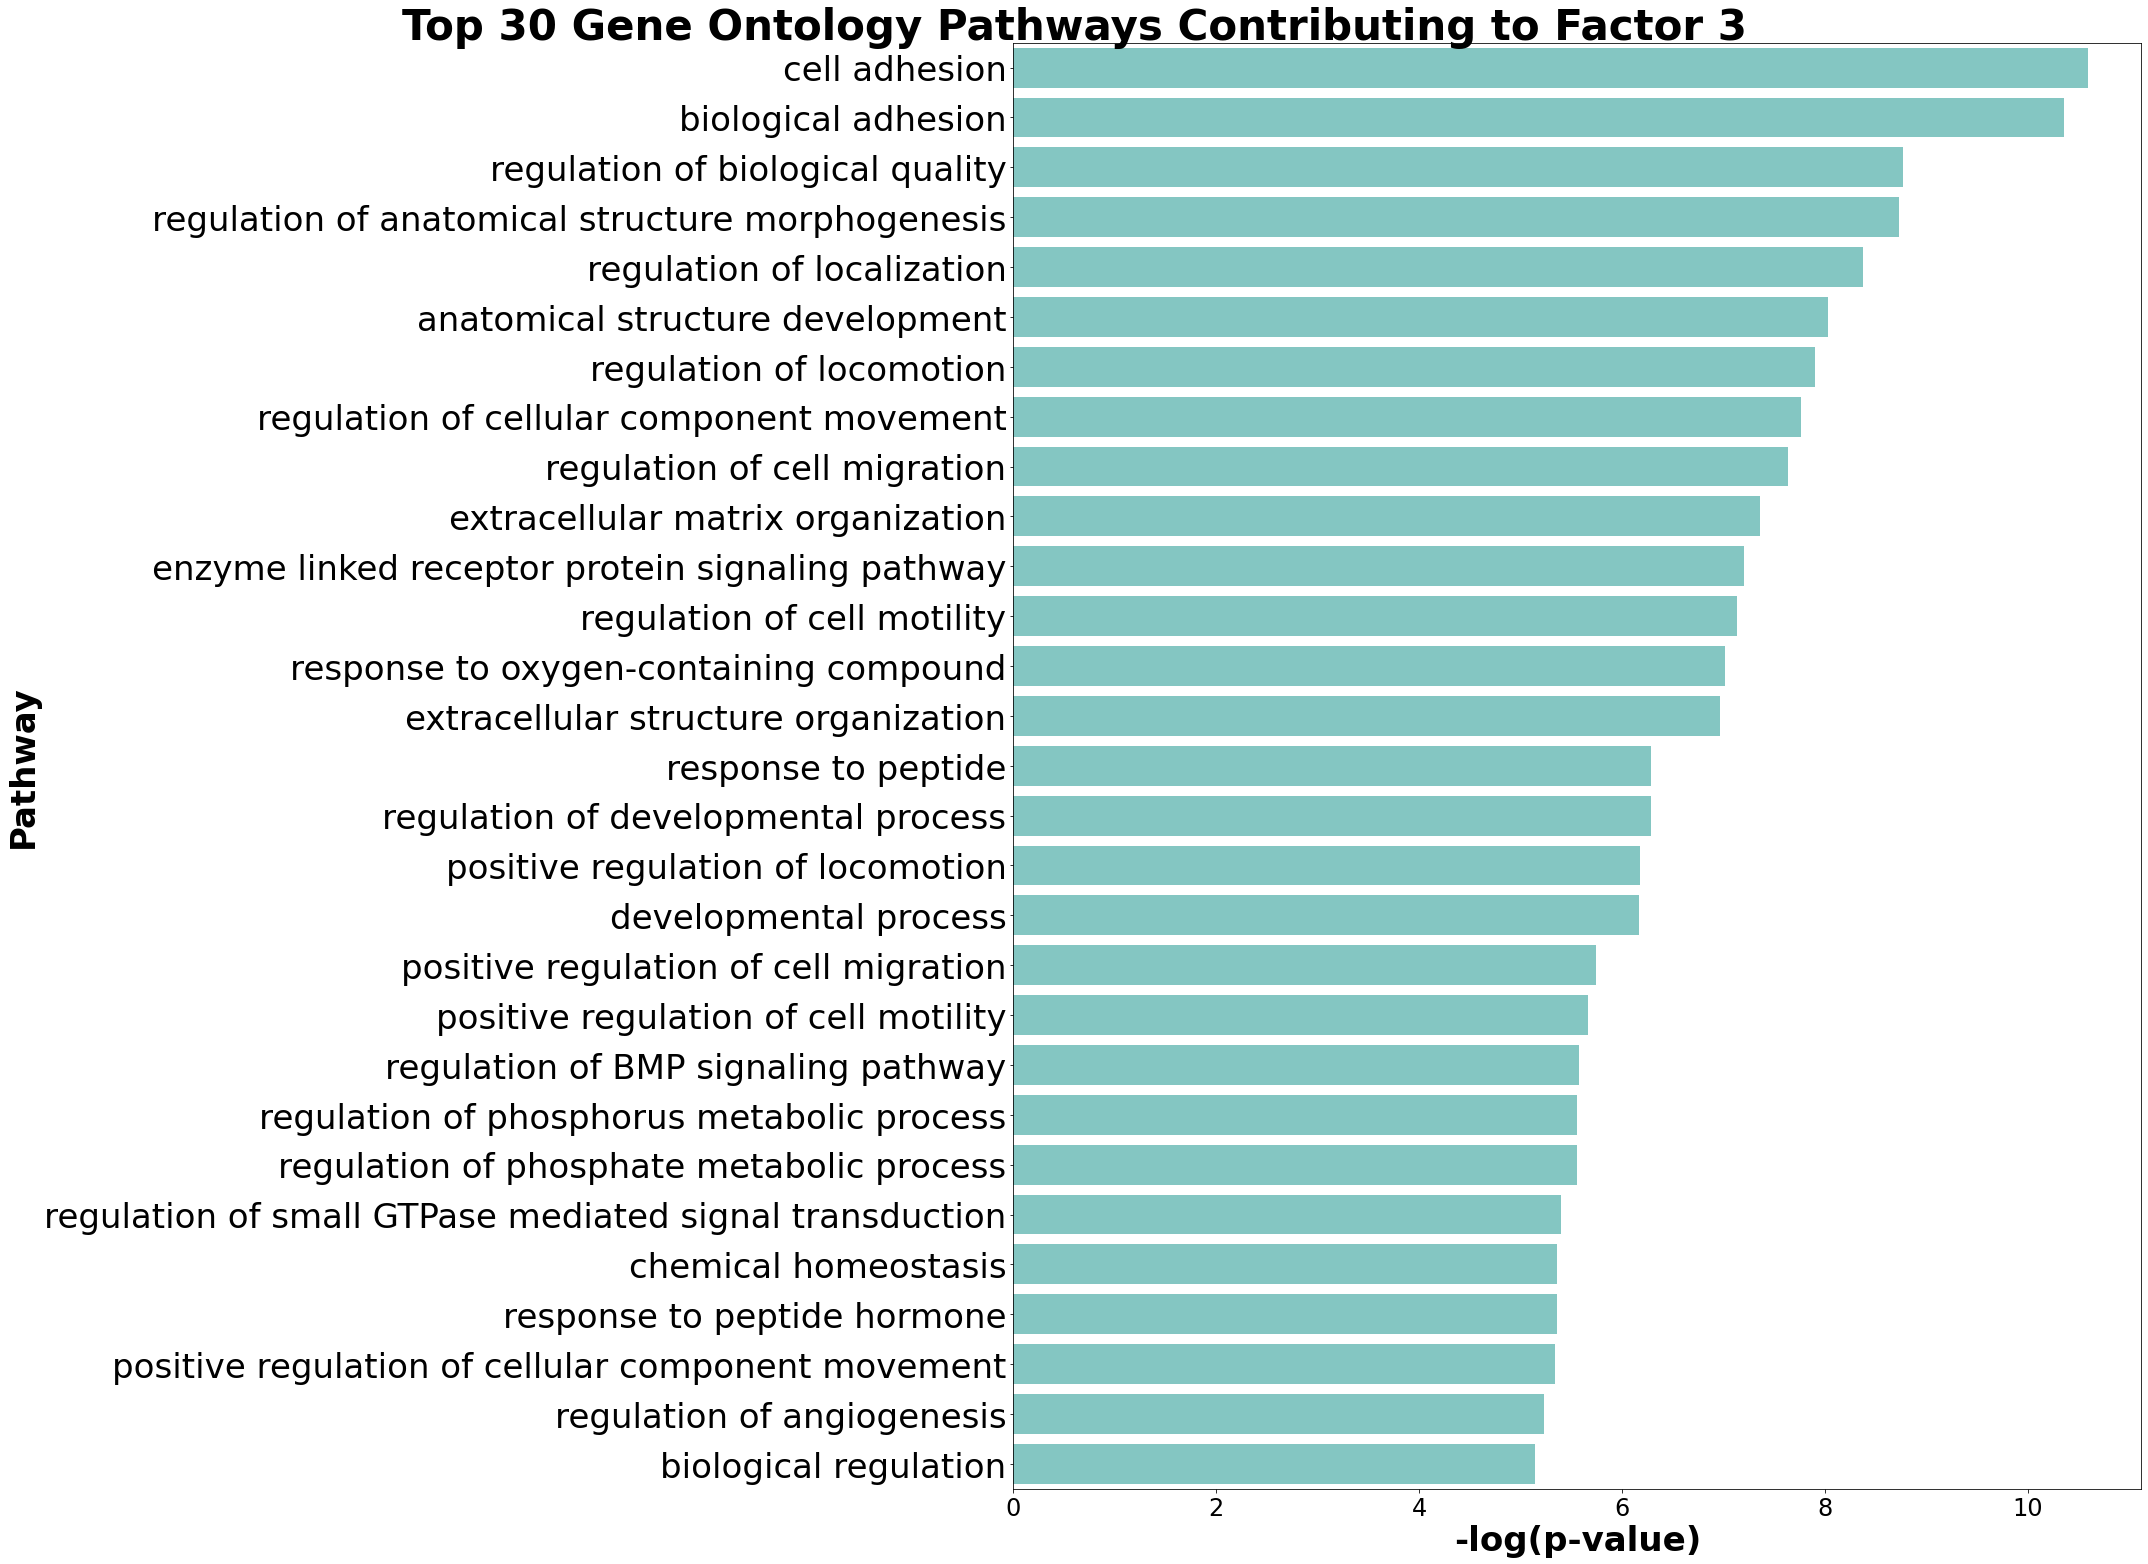

In [89]:
num=0
for sheet_name in sheet_names:
    
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=34, fontweight='bold')
    plt.ylabel('Pathway', fontsize=34, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Factor {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=42)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(34)
    plt.tight_layout()
    plt.xticks(fontsize=24)
    plt.show()